# Setup

**Information about the different models which might be useful when writing the paper**
C-RADIOv2 models are available in multiple sizes: Base (90M parameters). Huge (653M parameters). C-RADIOv2 was trained for 1M steps (400k more steps than v1), using inverse frequency sampling for data balancing, and PHI Standardization for teacher distribution balancing. 

Model Architecture
Architecture Type: Neural Network
Network Architecture: Vision Transformer

c-radio-h	ViT-H/16-CPE https://github.com/NVlabs/RADIO

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
import os
from pathlib import Path

In [2]:
PATH = "../results/results_exp_a_500_sharding_batch4_workers8_dataparallel_memory640000.csv"
MEMORY = 640000
ORIGINAL_DF = pd.read_csv(PATH)
DF = ORIGINAL_DF.copy()

In [3]:
MODELS = {
    "clip-vit-base-patch16": "CLIP",
    "dino_vitb16": "DINO",
    "dinov2_vitb14": "DINOv2",
    "dinov3-vitb16-pretrain-lvd1689m": "DINOv3",
    "C-RADIOv2-B": "C-RADIOv2",
    "siglip2-base-patch16-512": "SigLIP2",
    "tips-b14": "TIPS",
    # "vggt-1b": "VGGT",
}
PREFIXES = {
    "clip-vit-base-patch16": "clip",
    "dino_vitb16": "dino",
    "dinov2_vitb14": "dinov2",
    "dinov3-vitb16-pretrain-lvd1689m": "dinov3",
    "C-RADIOv2-B": "radio",
    "siglip2-base-patch16-512": "siglip2",
    "tips-b14":"tips",
    # "vggt-1b": "vggt",
}
COLORS = {
    "clip-vit-base-patch16": "#1f77b4",
    "dino_vitb16": "#ff7f0e",
    "dinov2_vitb14": "#2ca02c",
    "dinov3-vitb16-pretrain-lvd1689m": "#17becf",
    "C-RADIOv2-B": "#d62728",
    "siglip2-base-patch16-512": "#9467bd",
    "tips-b14": "#8c564b",
    # "vggt-1b": "#e377c2",
}
TRAIN_BINS_DIFFICULTY = {
    "0_30_60_90": "easy",
    "0_45_90": "medium",
    "0_90": "hard",
    "0": "extreme"
}
XTICKS = [0, 15, 30, 45, 60, 75, 90]
CLASS_TO_INDEX = {
    0: 0,
    7: 1,
    8: 2,
    19: 3,
    46: 4,
    57: 5,
    60: 6,
    70: 7,
    99: 8,
    100: 9,
    113: 10,
    125: 11,
    126: 12,
    152: 13,
    166: 14,
    196: 15,
}
CLASS_TO_NAME = {
    0: "background",
    7: "stove",
    8: "sofa",
    19: "microwave",
    46: "bed",
    57: "toy cat",
    60: "toy cow",
    70: "toy dragon",
    99: "coat rack",
    100: "guitar stand",
    113: "ceiling lamp",
    125: "toilet",
    126: "sink",
    152: "strings",
    166: "broccoli",
    196: "durian"
}


# Experiment A

In [4]:
DF.head()

job_id        model  train_bins  val_bin  jac_mean  jac_std   jac0  \
0  12094740  C-RADIOv2-B  0_30_60_90        0     0.668    0.138  0.965   
1  12094740  C-RADIOv2-B  0_30_60_90       15     0.643    0.152  0.963   
2  12094740  C-RADIOv2-B  0_30_60_90       30     0.679    0.136  0.967   
3  12094740  C-RADIOv2-B  0_30_60_90       45     0.659    0.146  0.966   
4  12094740  C-RADIOv2-B  0_30_60_90       60     0.685    0.128  0.968   

    jac1   jac2   jac3  ...  jac10  jac11  jac12  jac13  jac14  jac15  \
0  0.651  0.668  0.644  ...  0.695  0.884  0.528  0.682  0.742  0.858   
1  0.648  0.654  0.600  ...  0.662  0.875  0.451  0.693  0.725  0.852   
2  0.690  0.689  0.642  ...  0.690  0.876  0.524  0.739  0.728  0.861   
3  0.693  0.651  0.609  ...  0.686  0.869  0.525  0.737  0.718  0.862   
4  0.702  0.688  0.613  ...  0.698  0.861  0.556  0.744  0.721  0.864   

   d_model  batch_size  input_size  patch_size  
0      768           4         512          16  
1      768           4         512          16  
2      768           4         512          16  
3      768           4         512          16  
4      768           4         512          16  

[5 rows x 26 columns]

In [5]:
DF_A = DF.copy()

def plot_exp_a(classes: None | list[int], include_bg: bool, extratitle: str, save_path: str | None = None):
    """
    Plot experiment A result as grouped bar histograms per class and model.
    """
    assert type(classes) in [list, type(None)], "classes must be a list or None"

    if classes is None:
        classes = list(CLASS_TO_INDEX.keys())
    else:
        assert all(c in CLASS_TO_INDEX for c in classes), "classes must be a subset of CLASS_TO_INDEX keys"

    if not include_bg:
        classes = [c for c in classes if c != 0]

    class_indices = [CLASS_TO_INDEX[c] for c in classes]

    fig, axes = plt.subplots(2, 2, figsize=(14, 8), dpi=200)
    axes = axes.flatten()

    bar_width = 0.1
    for i, (train_bins, difficulty) in enumerate(TRAIN_BINS_DIFFICULTY.items()):
        ax = axes[i]
        train_bins_set = set(map(int, train_bins.split("_")))  # ToDo: ?
        bin_vals = sorted(set(DF_A["val_bin"]))

        x_pos = np.arange(len(bin_vals))  # One group per val_bin
        total_models = len(MODELS)

        for model_idx, (model, model_label) in enumerate(MODELS.items()):
            df = DF_A[(DF_A["model"] == model) & (DF_A["train_bins"] == train_bins)].sort_values("val_bin")
            if df.empty:
                print(f"No data for model {model} with train_bins {train_bins} and classes {classes}")
                continue

            # Offset x for grouped bars
            offset = (model_idx - total_models / 2) * bar_width + bar_width / 2
            x_offset = x_pos + offset

            means = df[[f"jac{c}" for c in class_indices]].mean(axis=1).values

            if i == 0:
                means[0] = 0
                means[2] = 0
                means[4] = 0
                means[6] = 0
            elif i == 1:
                means[0] = 0
                means[3] = 0
                means[6] = 0
            elif i == 2:
                means[0] = 0
                means[6] = 0
            elif i == 3:
                means[0] = 0

            ax.bar(x_offset, means, width=bar_width, label=model_label,
                   color=COLORS[model], capsize=4, zorder=2)

            means = df[[f"jac{c}" for c in class_indices]].mean(axis=1).values
            if i == 0:
                means[1] = 0
                means[3] = 0
                means[5] = 0
            elif i == 1:
                means[1] = 0
                means[2] = 0
                means[4] = 0
                means[5] = 0
            elif i == 2:
                means[1] = 0
                means[2] = 0
                means[3] = 0
                means[4] = 0
                means[5] = 0
            elif i == 3:
                means[6] = 0
                means[1] = 0
                means[2] = 0
                means[3] = 0
                means[4] = 0
                means[5] = 0
            ax.scatter(x_offset, means, marker='.', color=COLORS[model], s=50, zorder=3)

        ax.set_xticks(x_pos)
        ax.set_xticklabels([str(b) for b in bin_vals])
        ax.set_ylim(0, 1)
        ax.set_title(f"({string.ascii_letters[i]}) Train bin(s): {', '.join(train_bins.split('_'))} ({difficulty})")
        ax.set_xlabel("Validation Bin")
        ax.set_ylabel("mIoU")
        ax.grid(True, axis='y', linestyle='--', linewidth=0.5)

    axes[0].legend(loc="lower left", bbox_to_anchor=(0, 0))
    plt.suptitle(f"Experiment A Results — {extratitle}", fontsize=25, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])


    # Save figure
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure to {save_path}")

    plt.show()
    plt.close()


## Plots

Saved figure to ../images/figures/All_Classes_No_BG.png


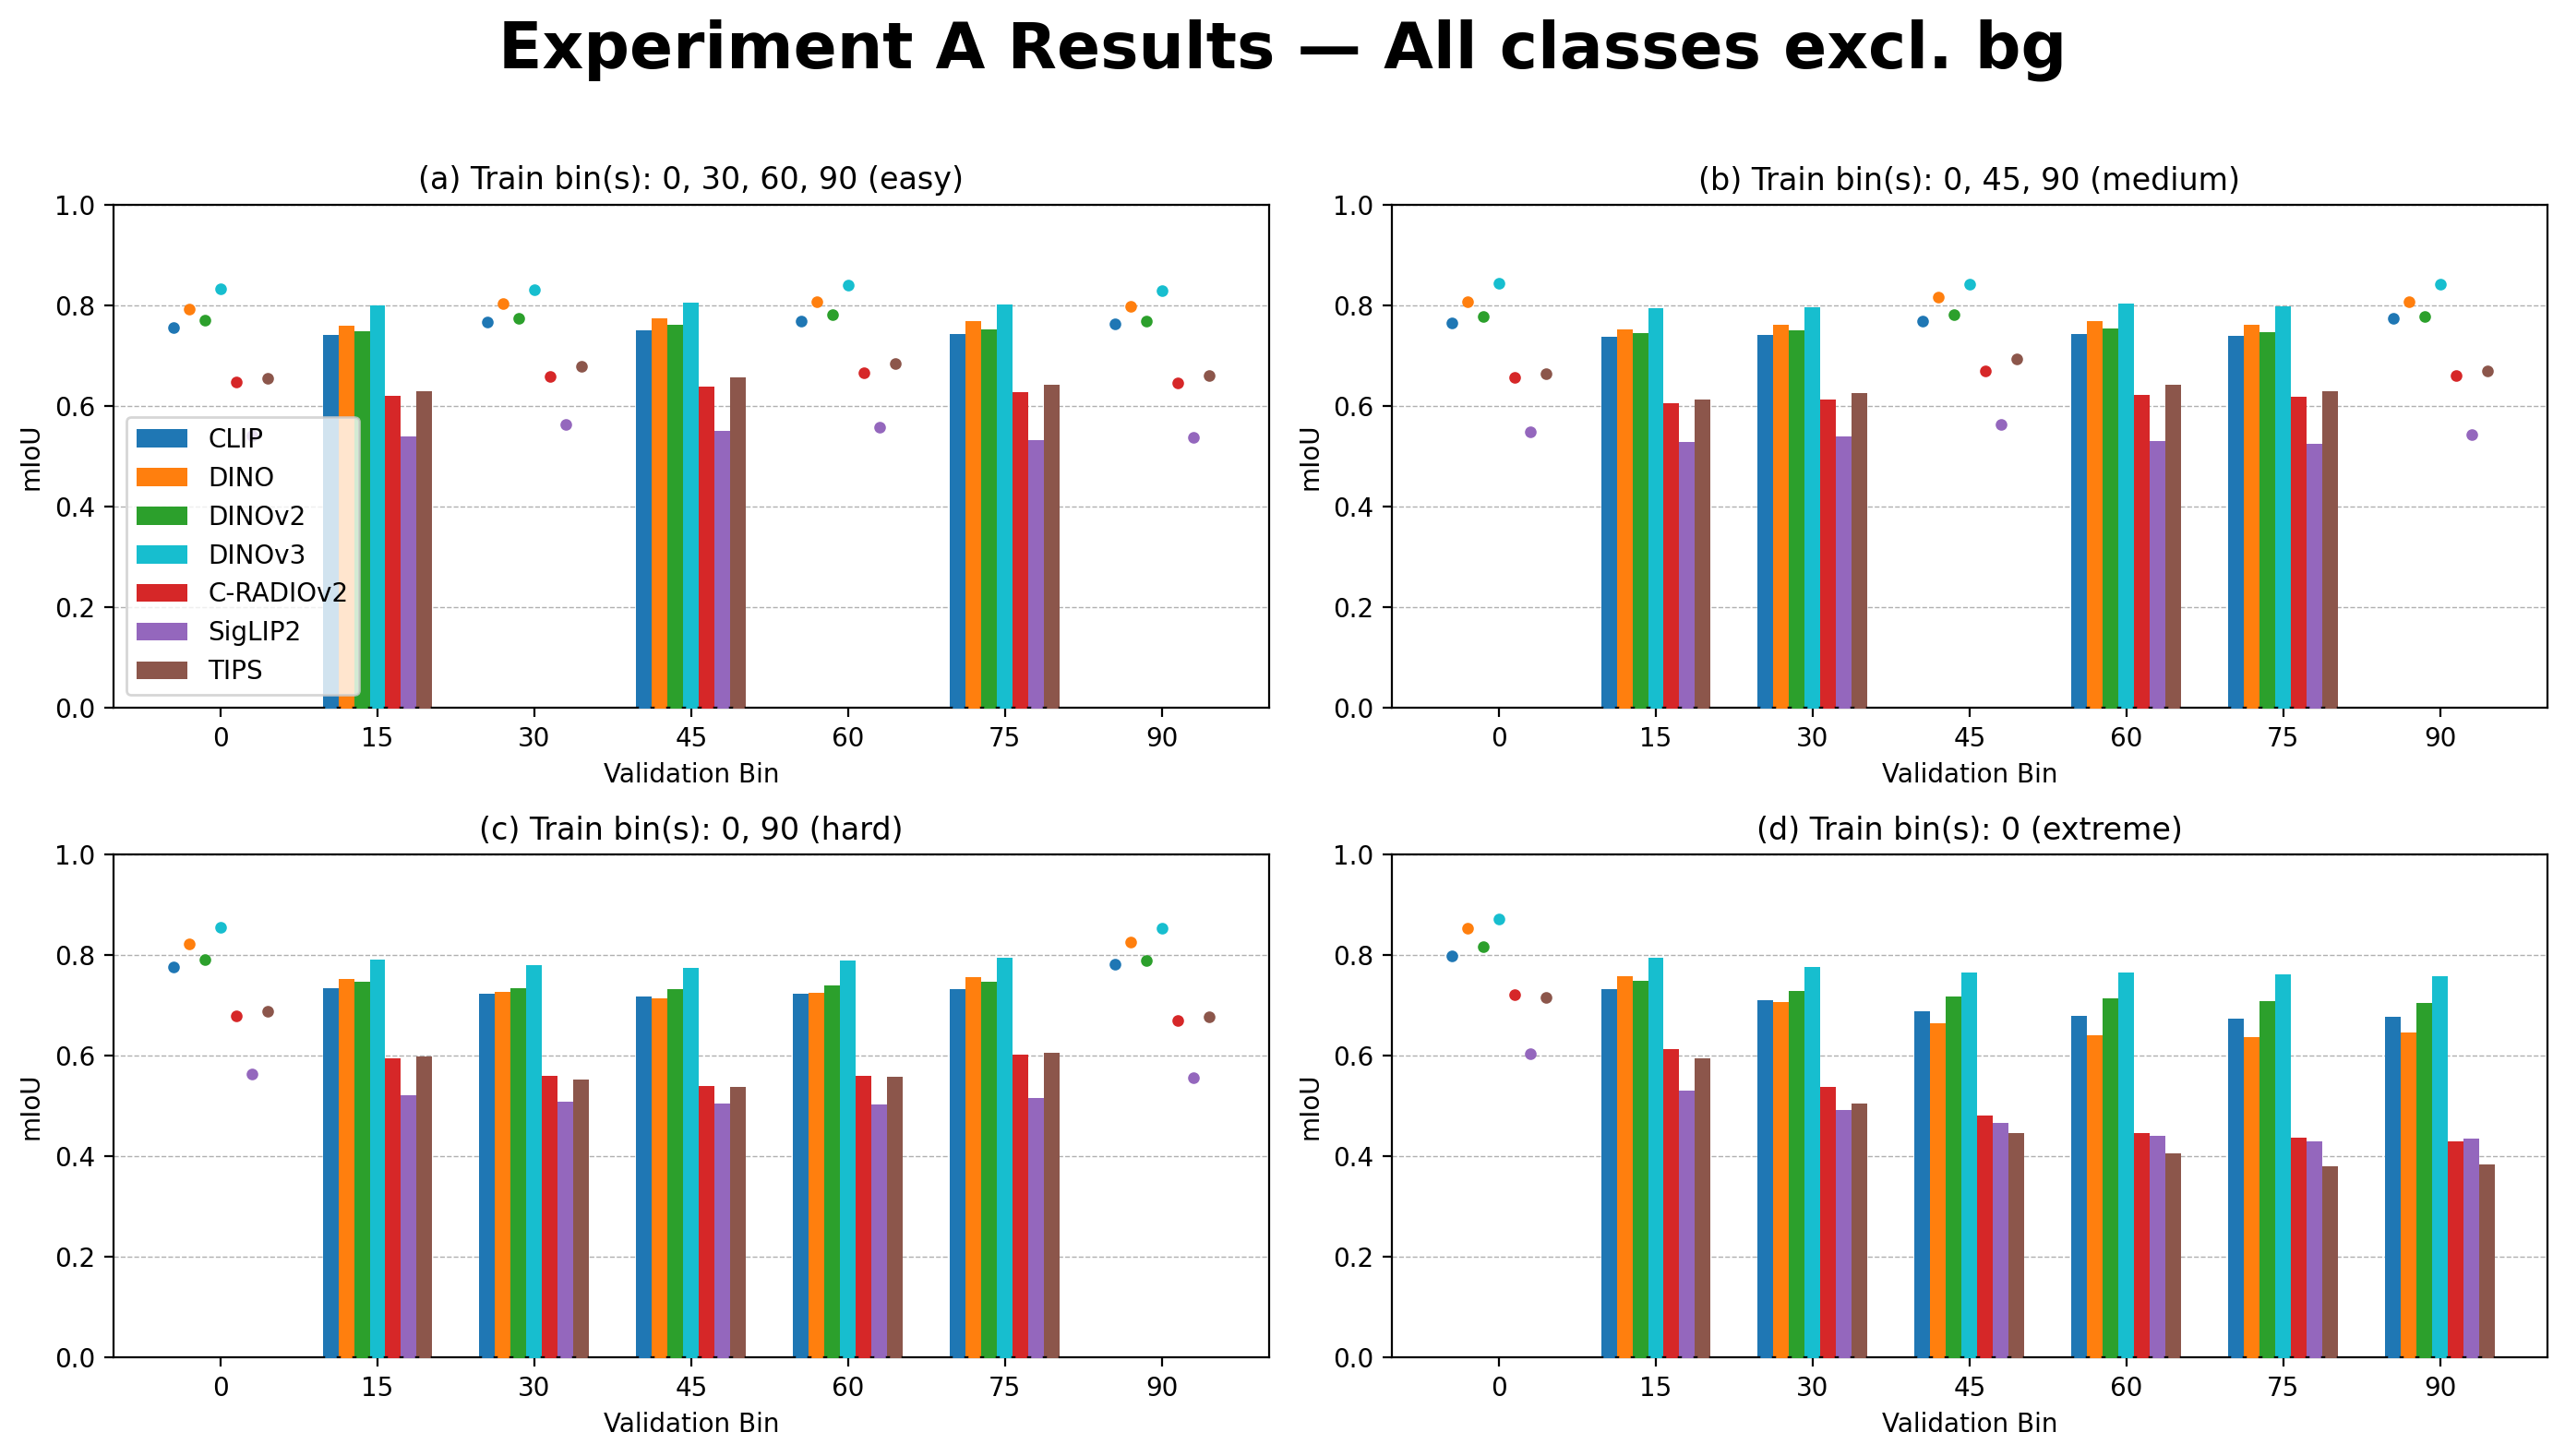

Saved figure to ../images/figures/All_Classes.png


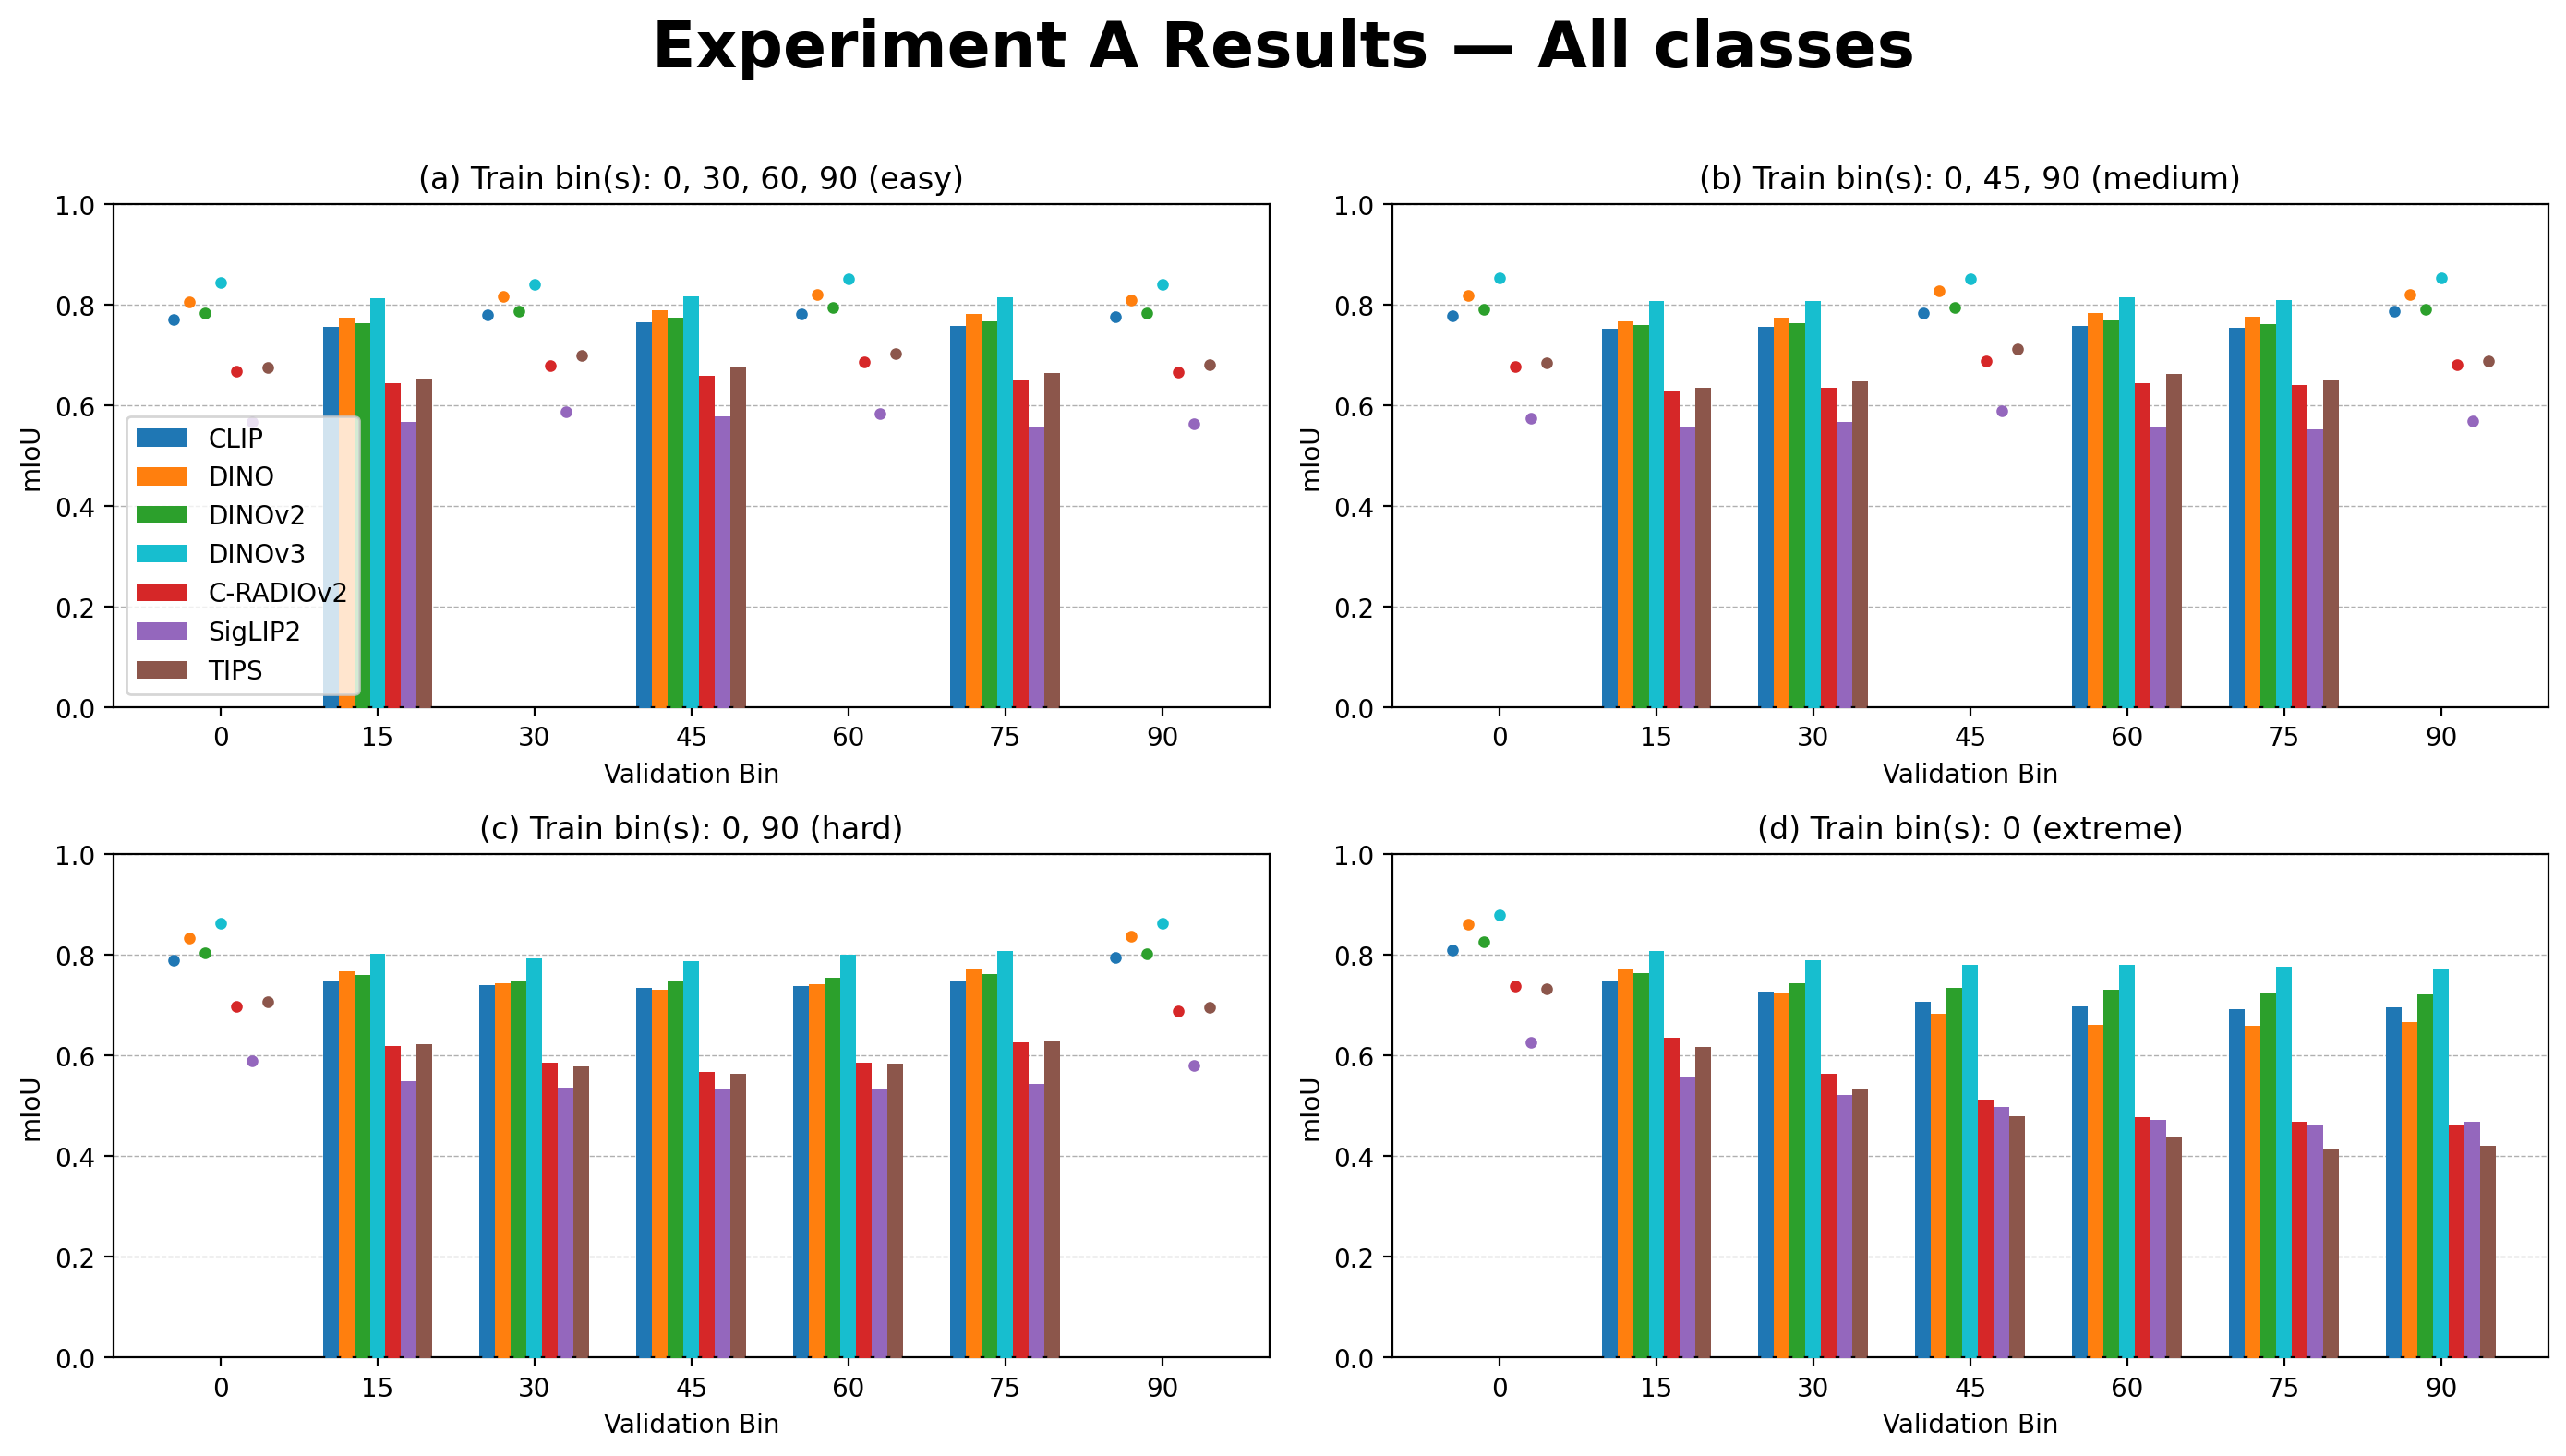

In [6]:
# Experiment A (Grouped Bar Histograms)
os.makedirs("../images/figures", exist_ok=True)

# Plot all classes
plot_exp_a(None, False, extratitle="All classes excl. bg", save_path="../images/figures/All_Classes_No_BG.png")
plot_exp_a(None, True, extratitle="All classes", save_path="../images/figures/All_Classes.png")

Saved figure to ../images/figures/0_background.png


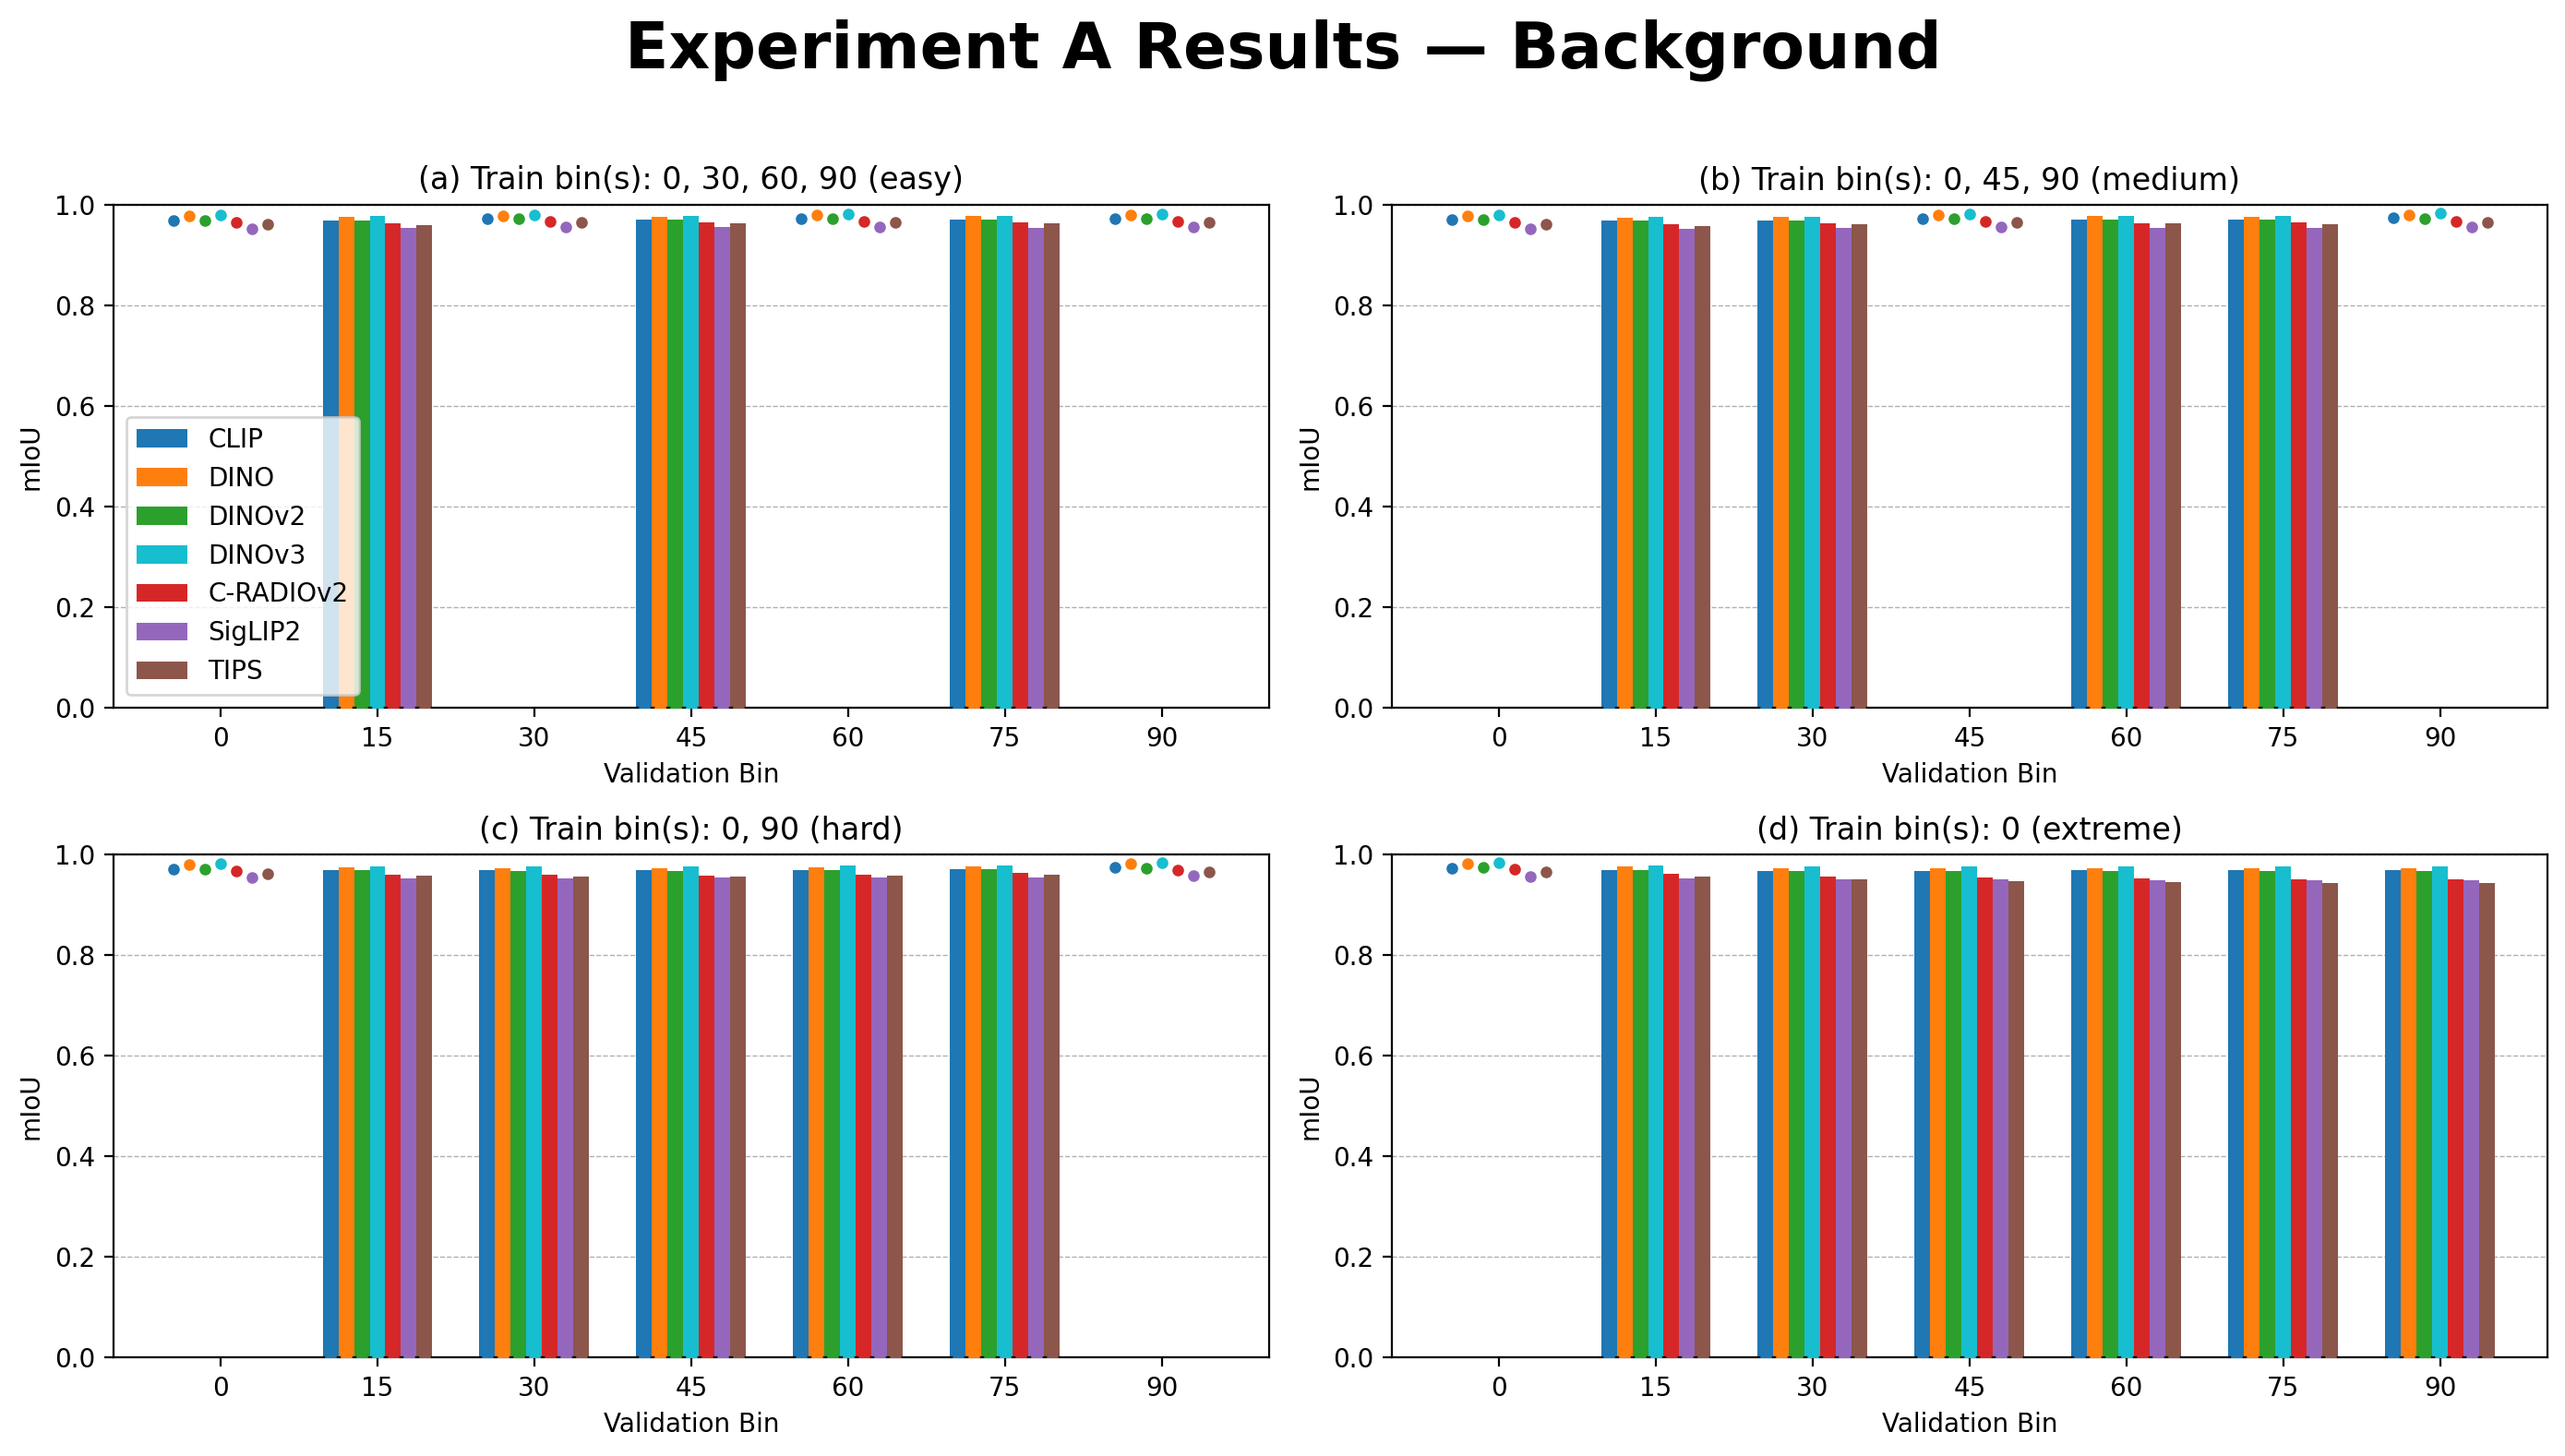

Saved figure to ../images/figures/1_stove.png


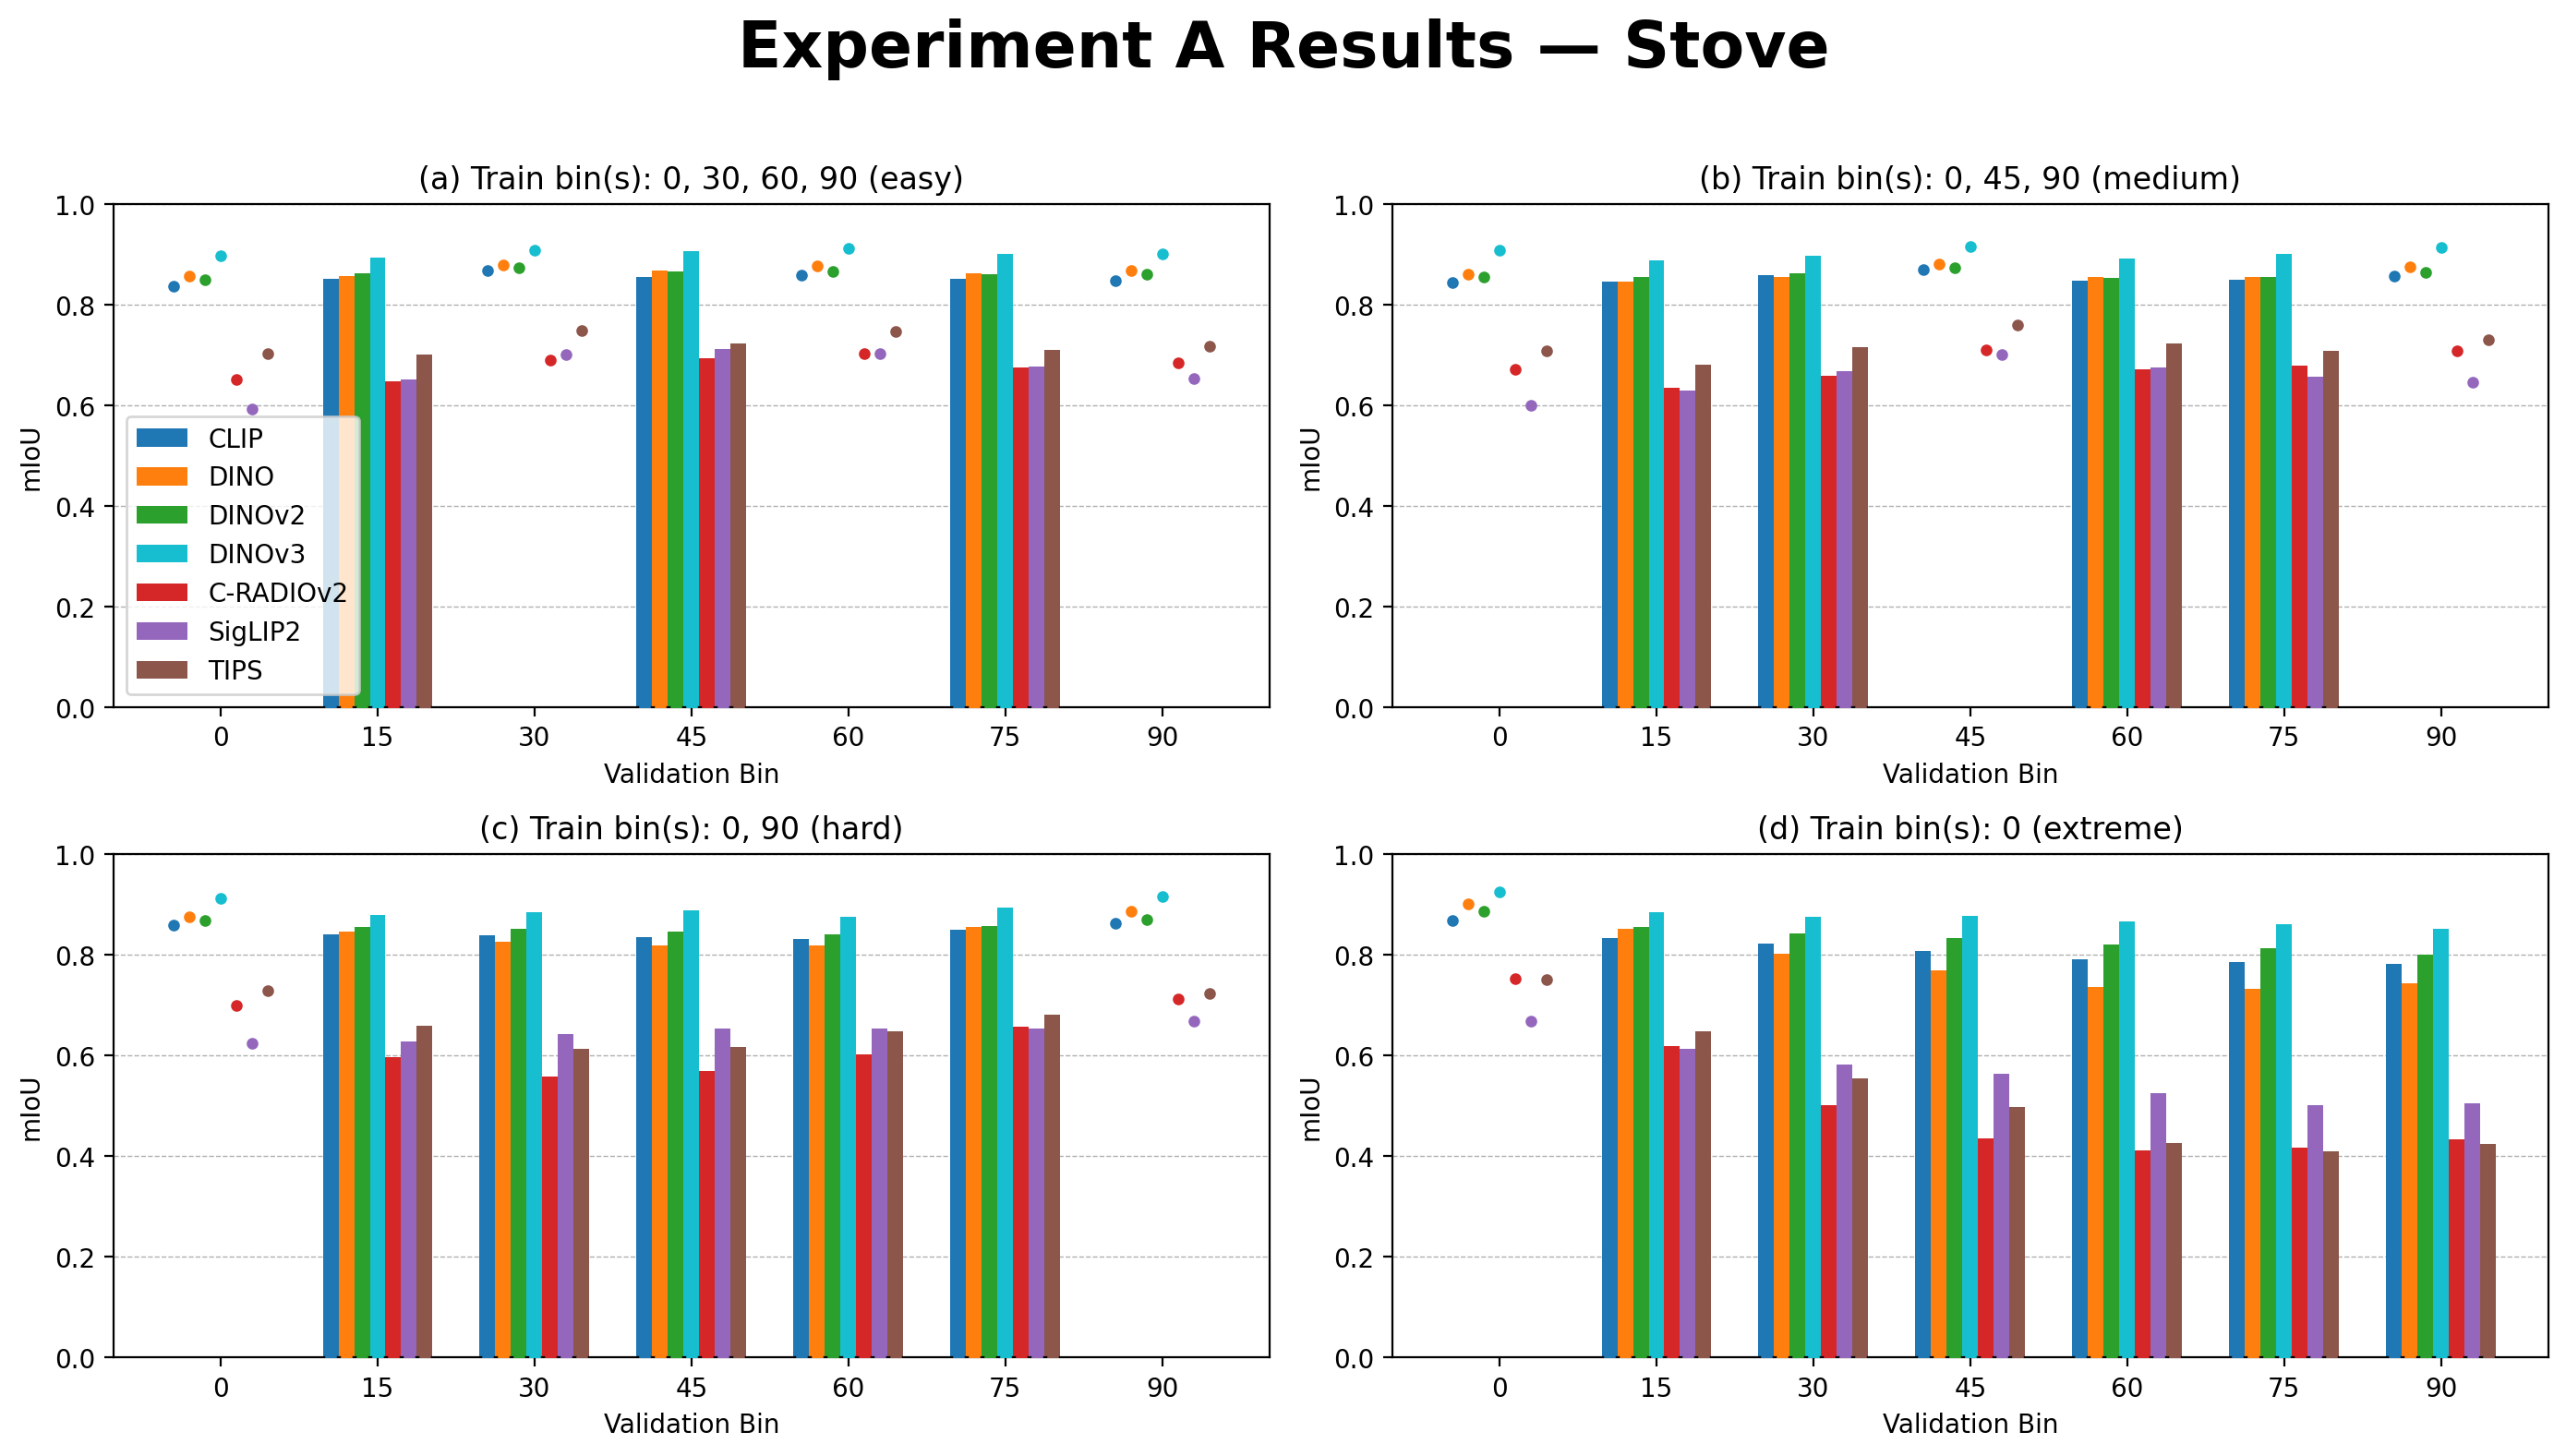

Saved figure to ../images/figures/2_sofa.png


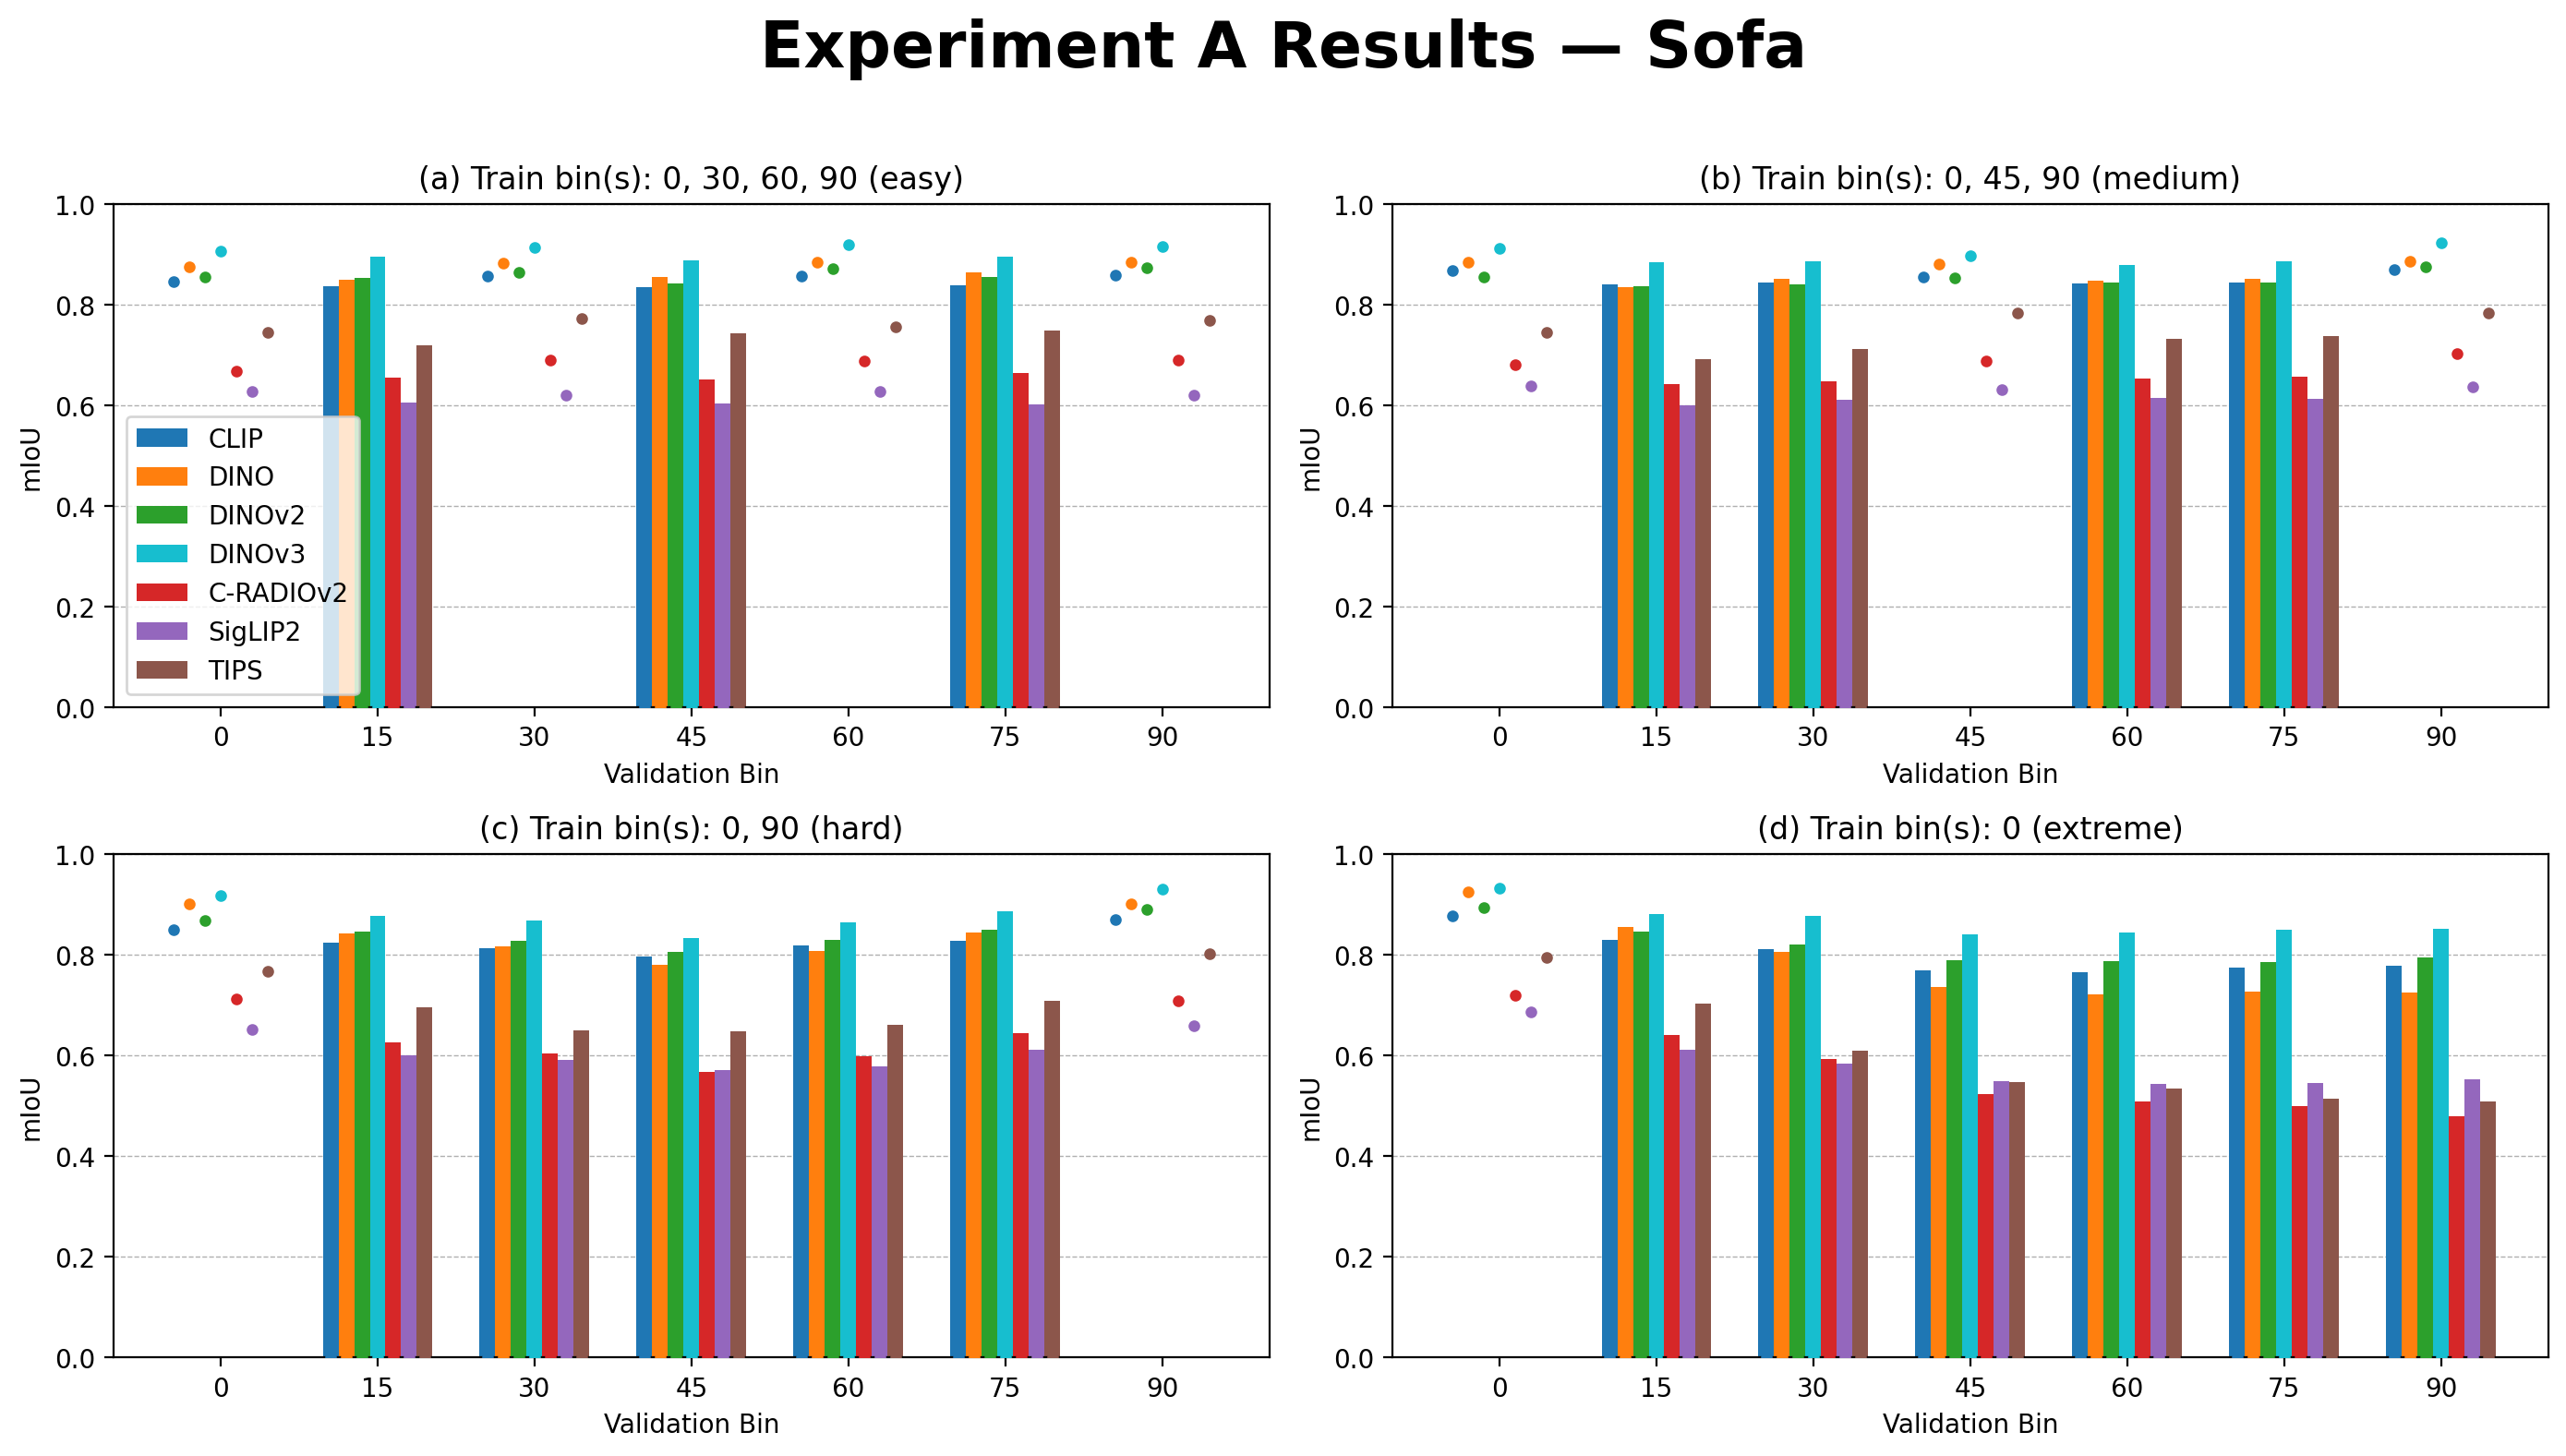

Saved figure to ../images/figures/3_microwave.png


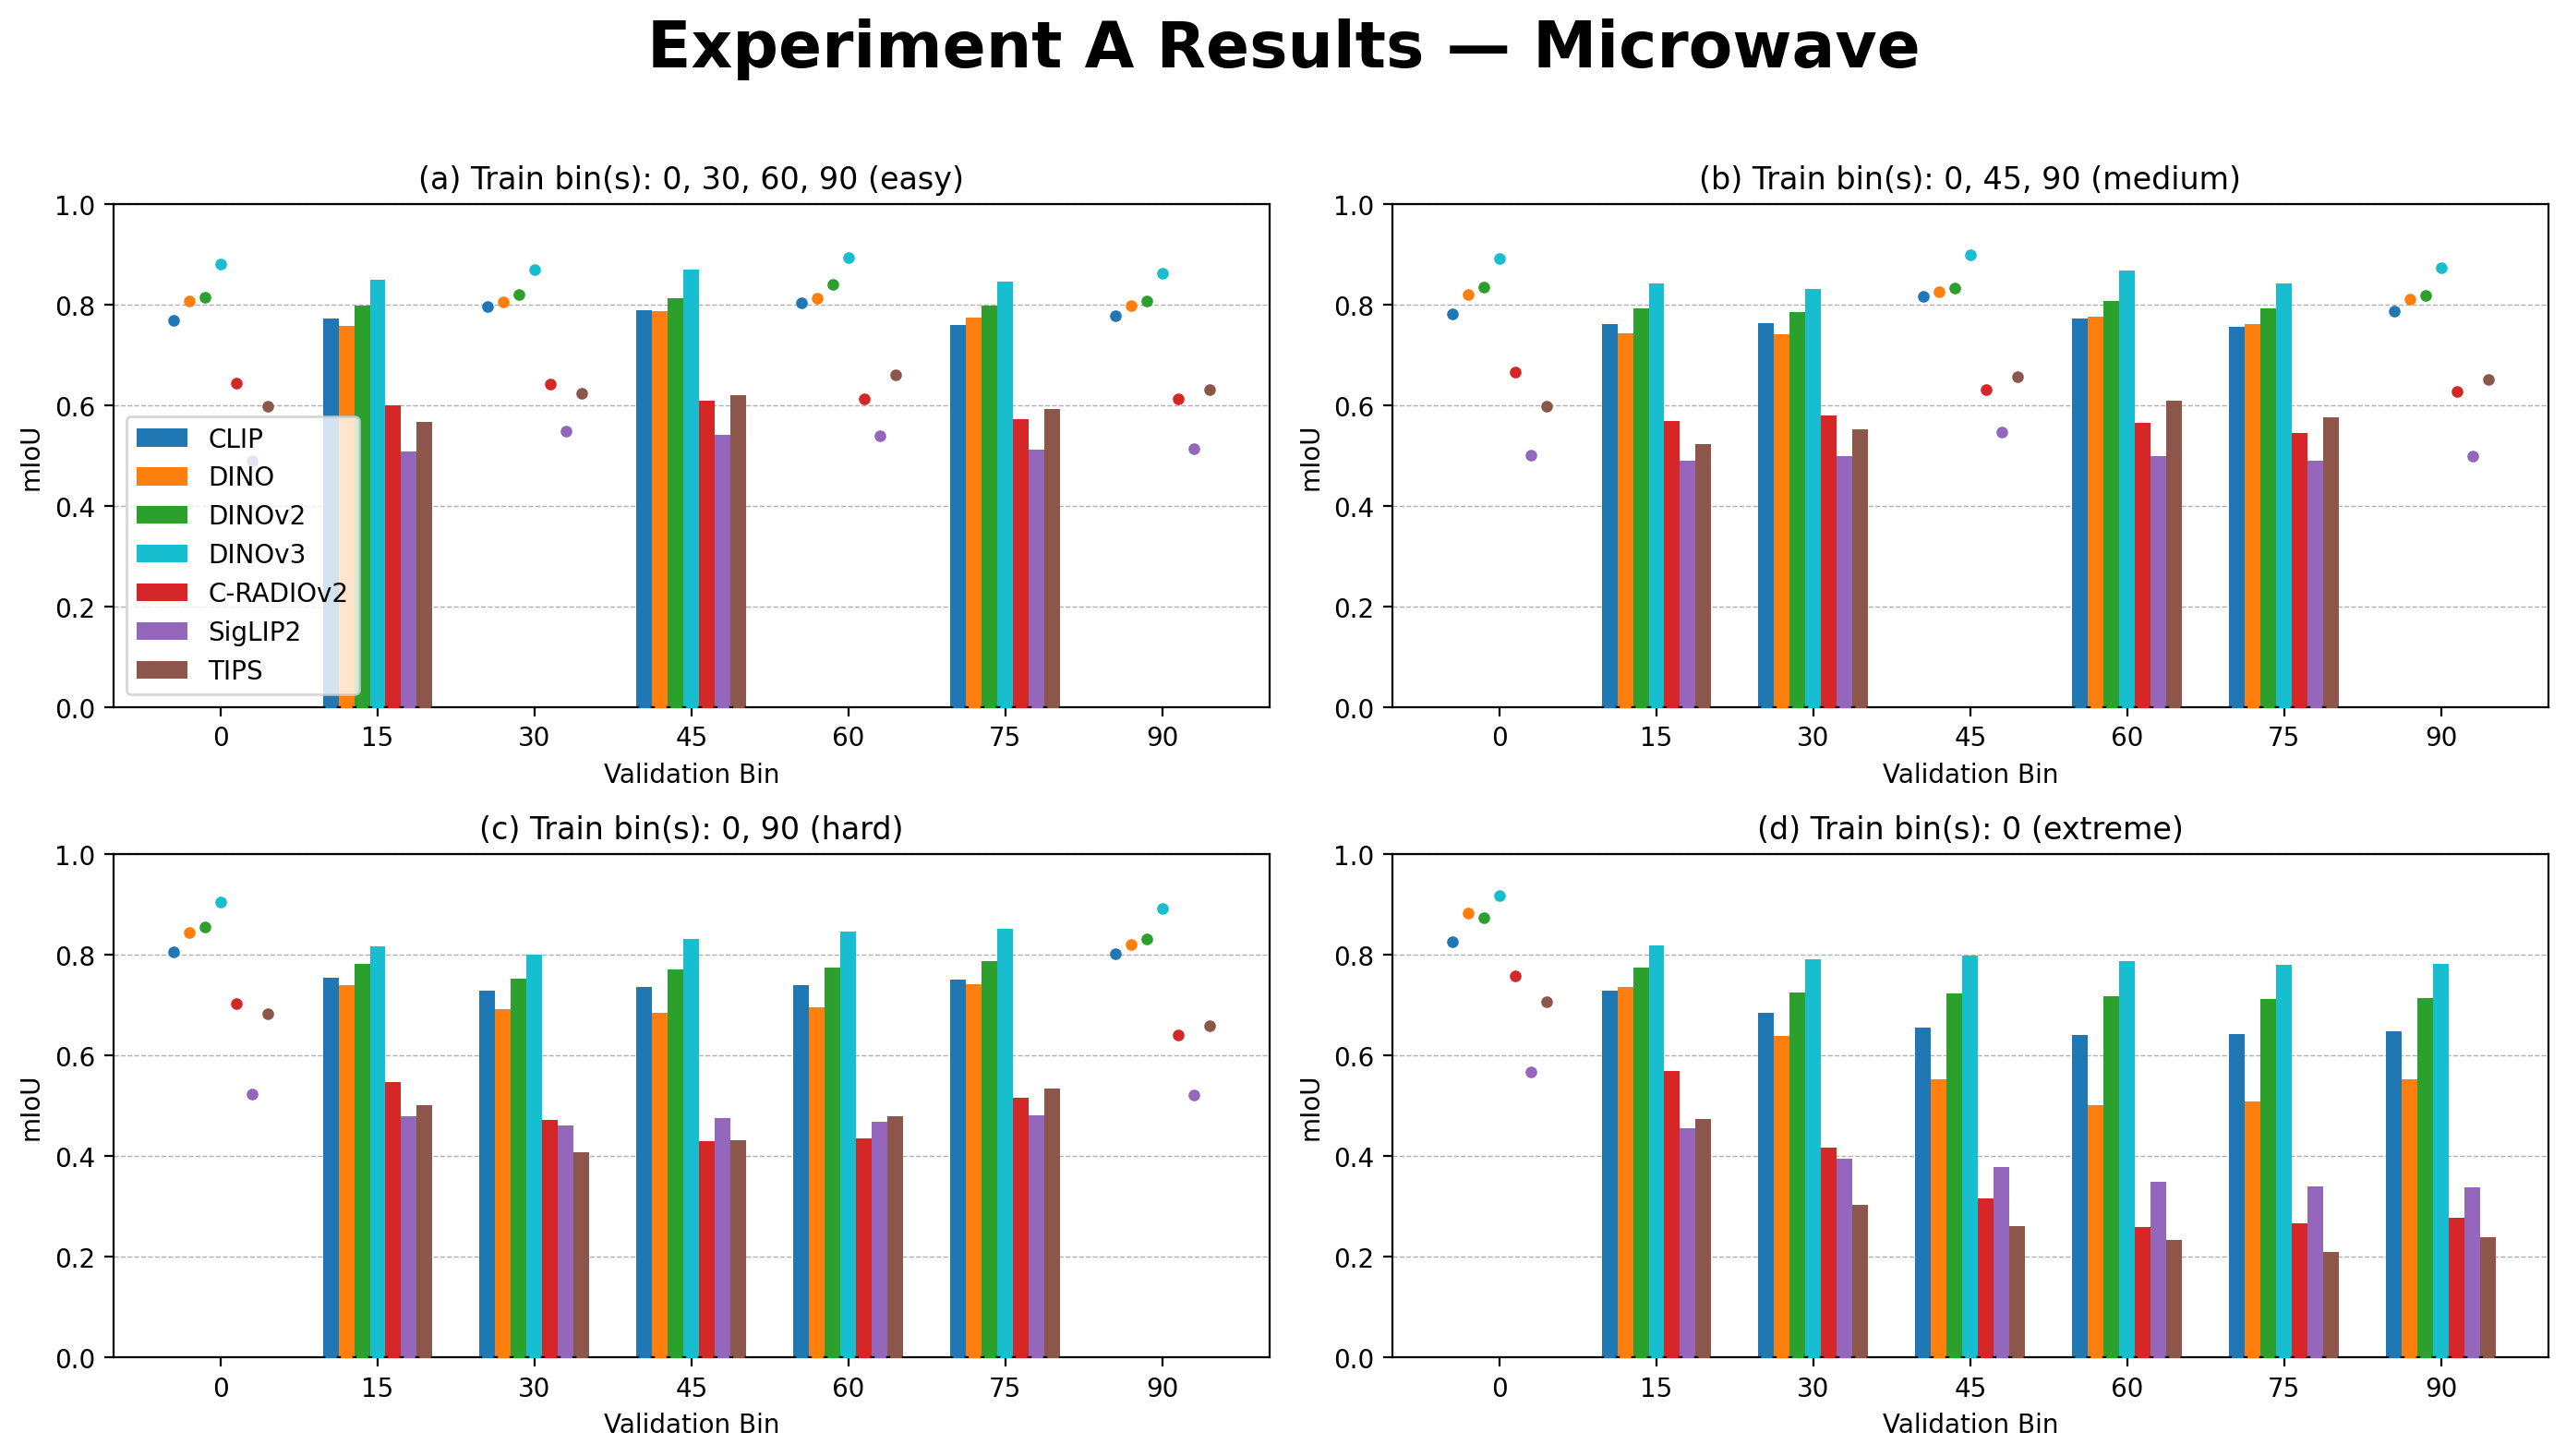

Saved figure to ../images/figures/4_bed.png


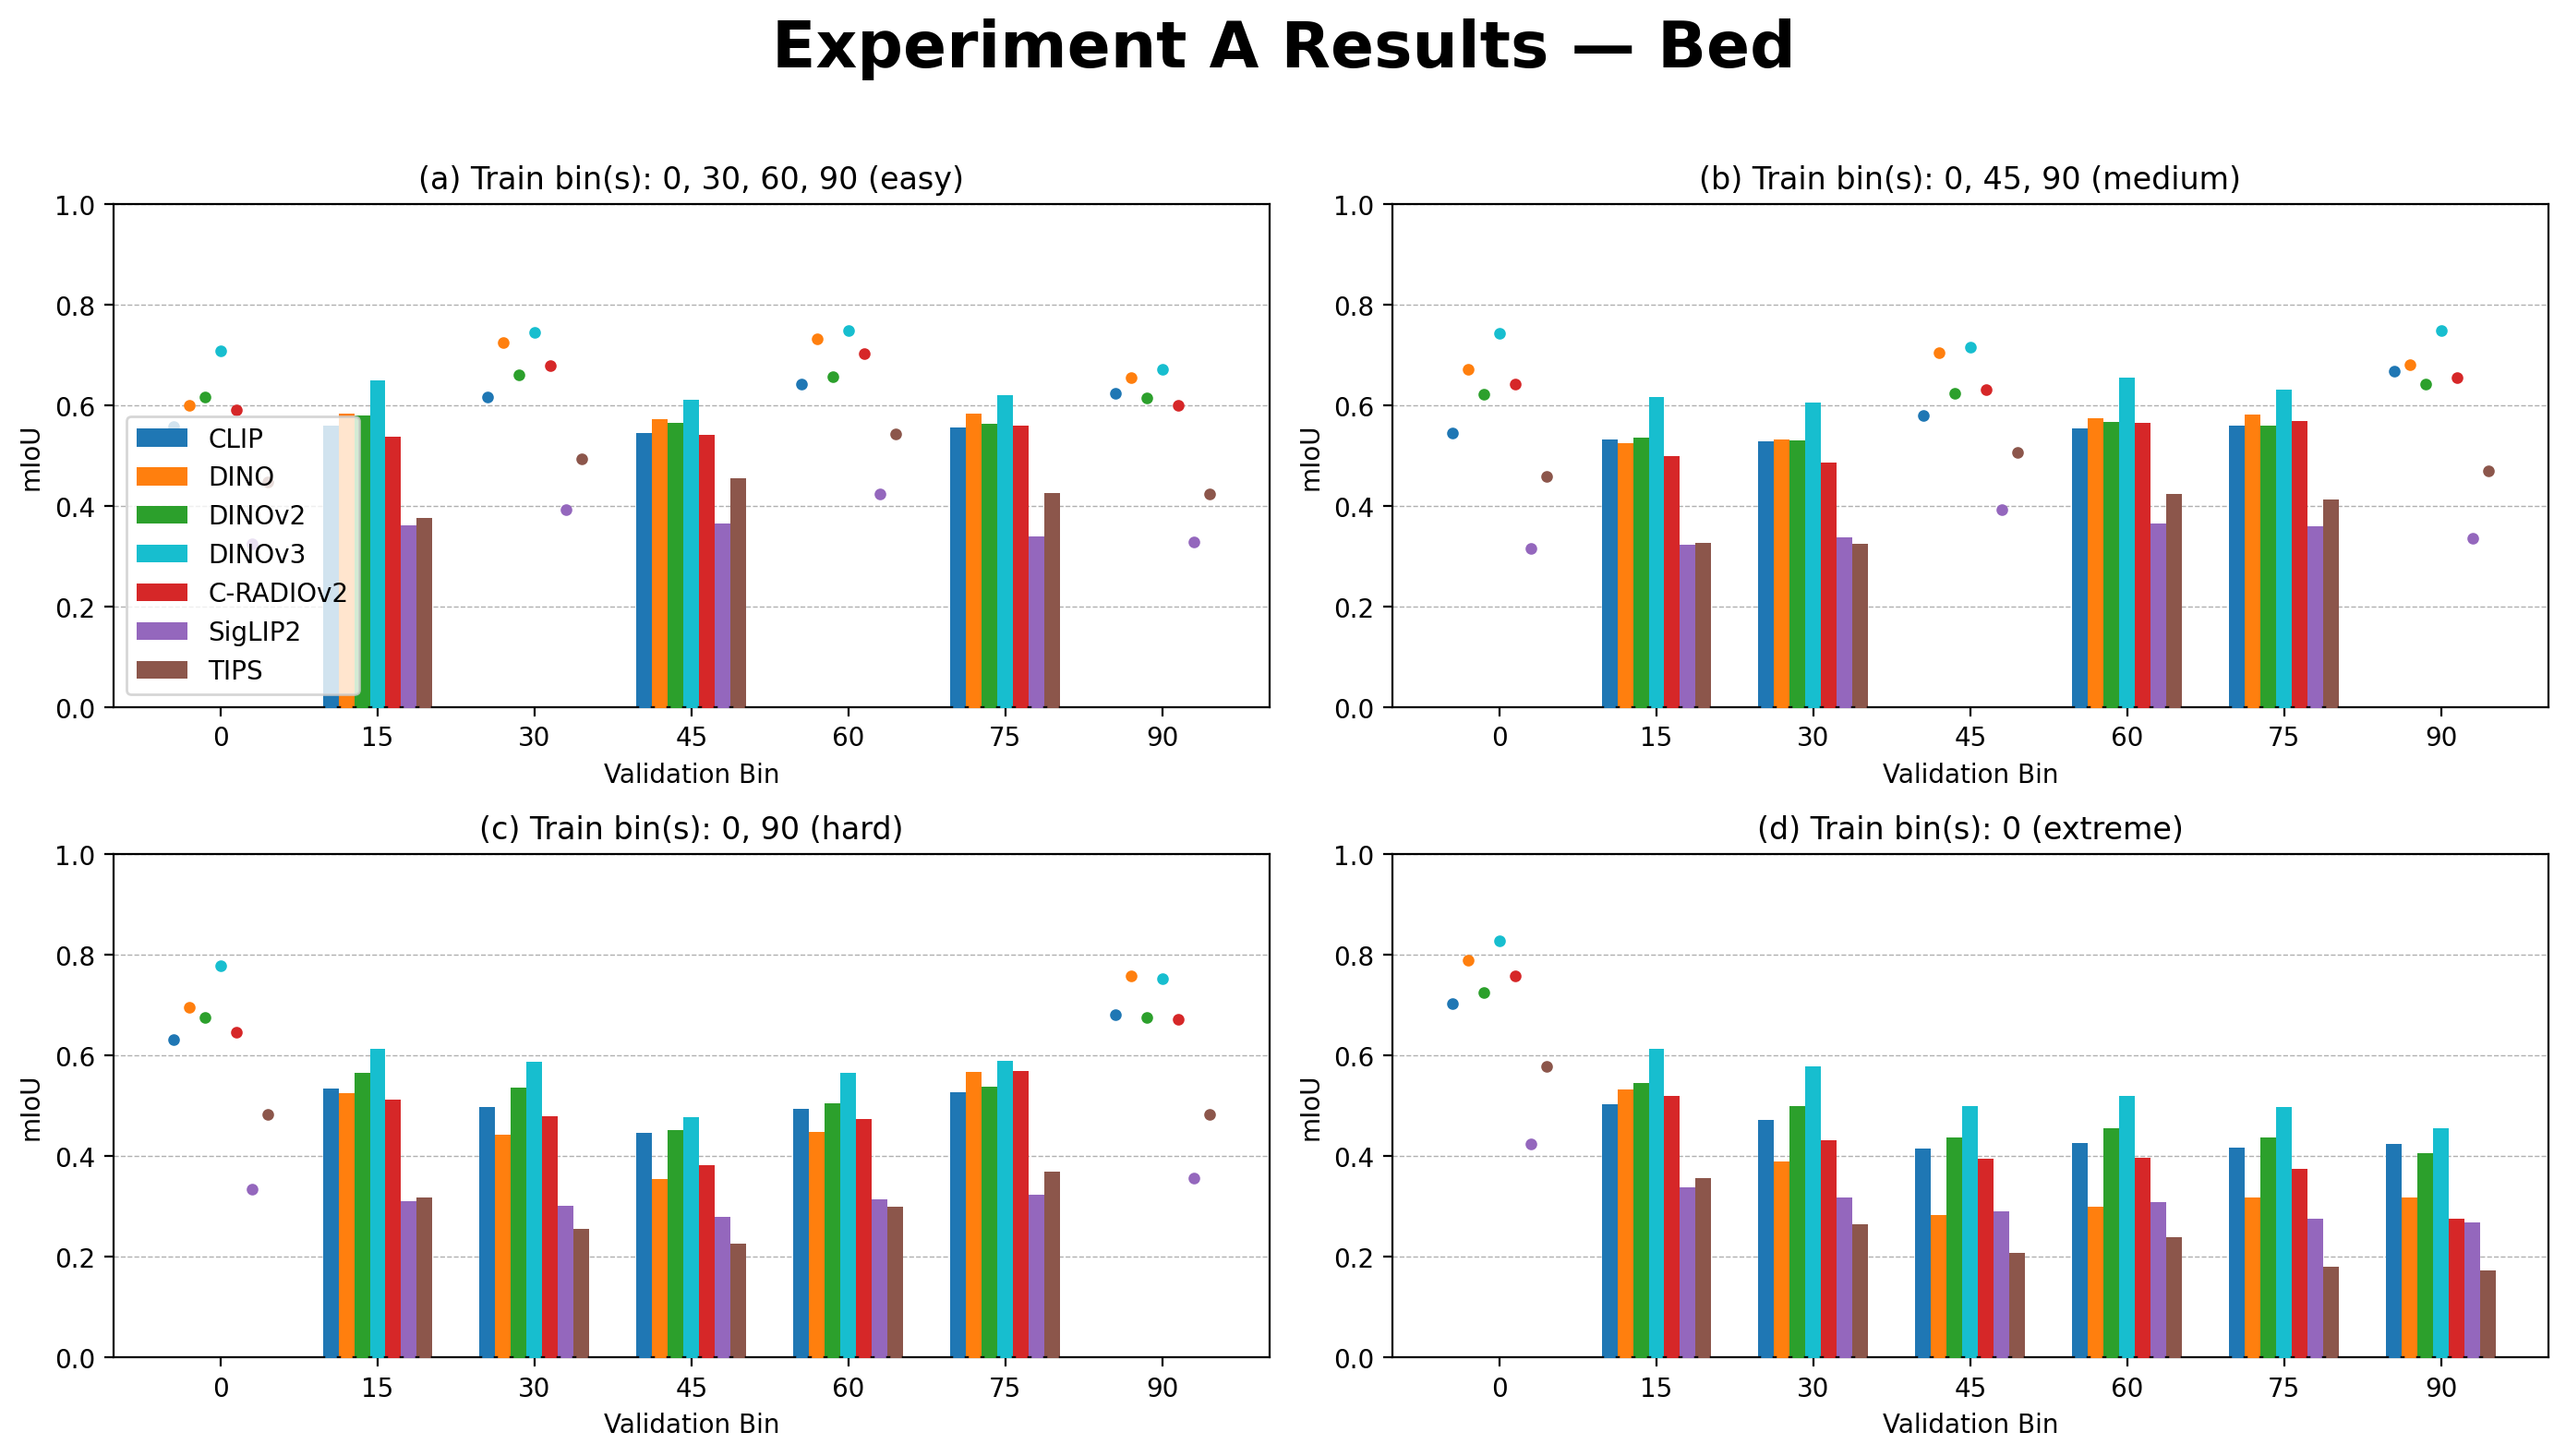

Saved figure to ../images/figures/5_toy_cat.png


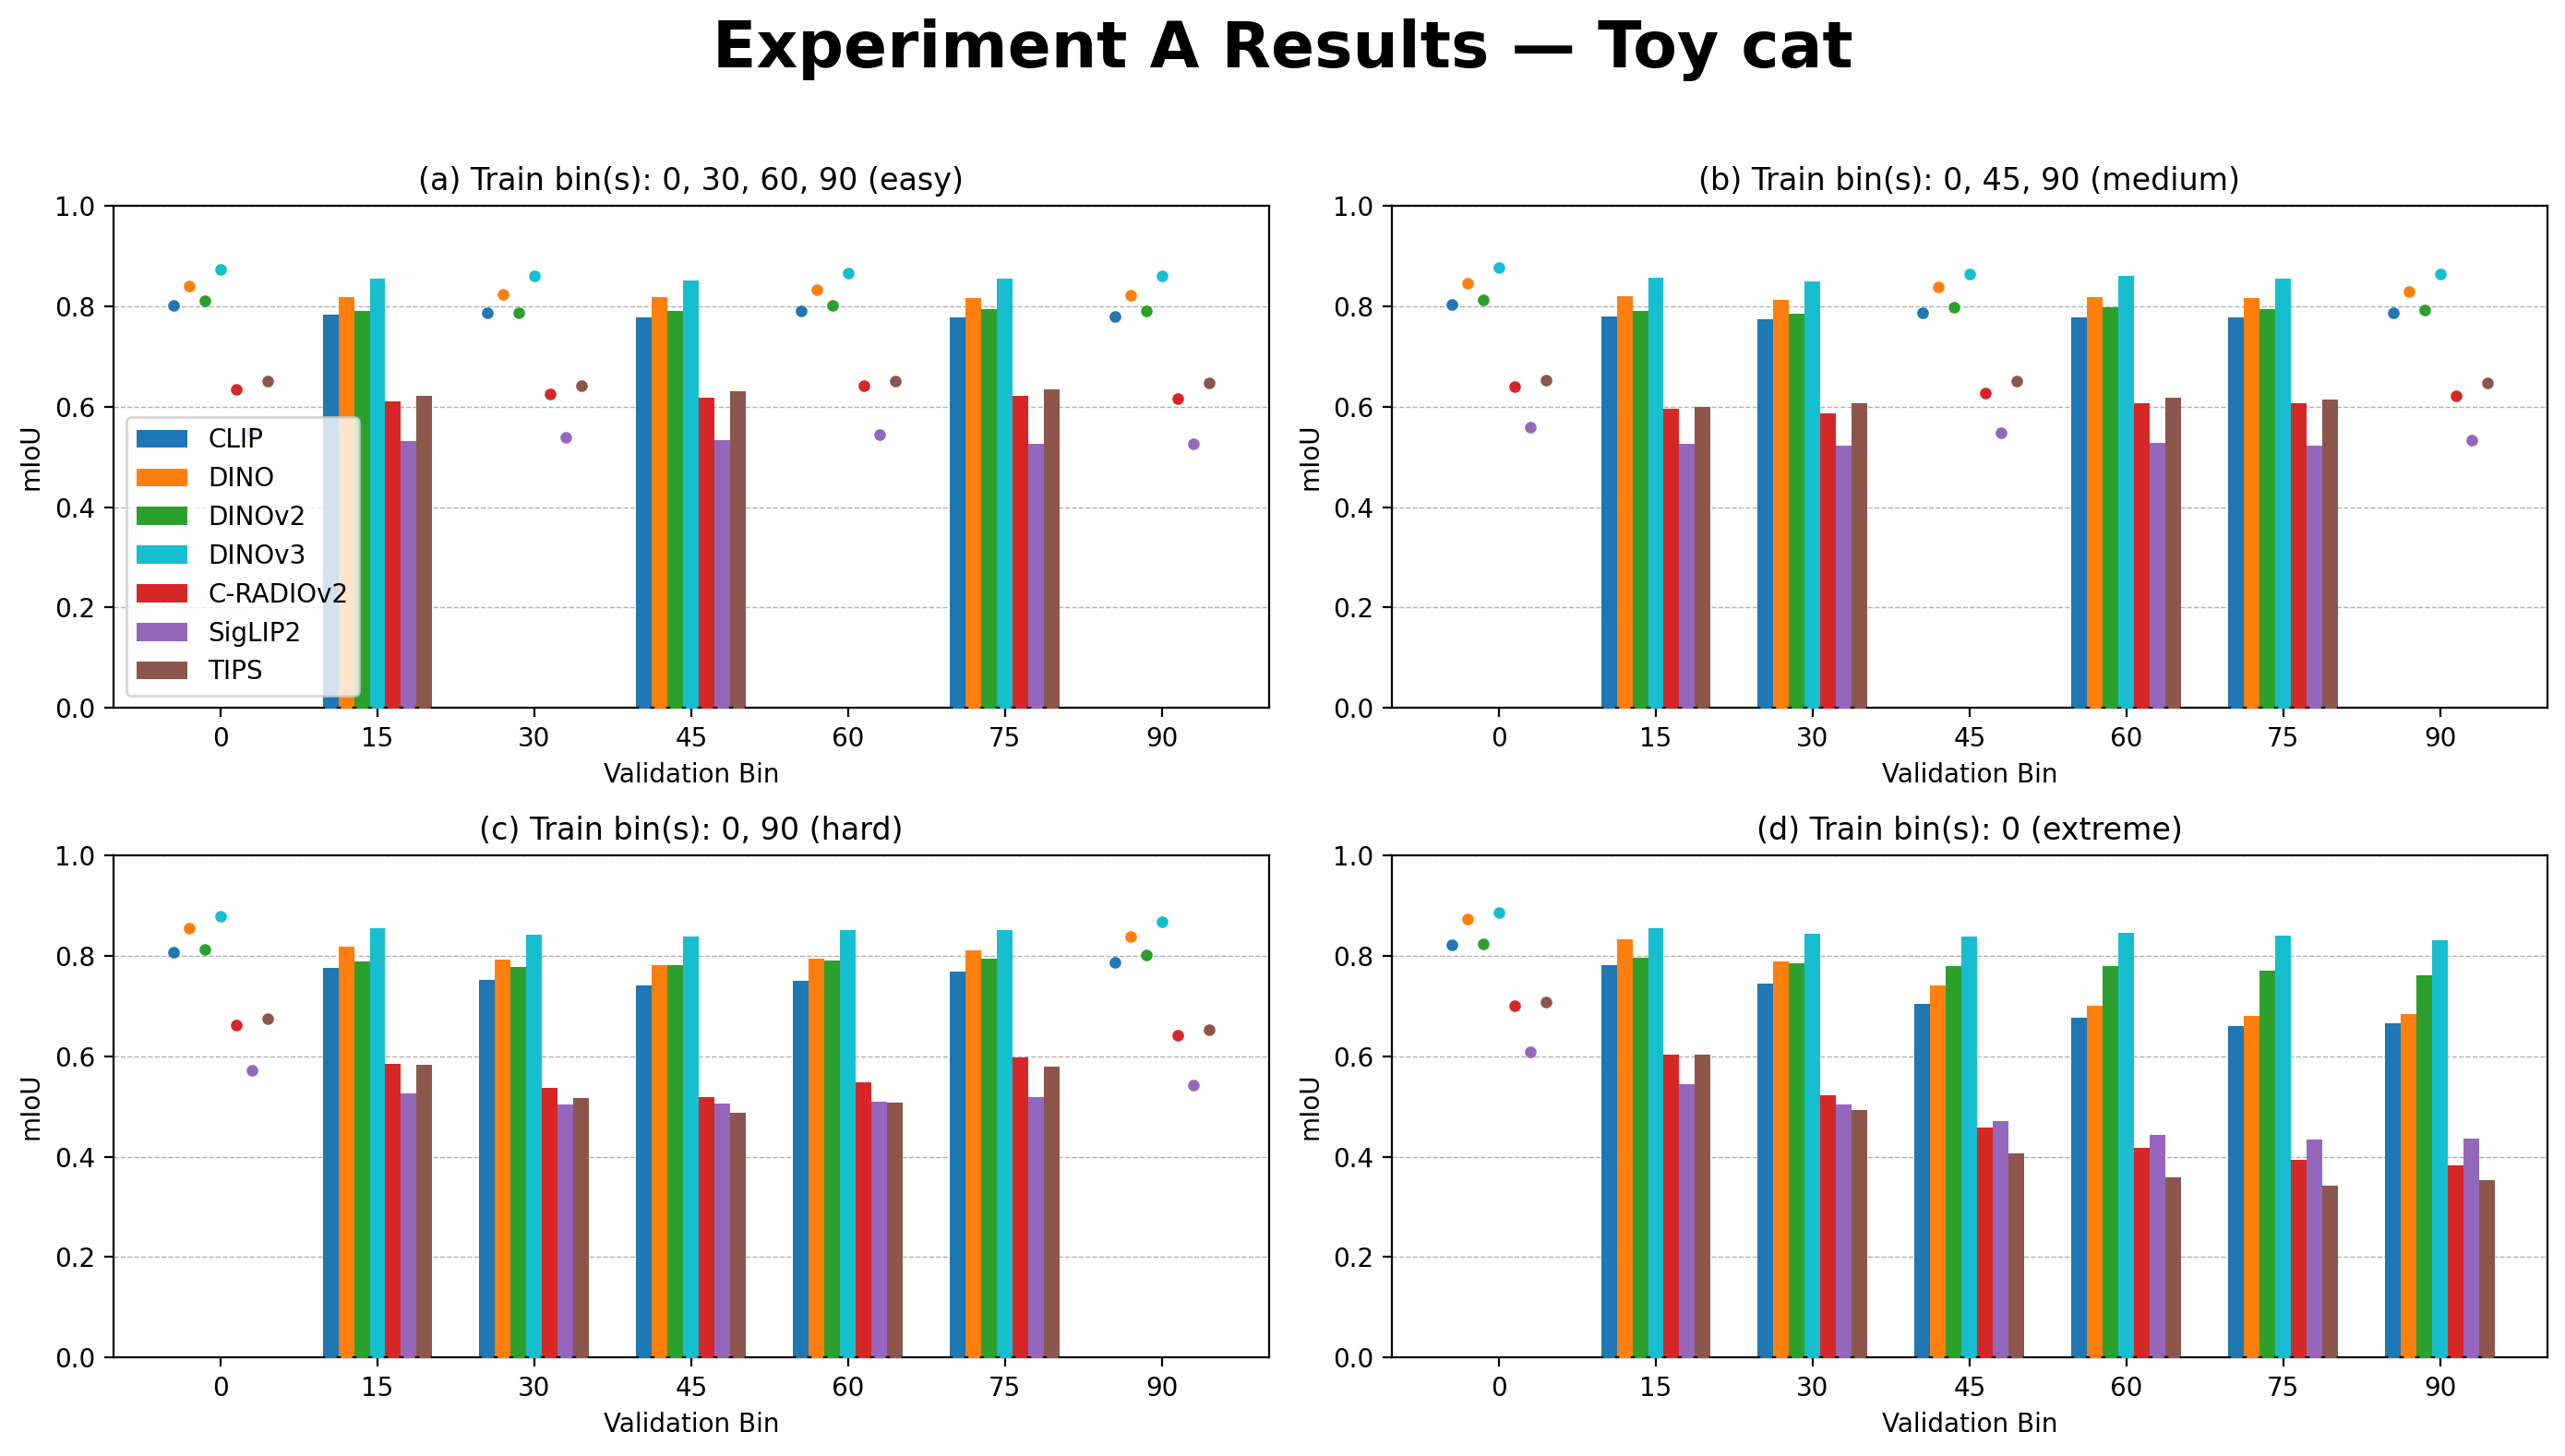

Saved figure to ../images/figures/6_toy_cow.png


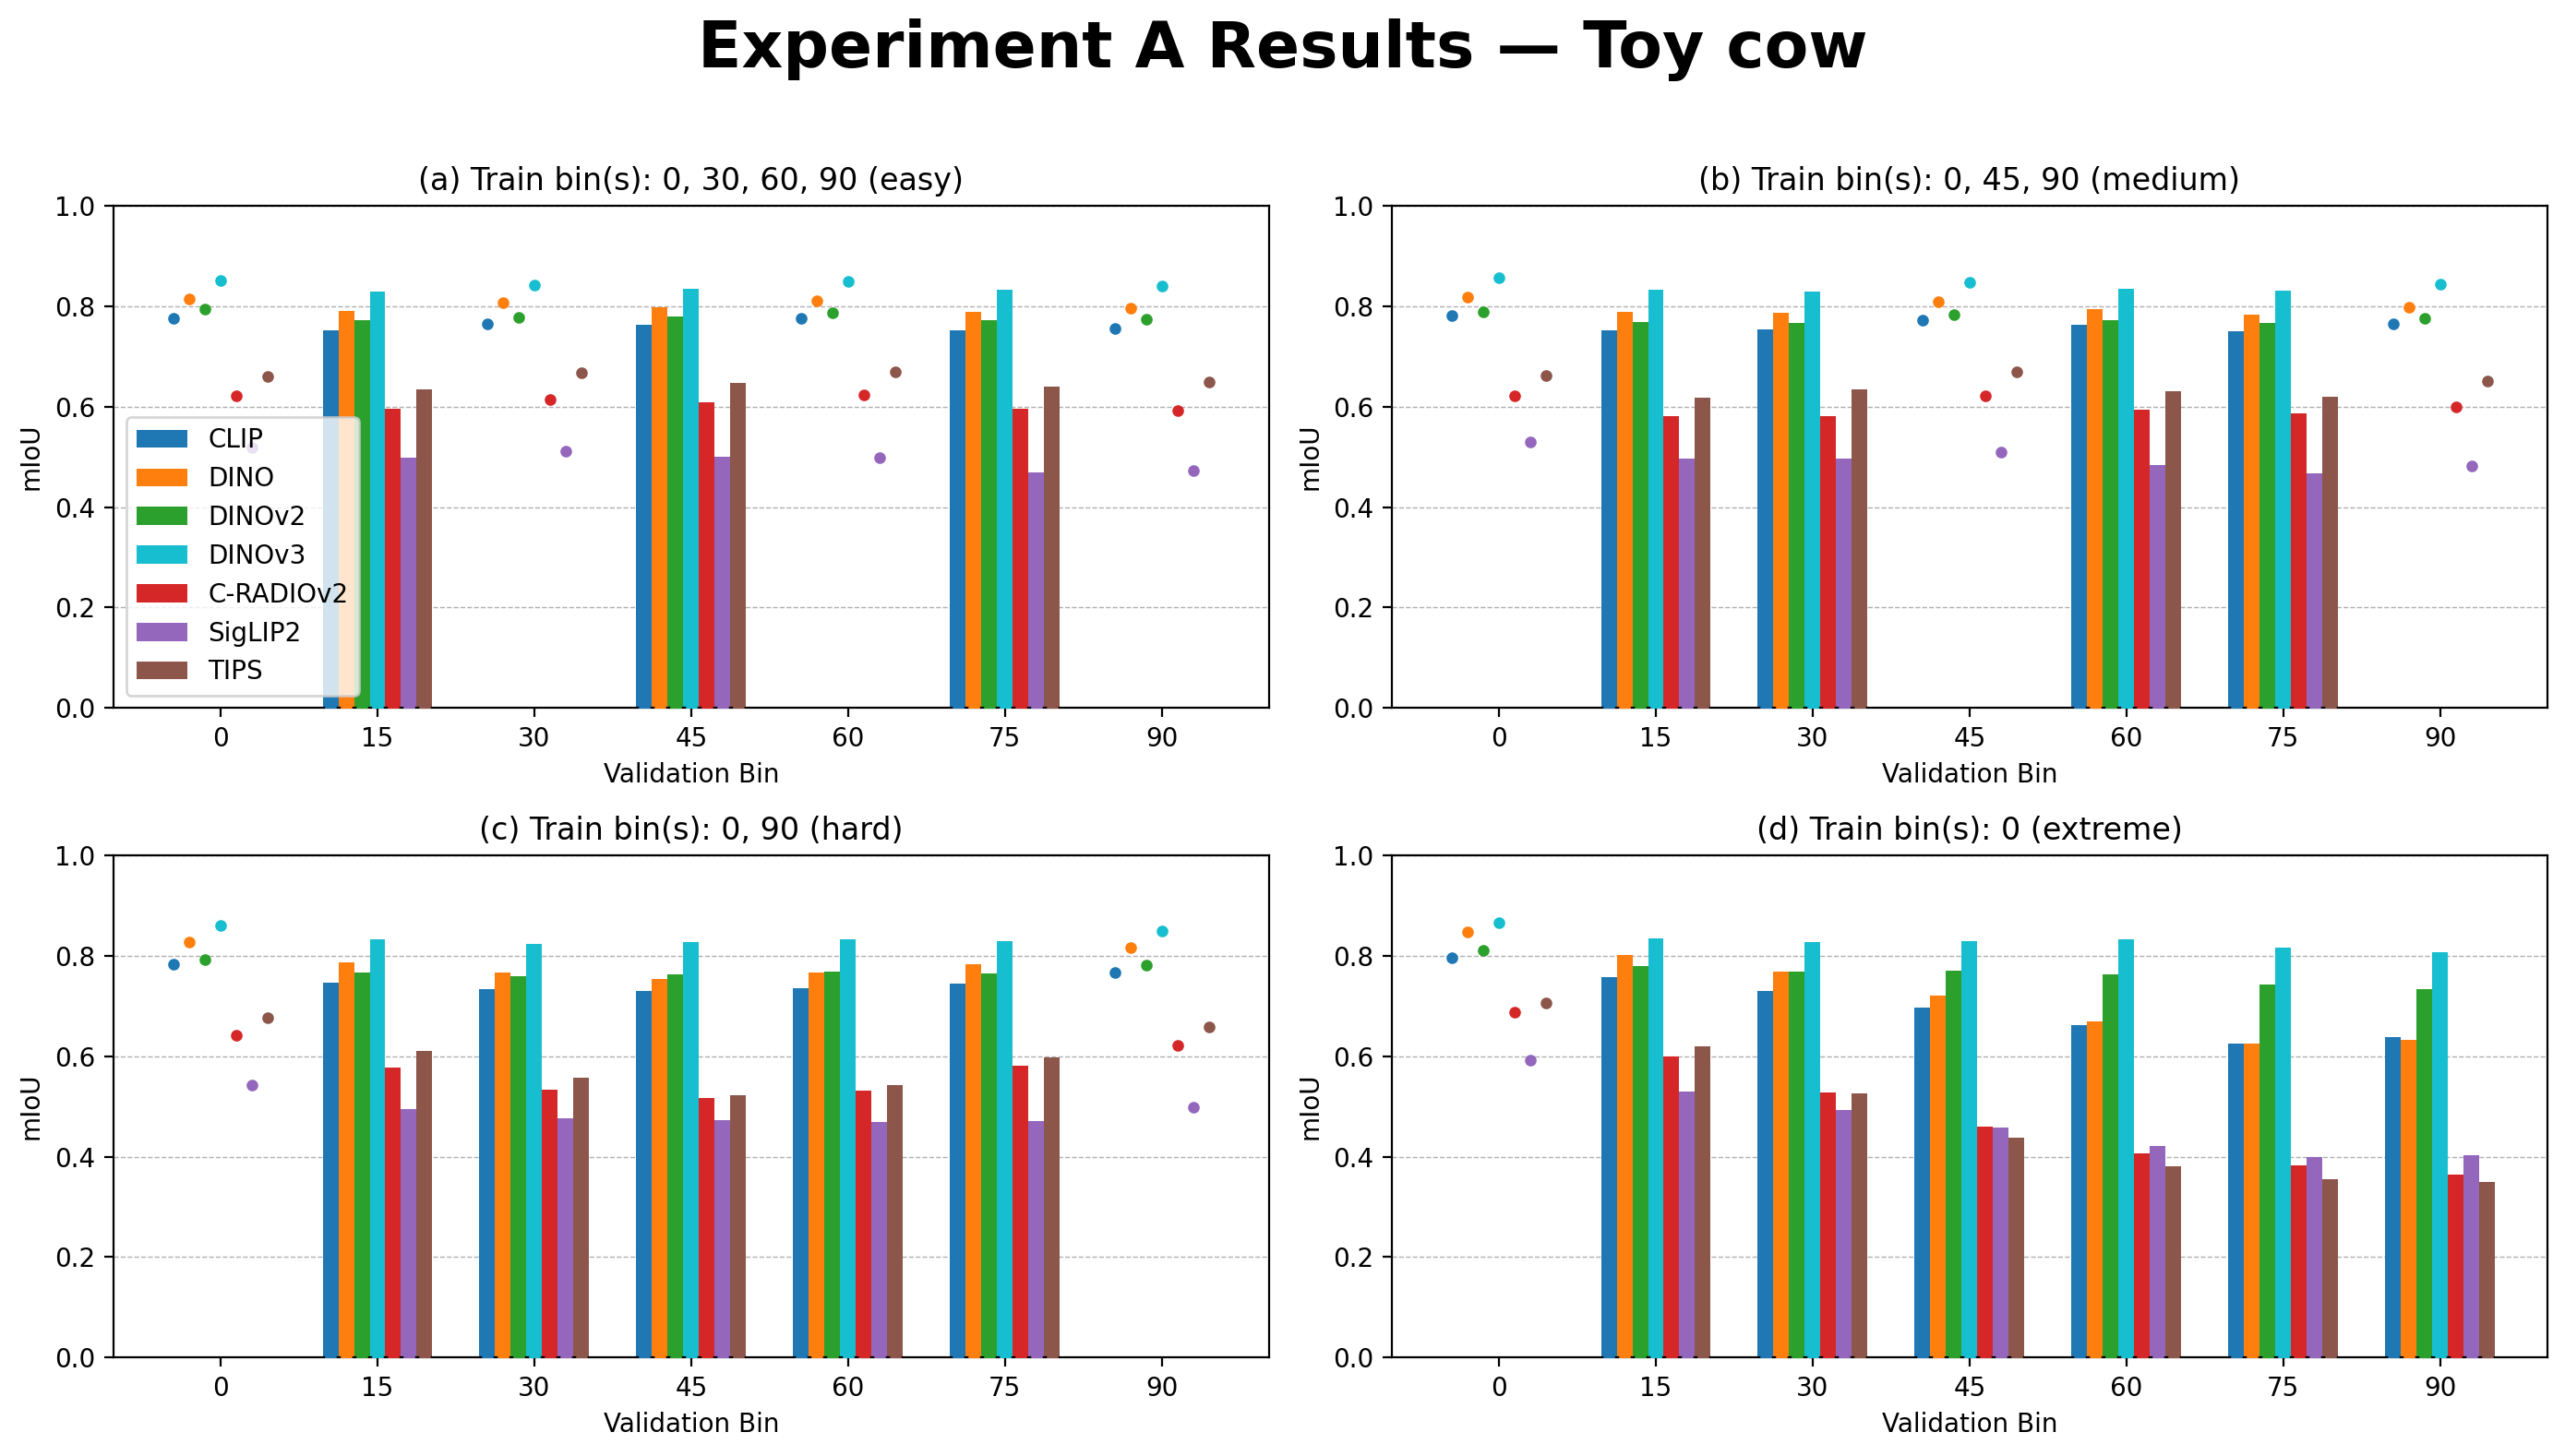

Saved figure to ../images/figures/7_toy_dragon.png


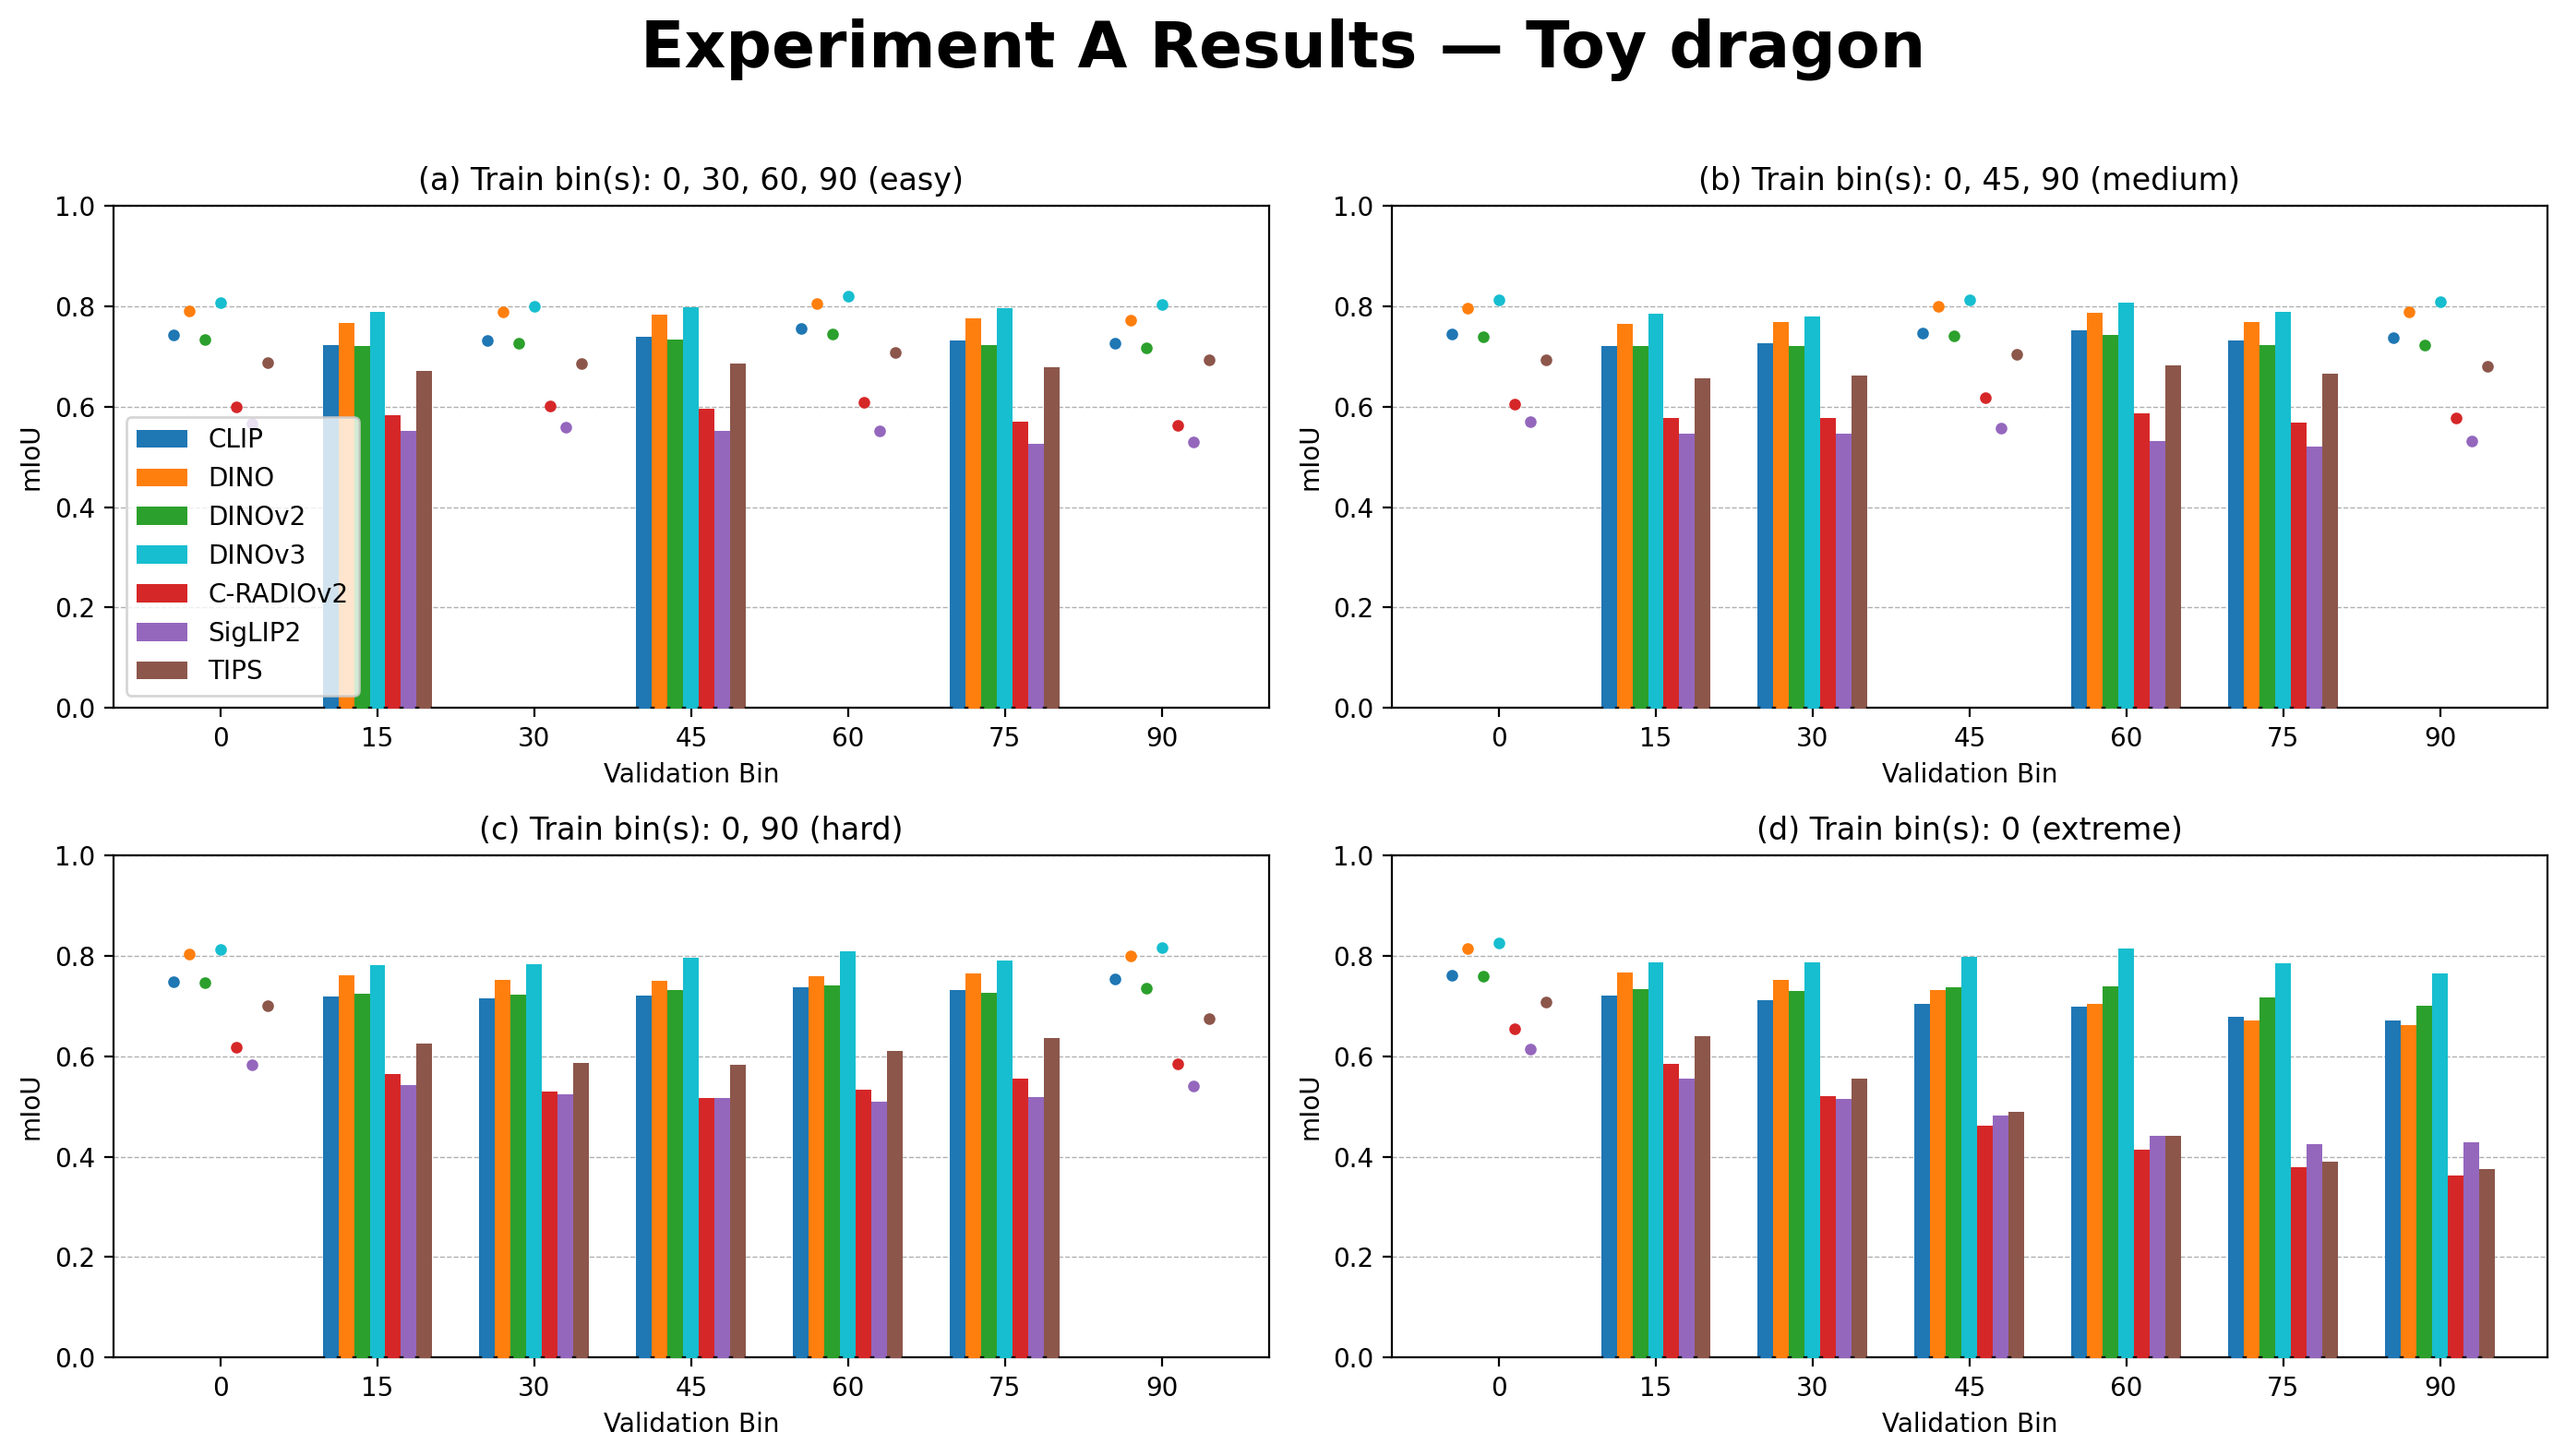

Saved figure to ../images/figures/8_coat_rack.png


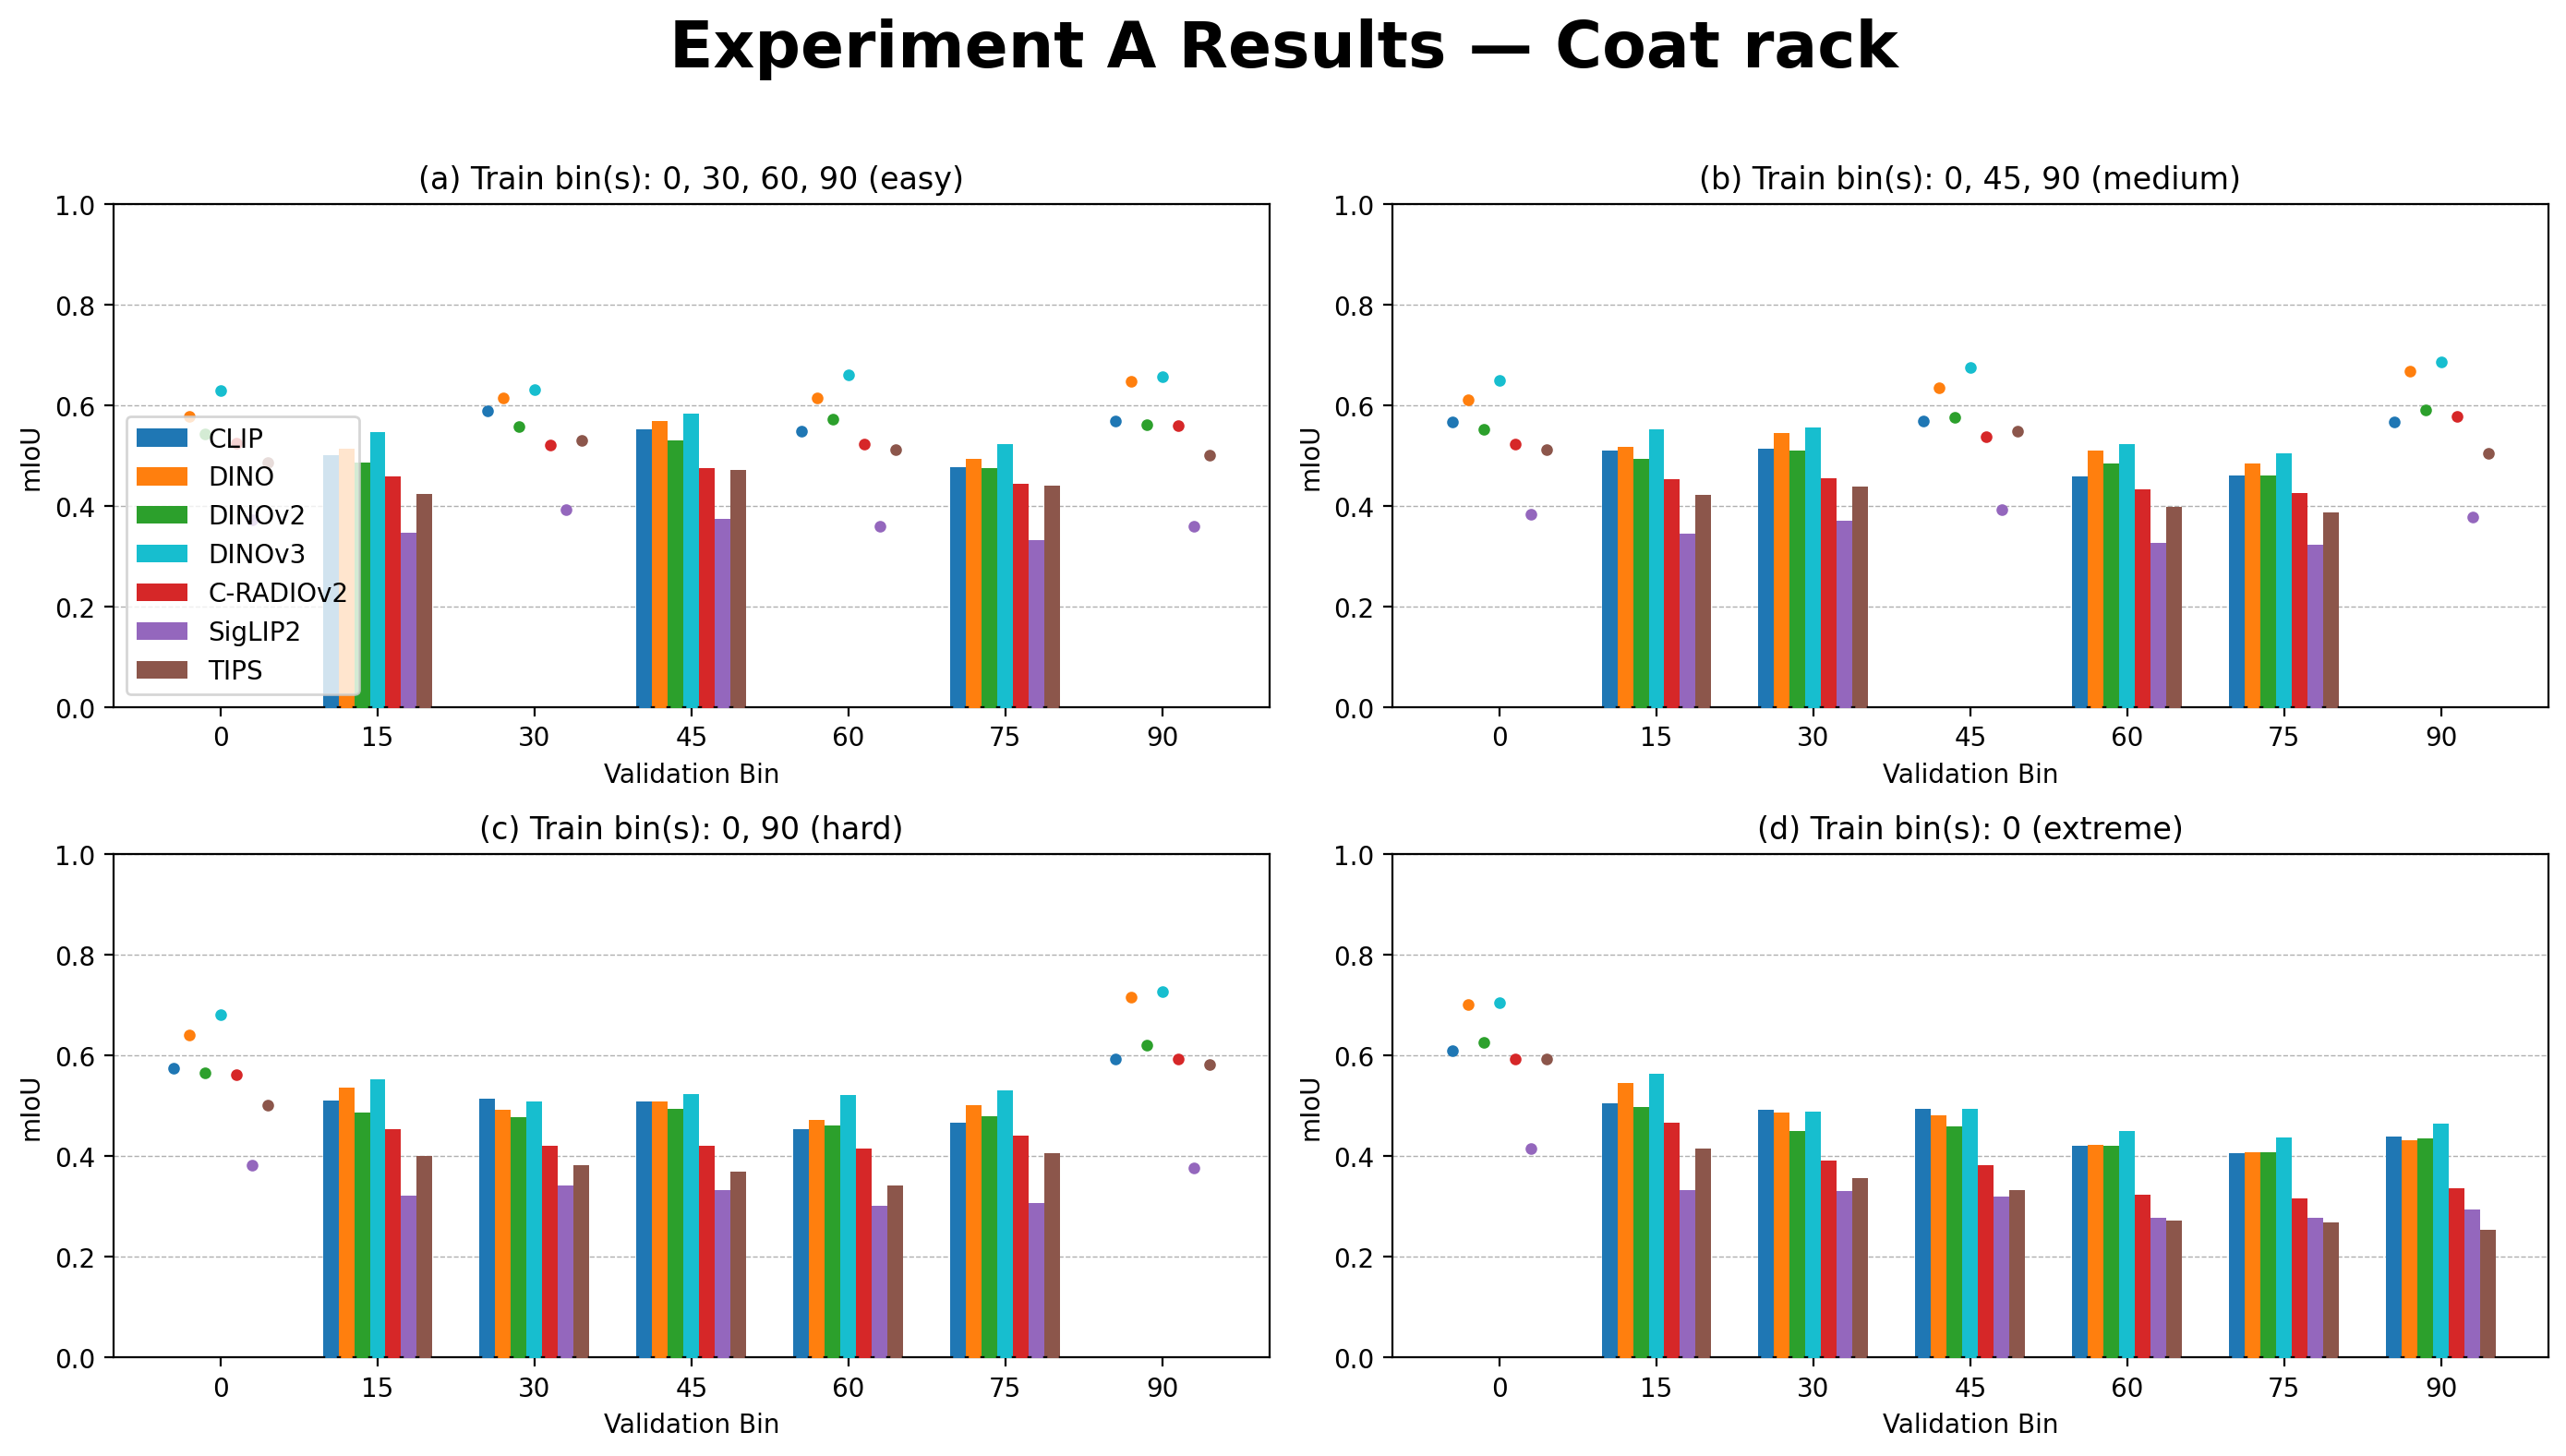

Saved figure to ../images/figures/9_guitar_stand.png


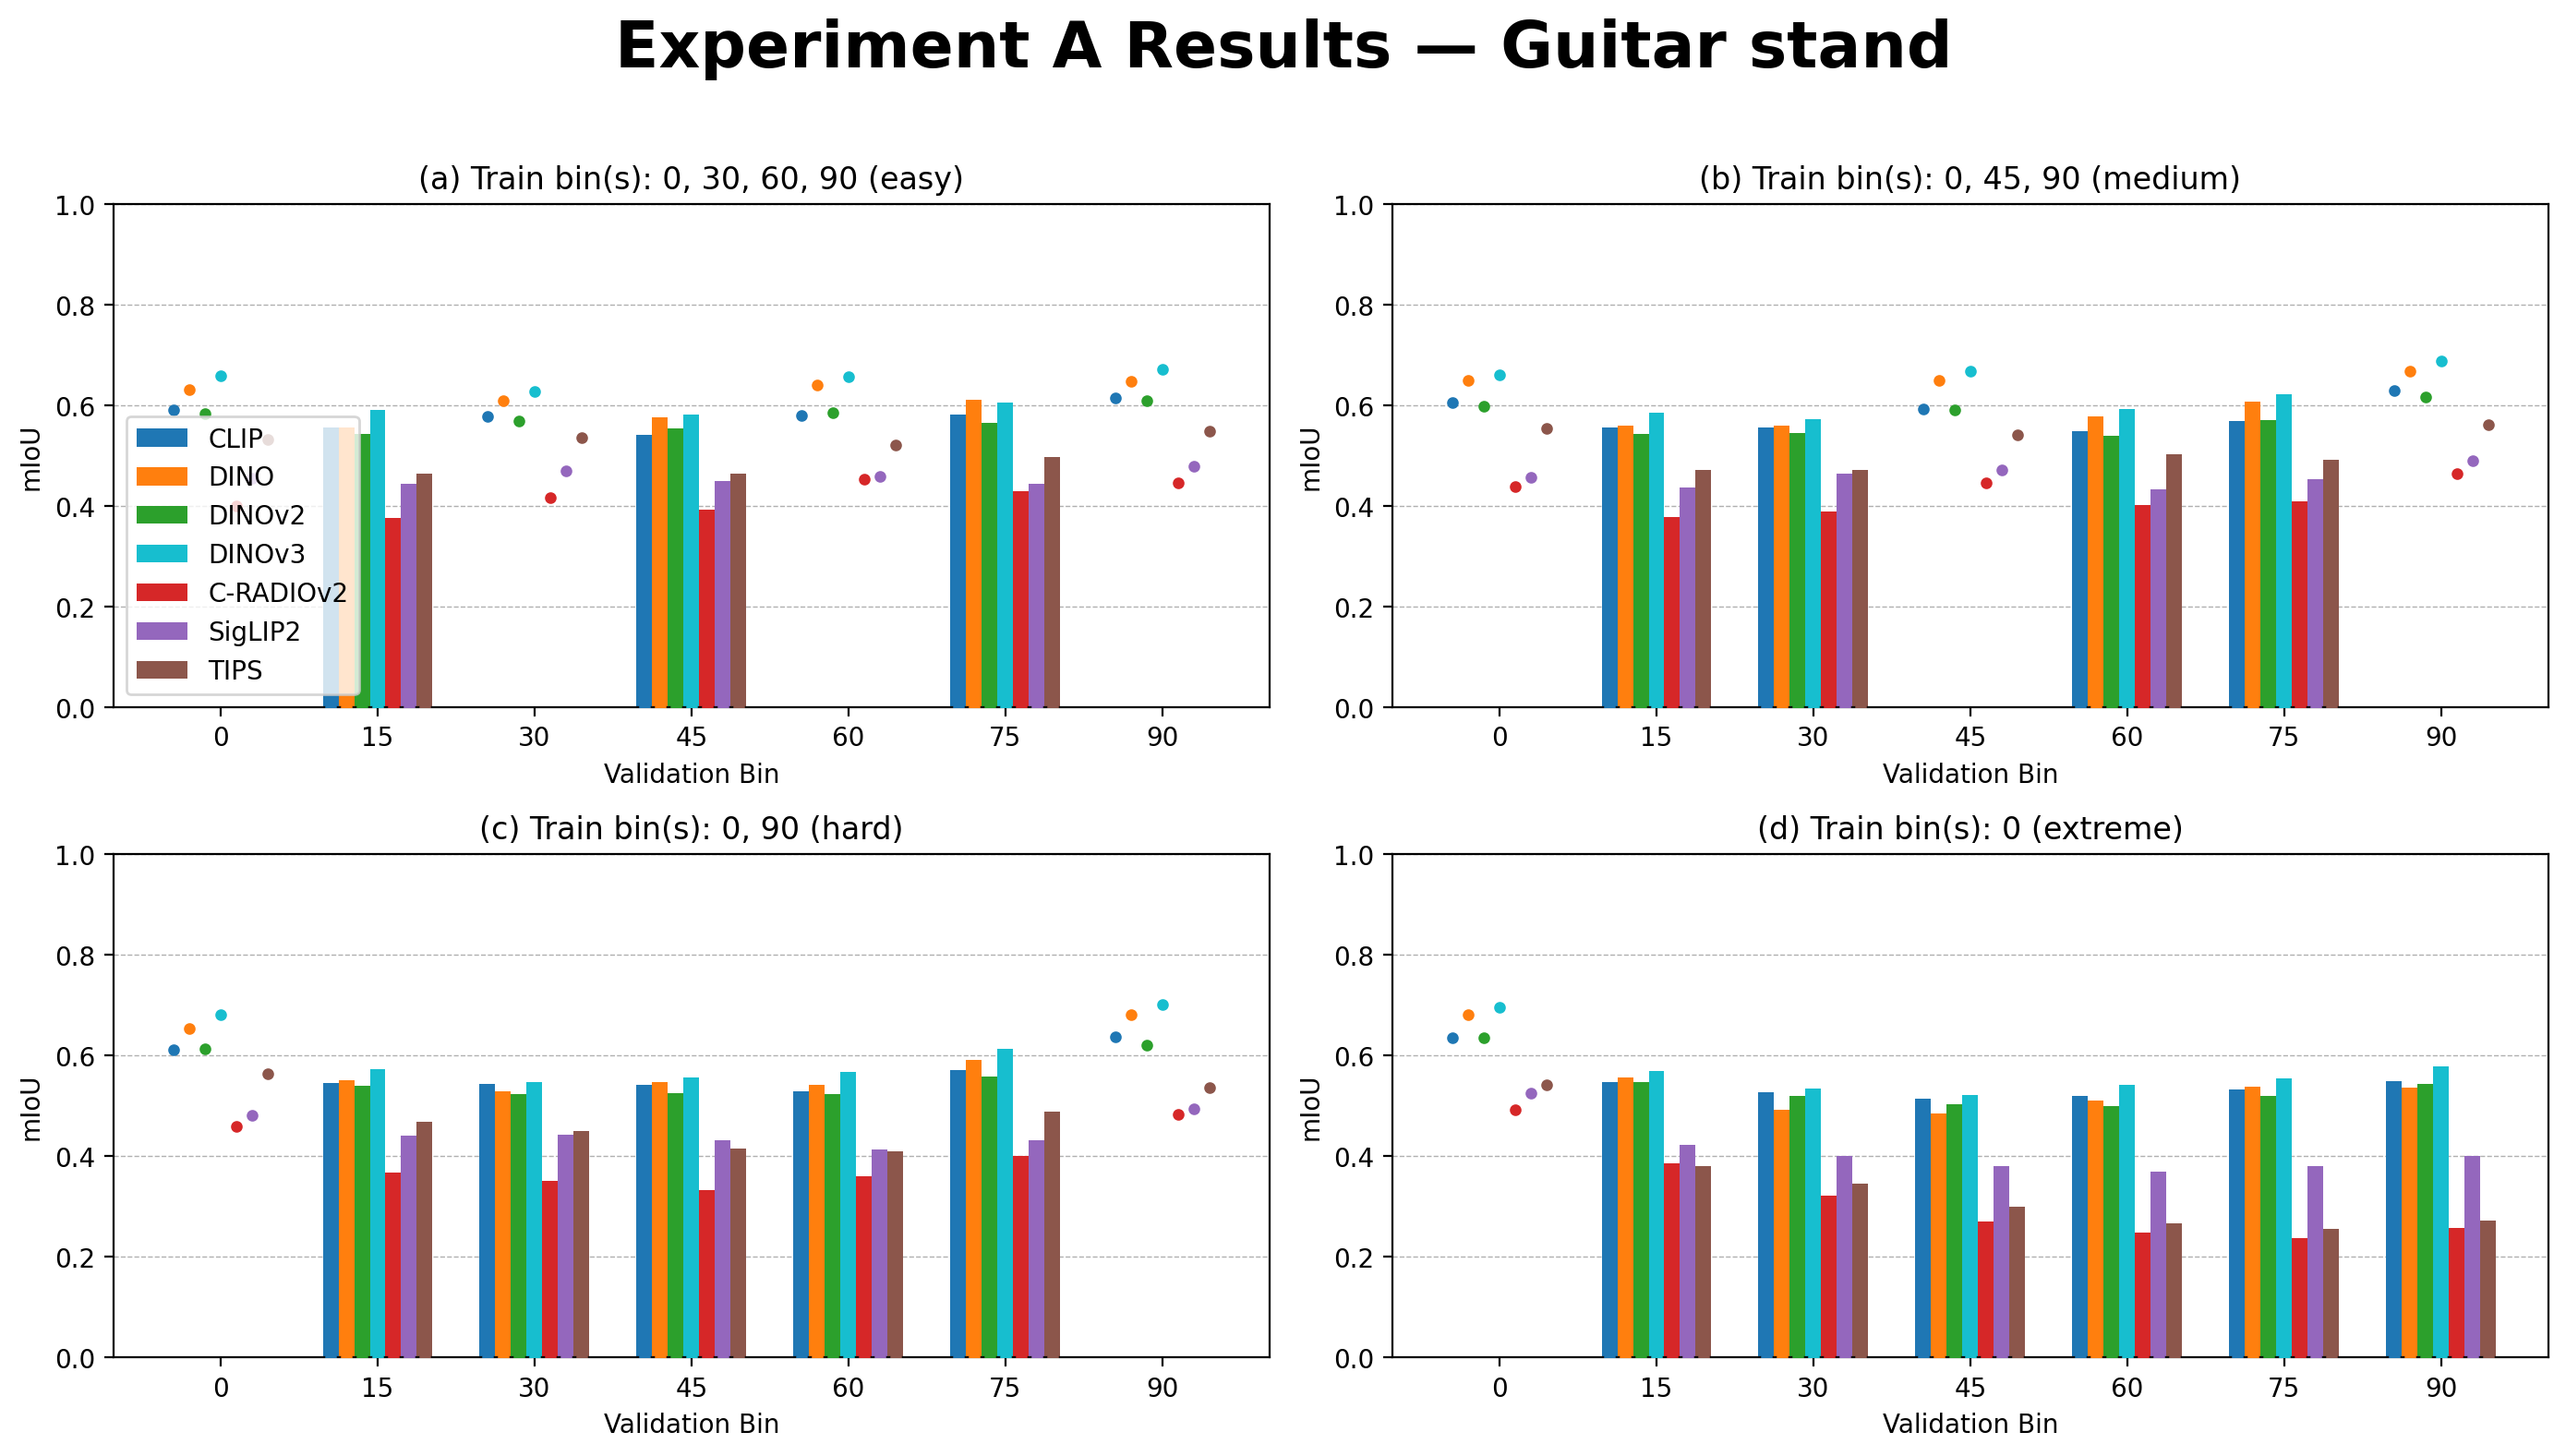

Saved figure to ../images/figures/10_ceiling_lamp.png


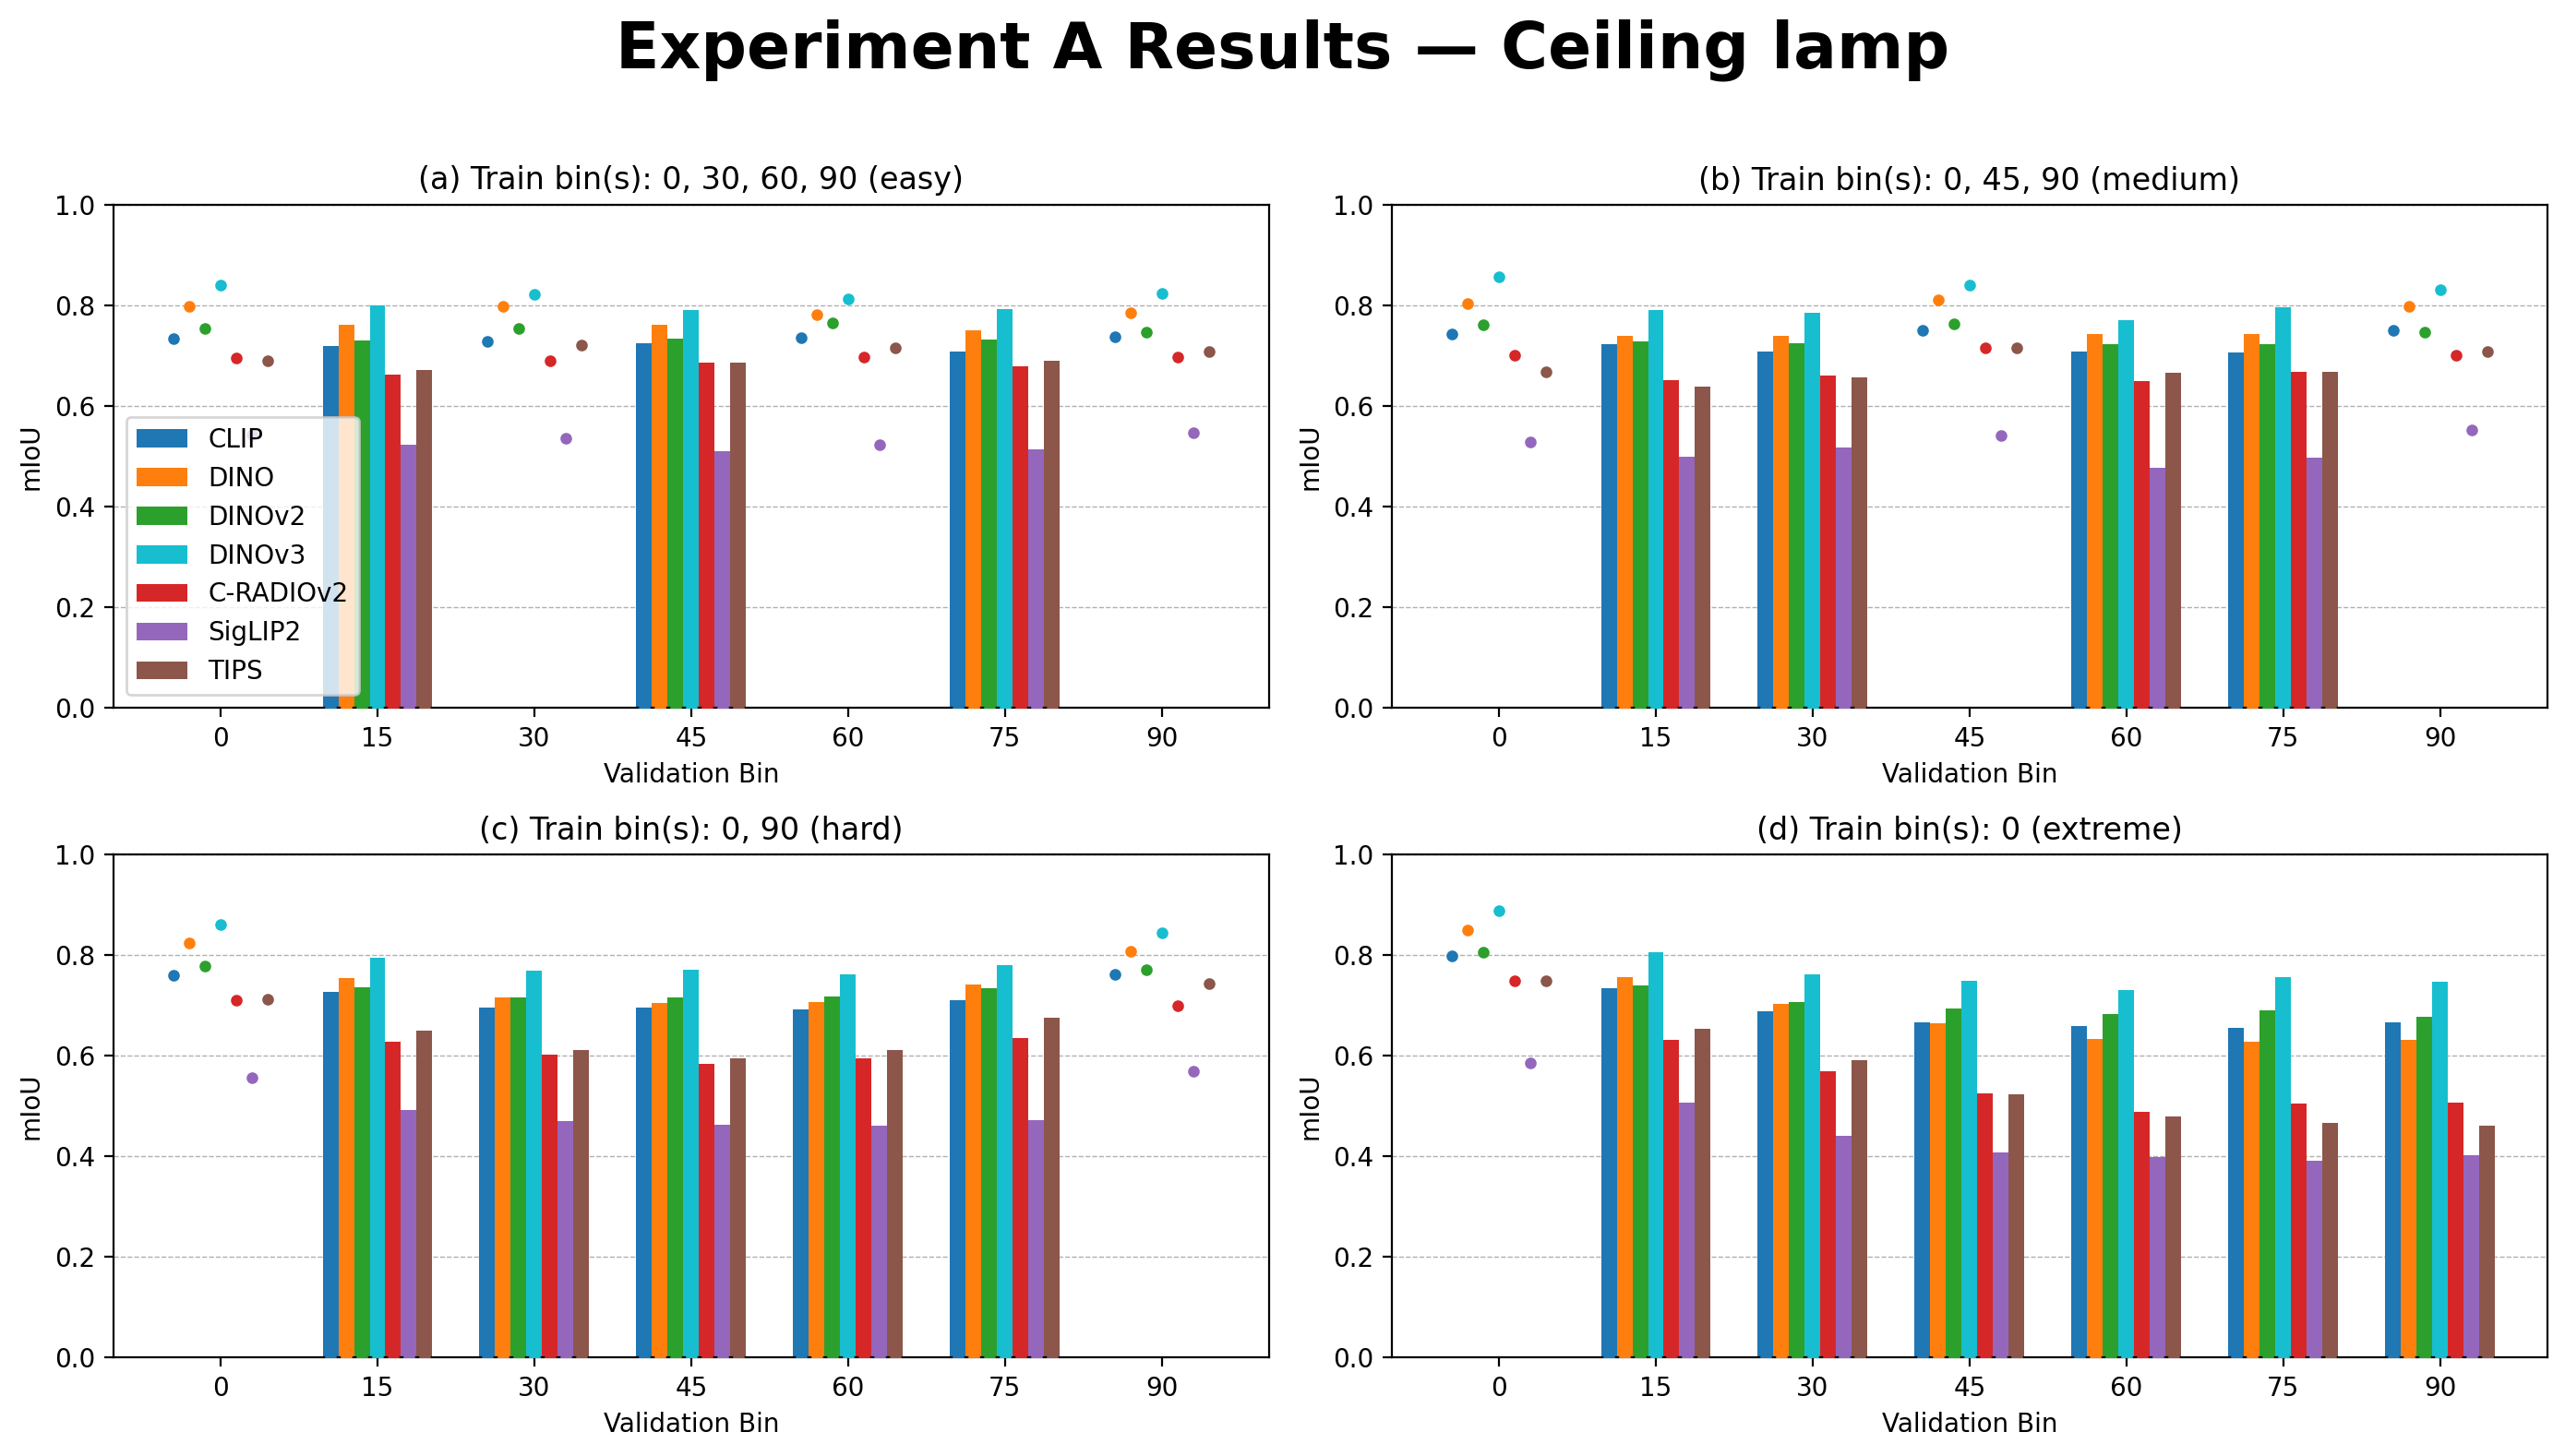

Saved figure to ../images/figures/11_toilet.png


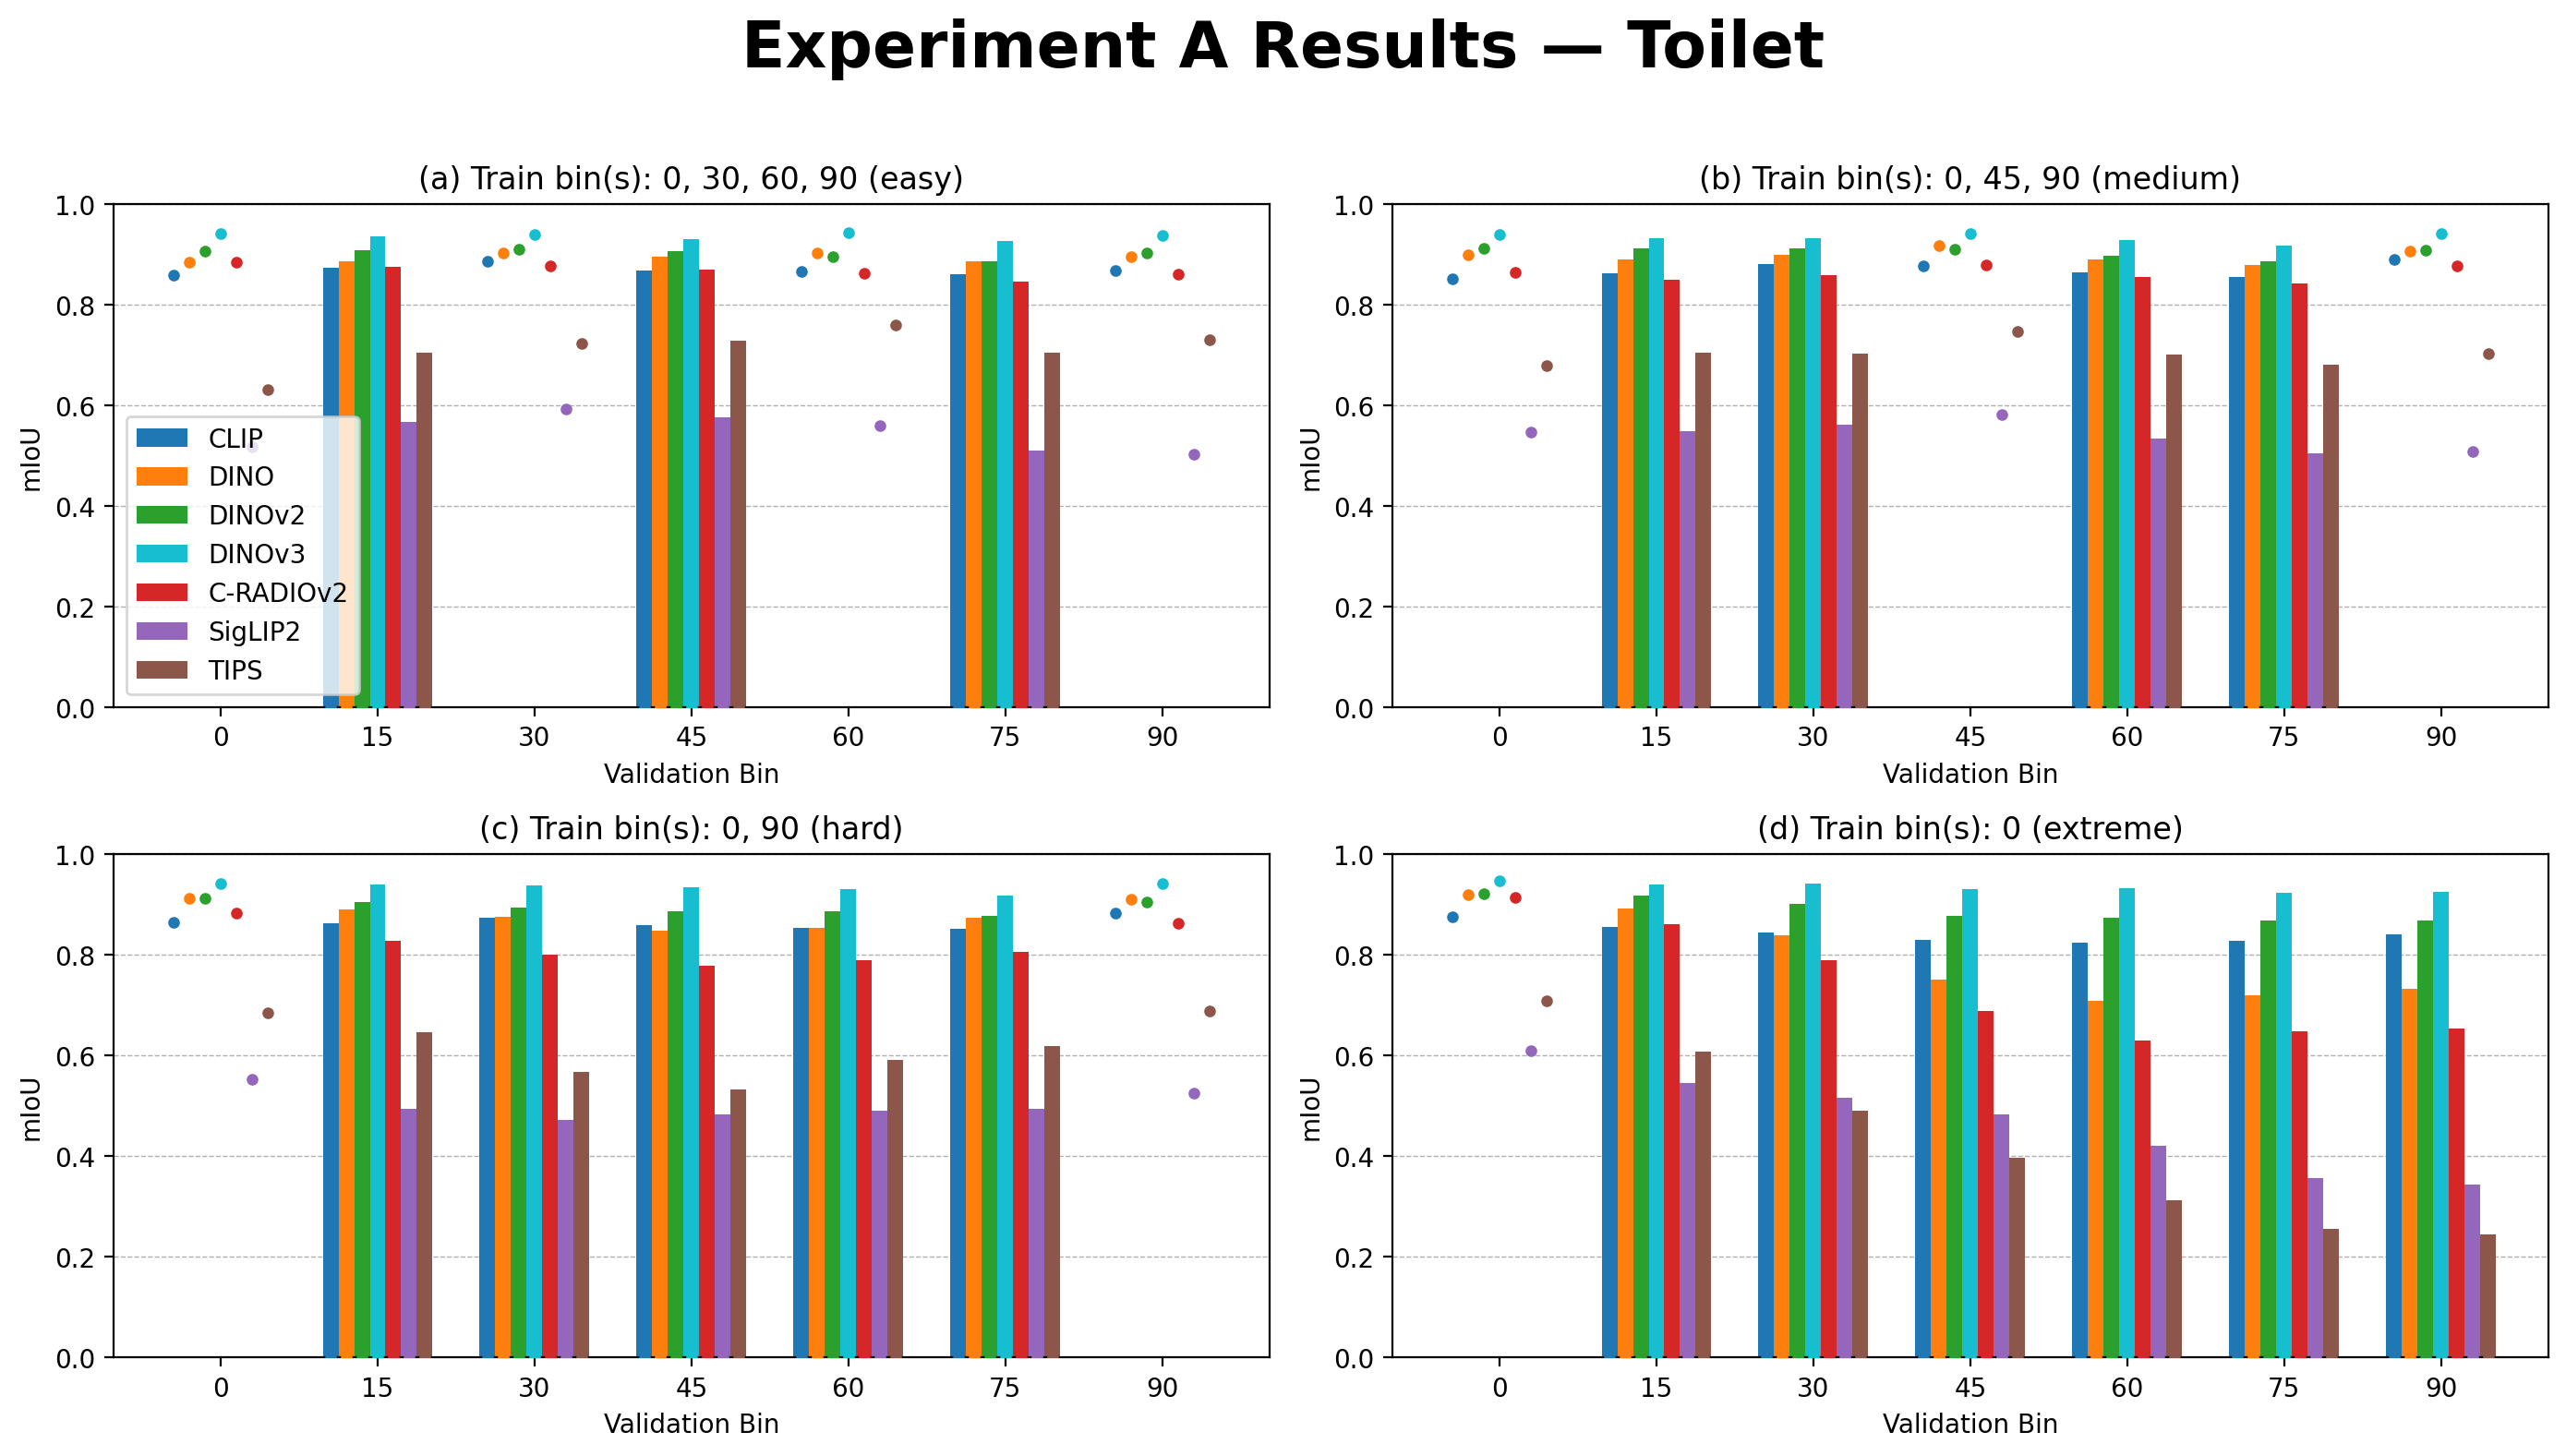

Saved figure to ../images/figures/12_sink.png


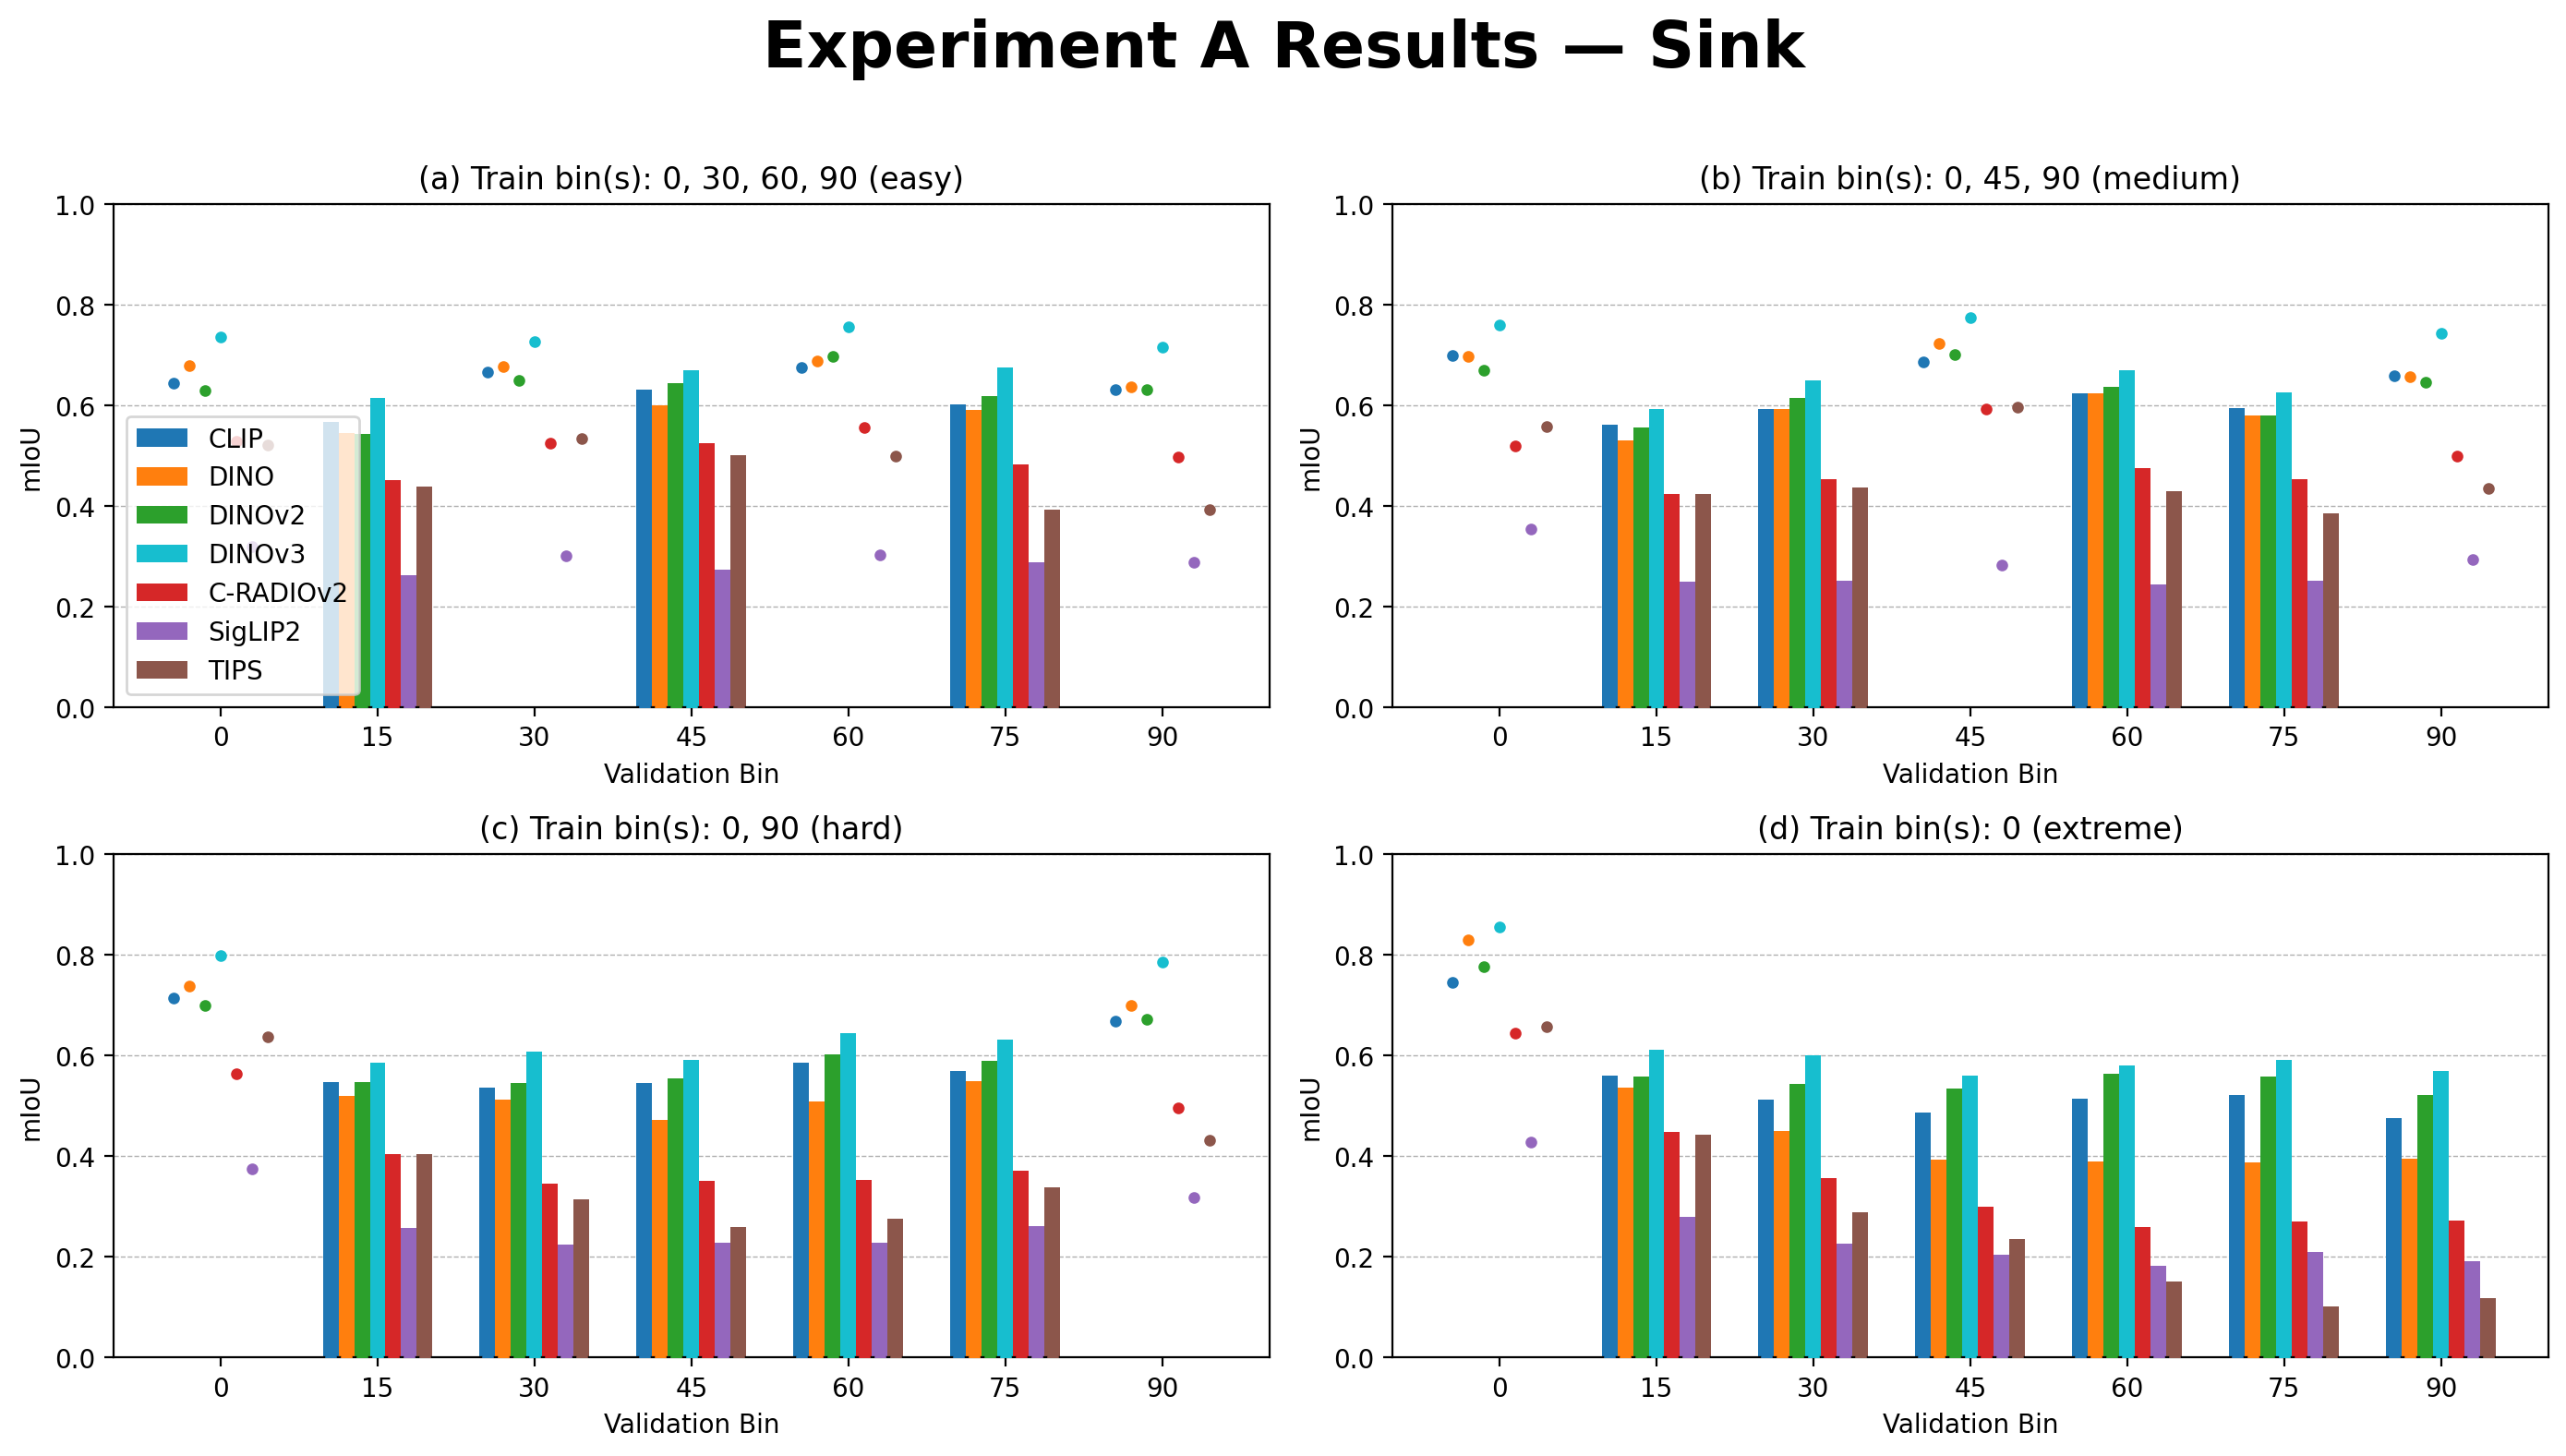

Saved figure to ../images/figures/13_strings.png


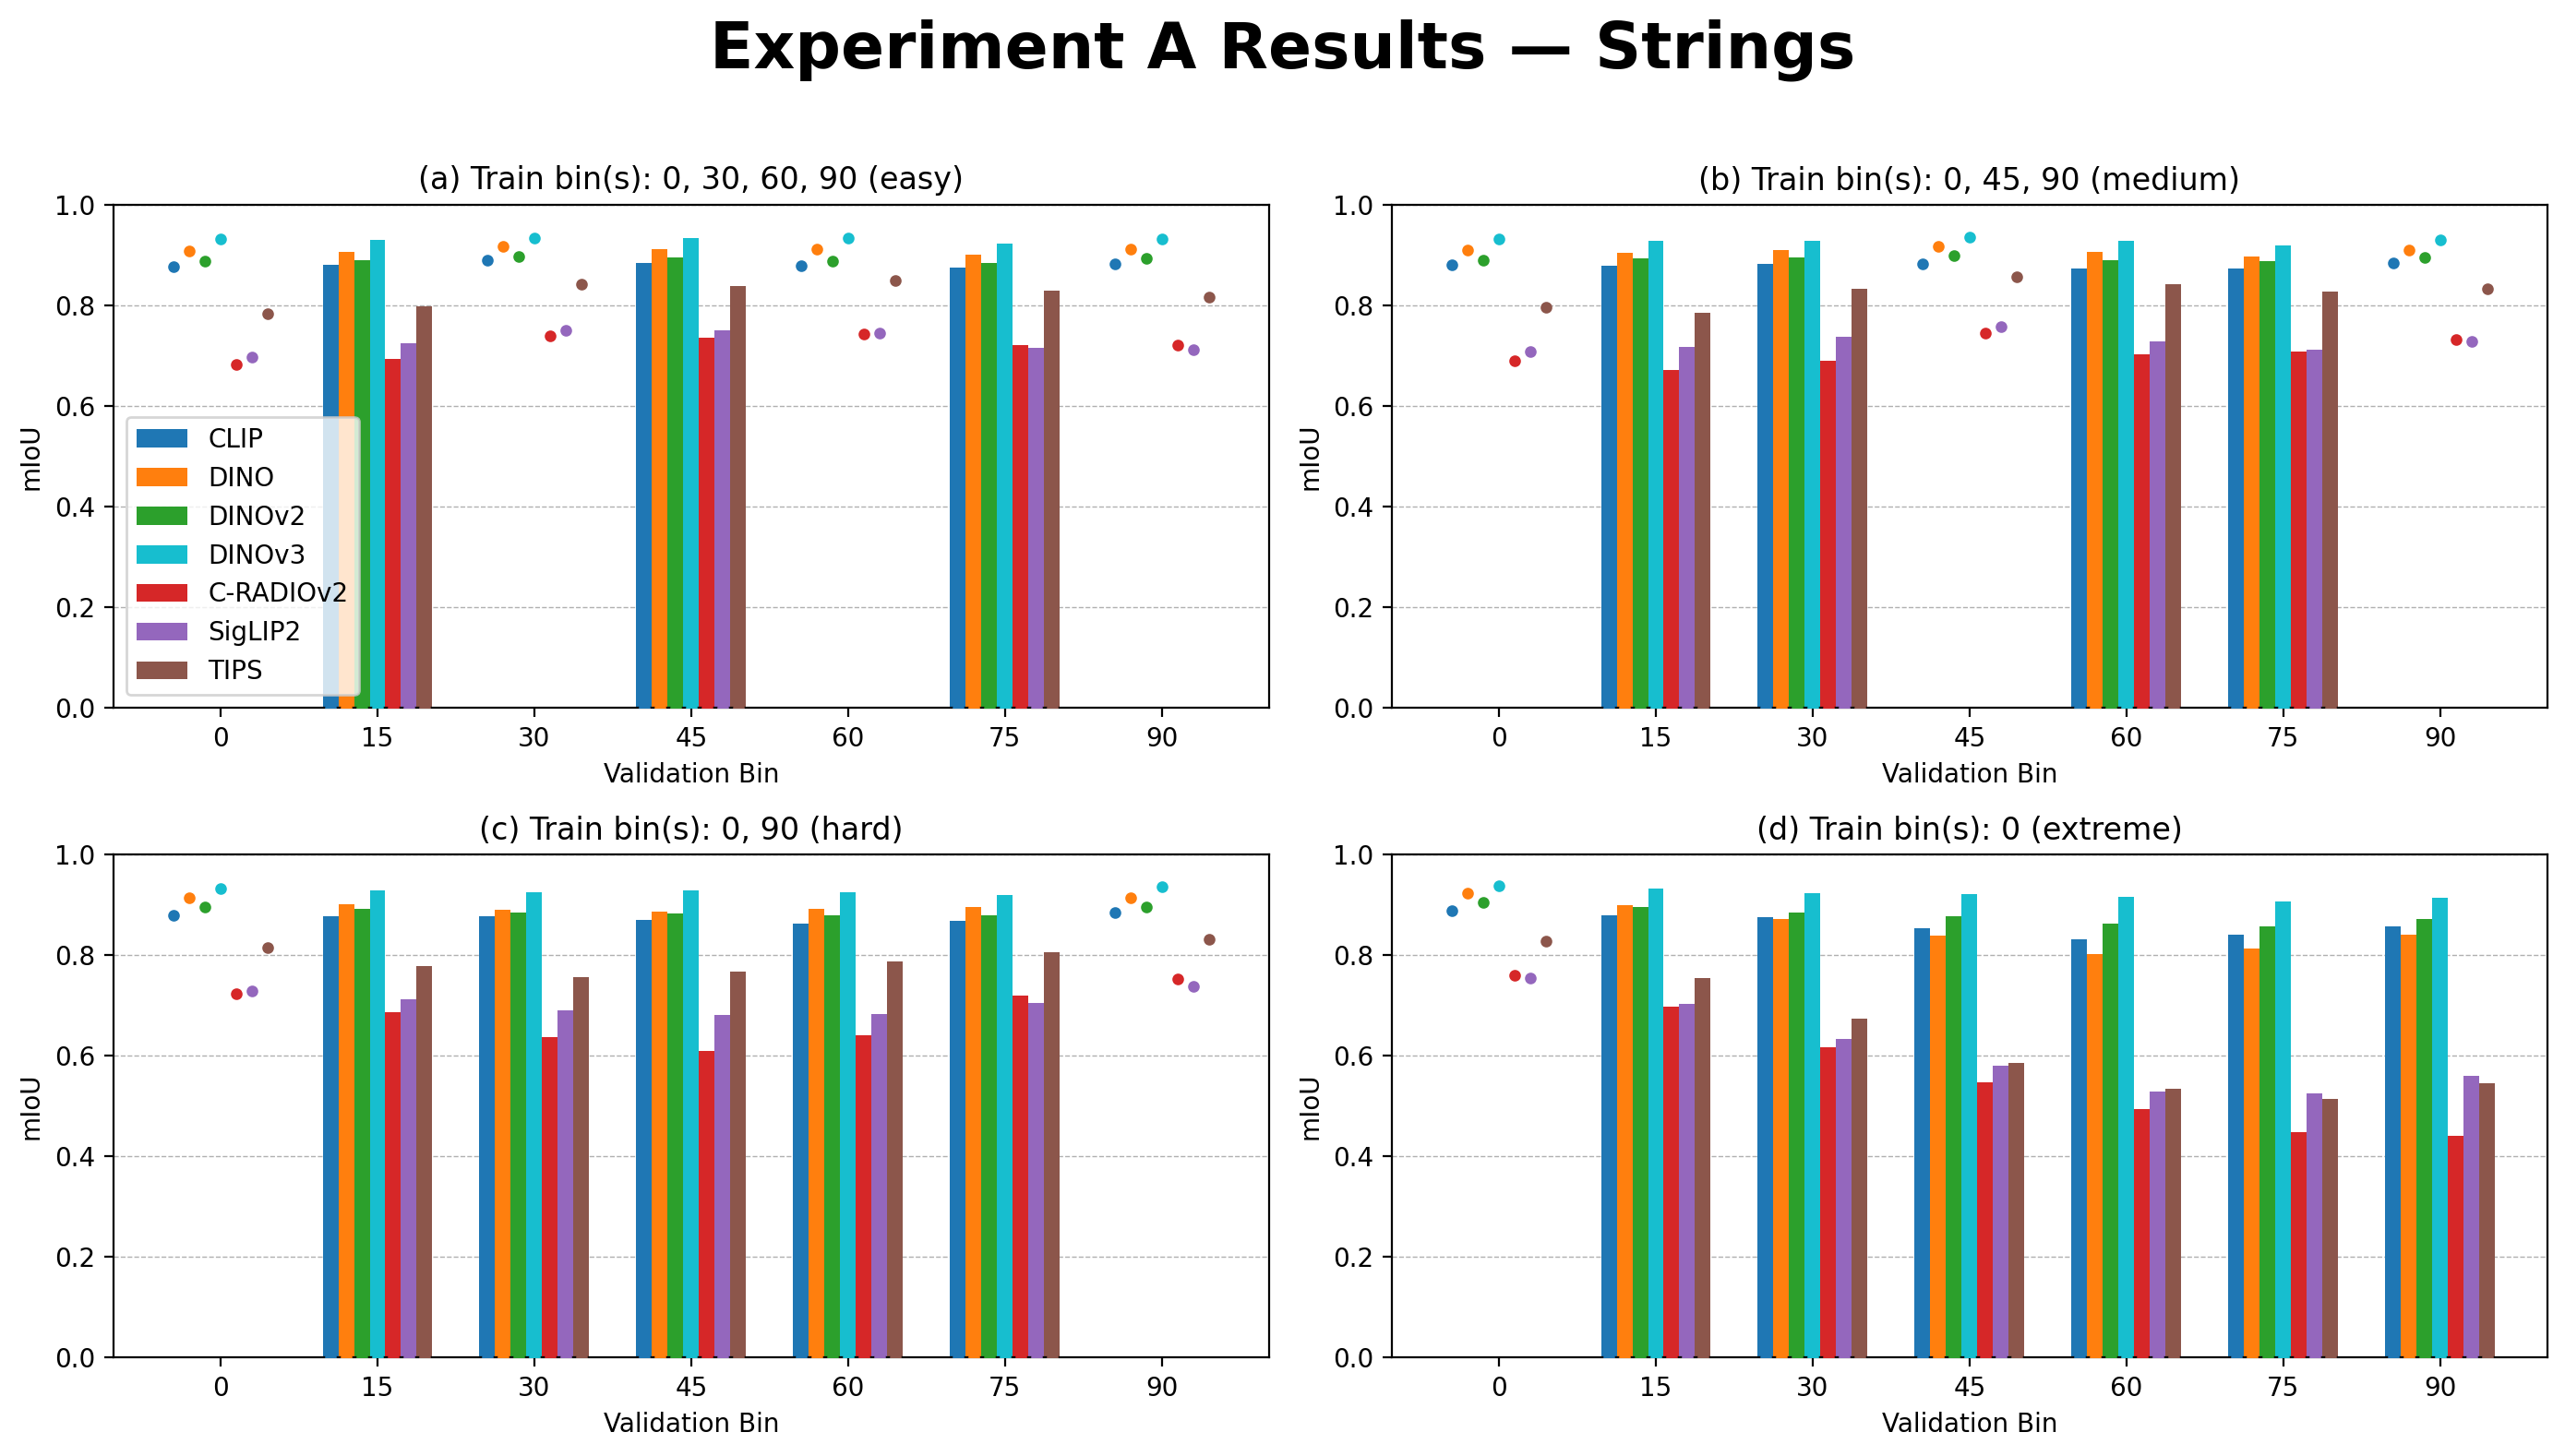

Saved figure to ../images/figures/14_broccoli.png


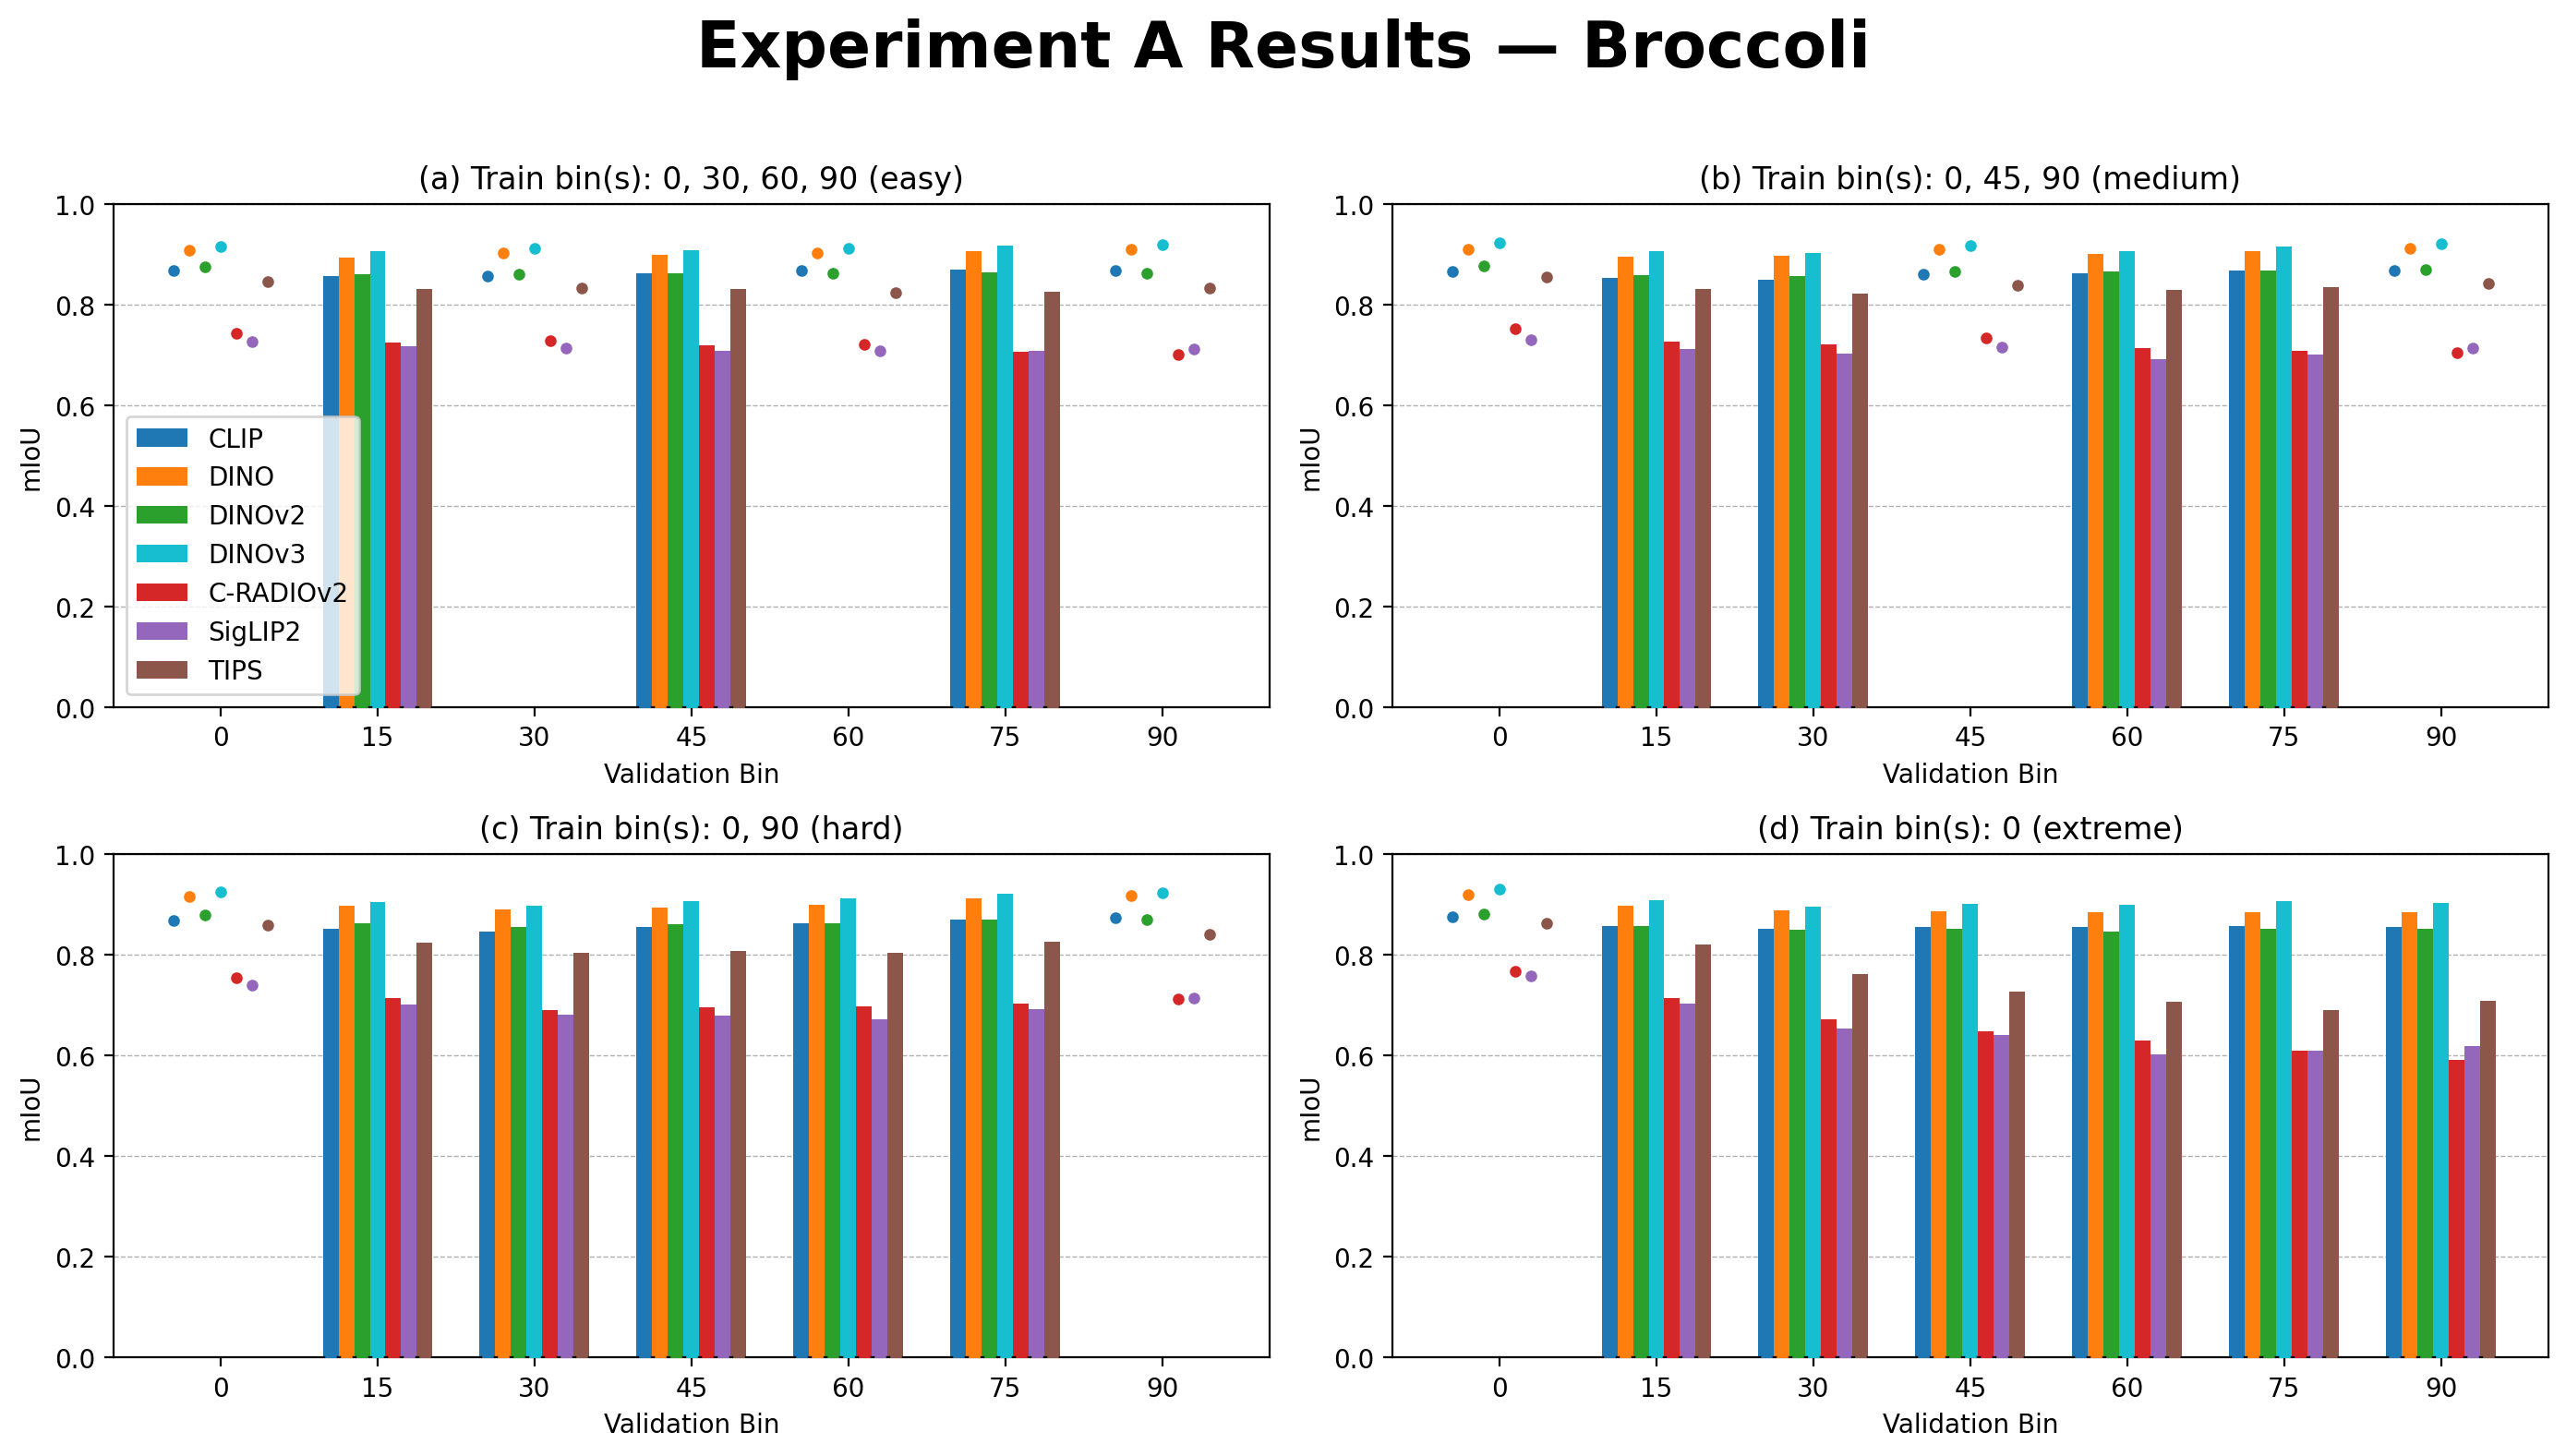

Saved figure to ../images/figures/15_durian.png


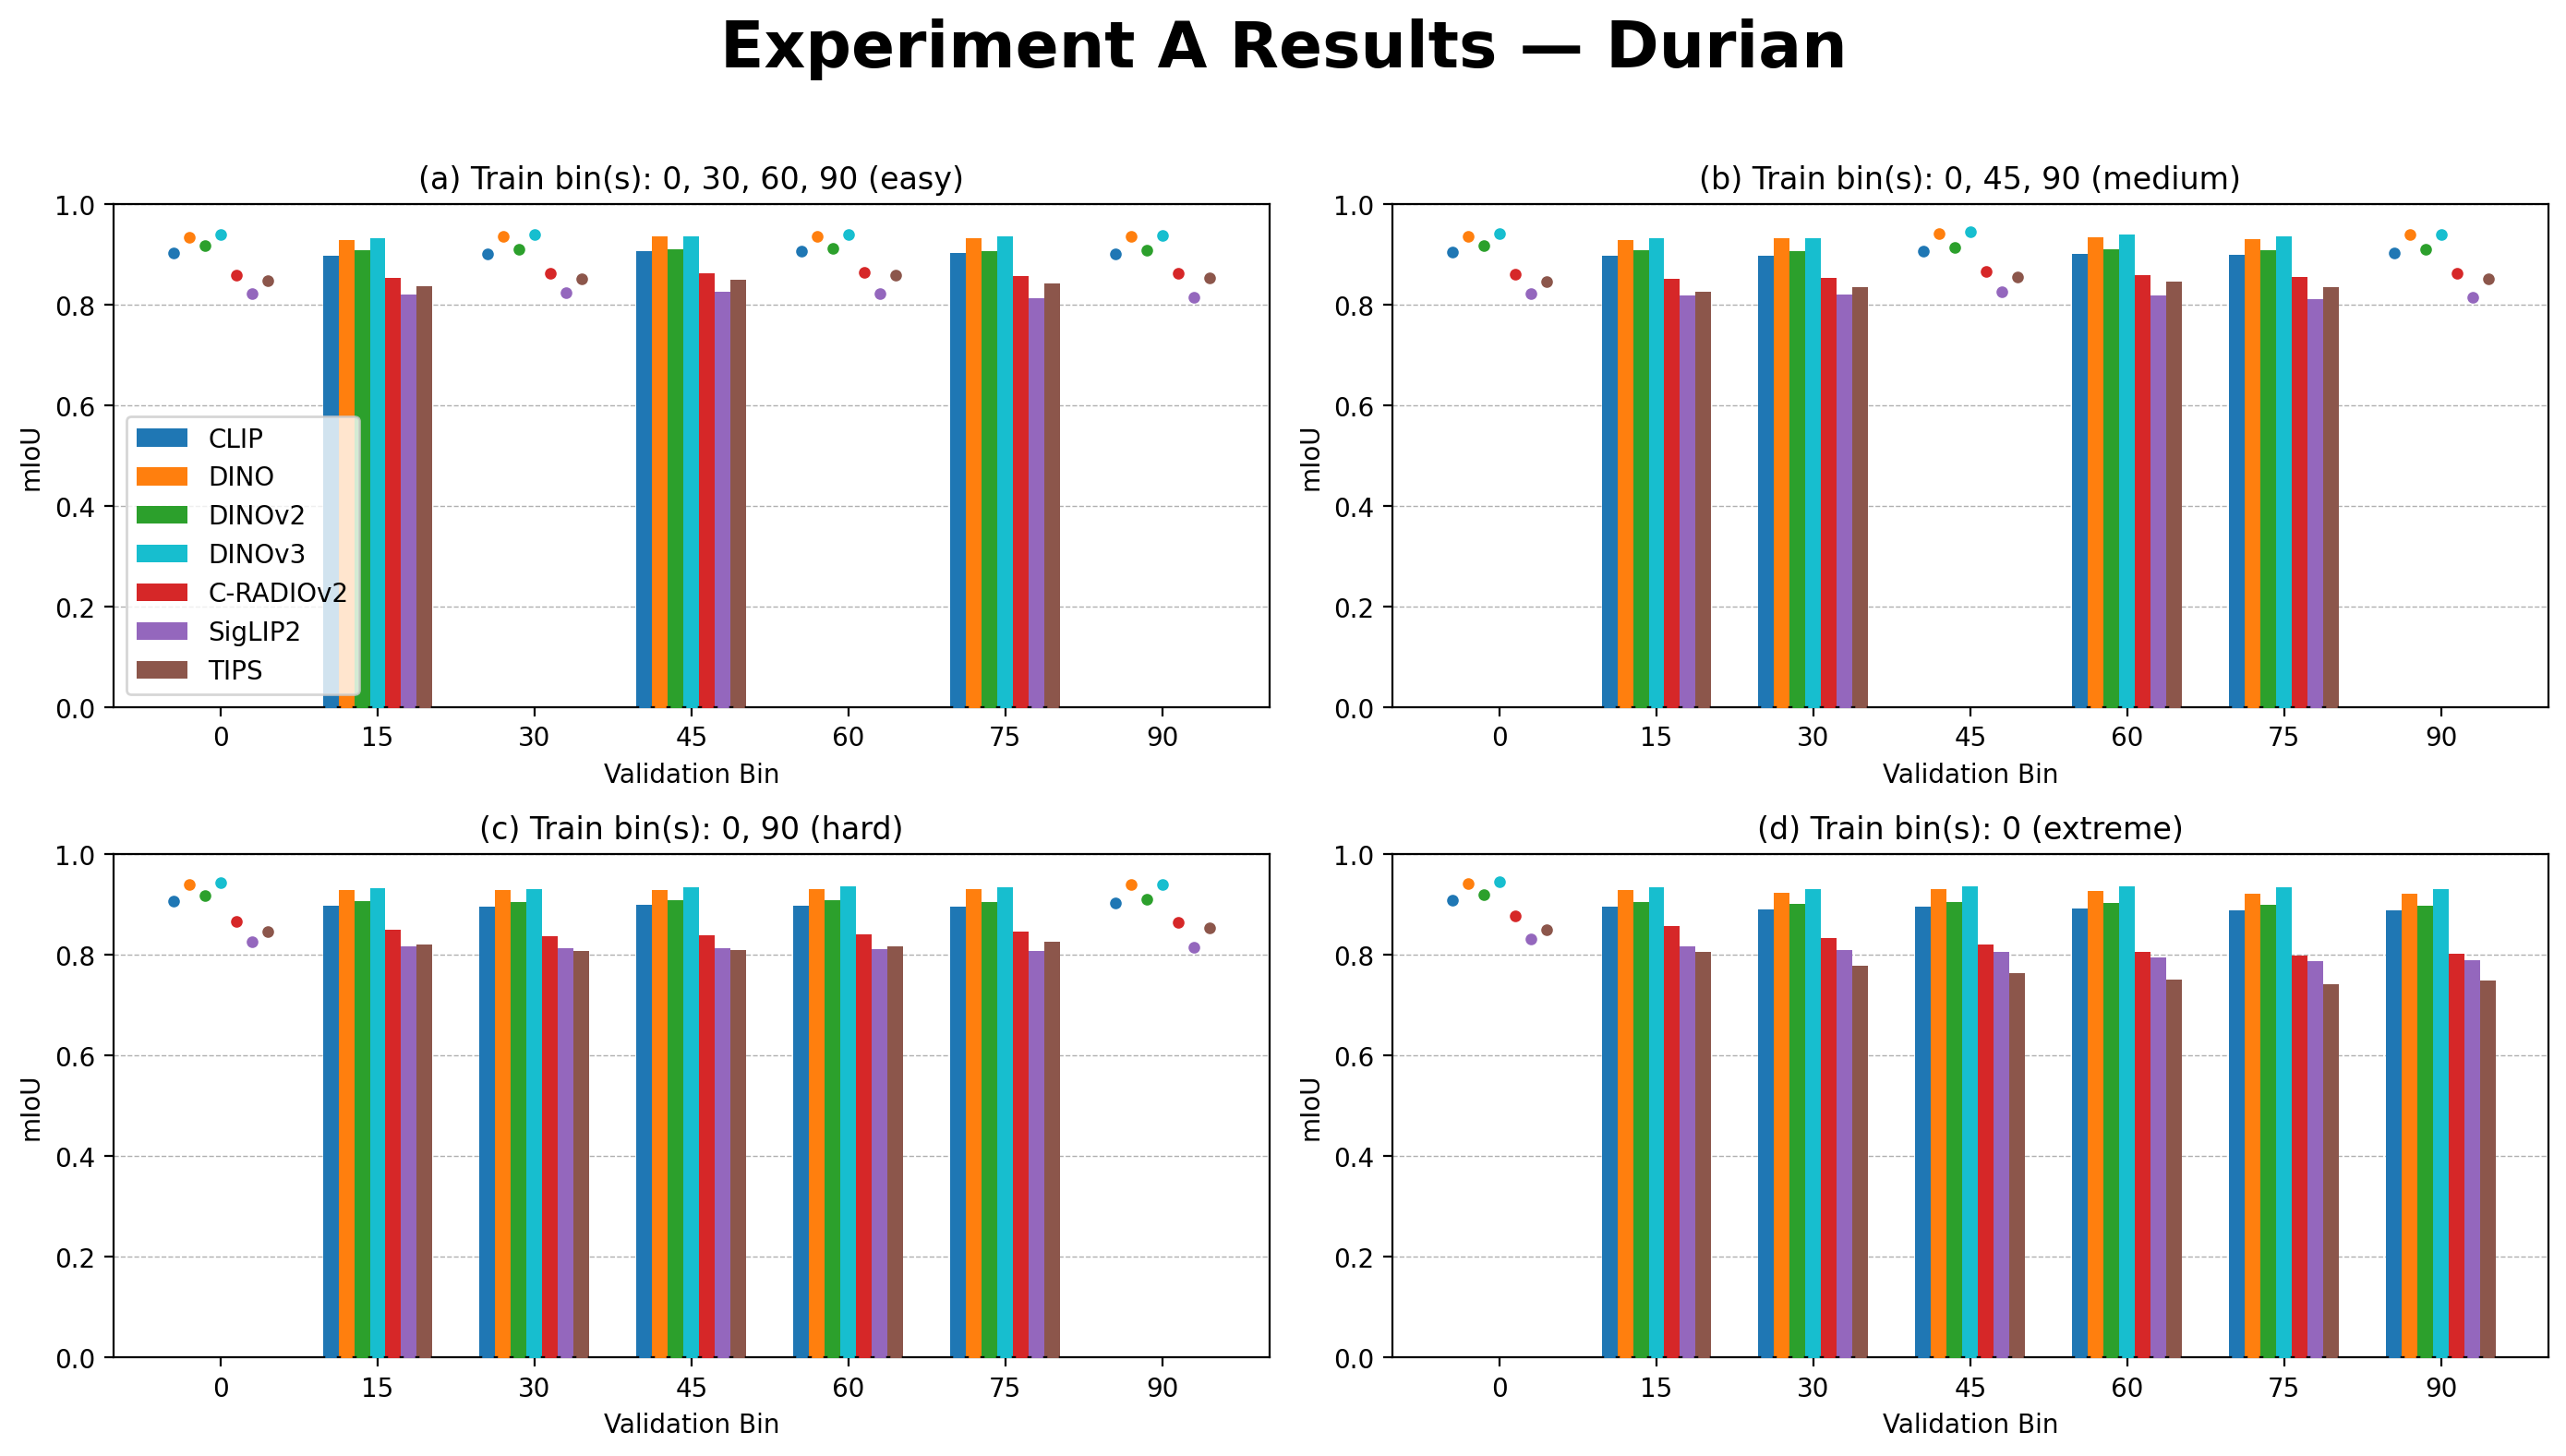

In [7]:

# Plot each class separately
for idx, (class_id, class_name) in enumerate(CLASS_TO_NAME.items()):
    save_path = f"../images/figures/{idx}_{class_name.replace(' ', '_')}.png"
    if class_id == 0:
        plot_exp_a([class_id], include_bg=True, extratitle=class_name.capitalize(), save_path=save_path)
    else:
        plot_exp_a([class_id], include_bg=False, extratitle=class_name.capitalize(), save_path=save_path)


### Comparing per class to the miou over all classes

In [8]:
DF_A = DF.copy()
# Compute baseline: mean over all classes jac0..jac15
class_cols = [f"jac{i}" for i in CLASS_TO_INDEX.values()]
DF_A["mean_all_classes"] = DF_A[class_cols].mean(axis=1)


In [9]:
rows = []

for _, row in DF_A.iterrows():

    model = row["model"]
    train_bins = row["train_bins"]
    difficulty = TRAIN_BINS_DIFFICULTY[train_bins]
    val_bin = row["val_bin"]
    all_mean = row["mean_all_classes"]

    for class_id, class_idx in CLASS_TO_INDEX.items():
        class_score = row[f"jac{class_idx}"]

        class_name = CLASS_TO_NAME[class_id]  # or CLASS_TO_NAME
        combined = f"{class_id} ({class_name})"

        rows.append({
            "model": model,
            "difficulty": difficulty,
            "train_bins": train_bins,
            "val_bin": val_bin,
            "class_id": class_id,
            "class_name": class_name,
            "class_full": combined,
            "class_mIoU": class_score,
            "all_classes_mIoU": all_mean,
            "difference": class_score - all_mean
        })

TABLE = pd.DataFrame(rows)


In [10]:
# Average difference per class (which classes underperform?)
TABLE.groupby("class_full")["difference"].mean().sort_values()

class_full
99 (coat rack)       -0.212293
126 (sink)           -0.187012
100 (guitar stand)   -0.185258
46 (bed)             -0.182691
19 (microwave)       -0.042333
70 (toy dragon)      -0.026266
113 (ceiling lamp)   -0.024173
60 (toy cow)         -0.018780
57 (toy cat)         -0.004454
8 (sofa)              0.041301
125 (toilet)          0.059836
7 (stove)             0.064417
152 (strings)         0.100693
166 (broccoli)        0.118551
196 (durian)          0.178559
0 (background)        0.319903
Name: difference, dtype: float64

In [11]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

TABLE.groupby(["model", "difficulty", "class_full"])["difference"].mean()

model                            difficulty  class_full        
C-RADIOv2-B                      easy        0 (background)        0.301937
                                             100 (guitar stand)   -0.248491
                                             113 (ceiling lamp)    0.022795
                                             125 (toilet)          0.202937
                                             126 (sink)           -0.155205
                                             152 (strings)         0.055366
                                             166 (broccoli)        0.055795
                                             19 (microwave)       -0.050920
                                             196 (durian)          0.194937
                                             46 (bed)             -0.062634
                                             57 (toy cat)         -0.040348
                                             60 (toy cow)         -0.057063
                        

In [12]:
def parse_train_bins(s):
    return set(map(int, s.split("_")))

TABLE["is_seen_bin"] = TABLE.apply(
    lambda r: r["val_bin"] in parse_train_bins(r["train_bins"]),
    axis=1
)


In [13]:
UNSEEN = TABLE[TABLE["is_seen_bin"] == False]


In [14]:
UNSEEN.groupby(["model", "difficulty", "class_full"])["difference"].mean()

model                            difficulty  class_full        
C-RADIOv2-B                      easy        0 (background)        0.314708
                                             100 (guitar stand)   -0.251292
                                             113 (ceiling lamp)    0.025708
                                             125 (toilet)          0.212708
                                             126 (sink)           -0.164292
                                             152 (strings)         0.066708
                                             166 (broccoli)        0.066042
                                             19 (microwave)       -0.056292
                                             196 (durian)          0.206375
                                             46 (bed)             -0.103958
                                             57 (toy cat)         -0.033625
                                             60 (toy cow)         -0.050292
                        

In [15]:
UNSEEN.groupby(["model", "difficulty", "class_full"])["class_mIoU"].mean()

model                            difficulty  class_full        
C-RADIOv2-B                      easy        0 (background)        0.965000
                                             100 (guitar stand)    0.399000
                                             113 (ceiling lamp)    0.676000
                                             125 (toilet)          0.863000
                                             126 (sink)            0.486000
                                             152 (strings)         0.717000
                                             166 (broccoli)        0.716333
                                             19 (microwave)        0.594000
                                             196 (durian)          0.856667
                                             46 (bed)              0.546333
                                             57 (toy cat)          0.616667
                                             60 (toy cow)          0.600000
                        

In [16]:
pd.pivot_table(
    UNSEEN,
    values="class_mIoU",
    index="difficulty",
    columns="model",
    aggfunc="mean"
)

model       C-RADIOv2-B  clip-vit-base-patch16  dino_vitb16  dinov2_vitb14  \
difficulty                                                                   
easy           0.650292               0.759146     0.781208       0.767979   
extreme        0.519844               0.711250     0.694427       0.736365   
hard           0.596500               0.741988     0.750850       0.754613   
medium         0.636766               0.754750     0.774656       0.763375   

model       dinov3-vitb16-pretrain-lvd1689m  siglip2-base-patch16-512  \
difficulty                                                              
easy                               0.814042                  0.567104   
extreme                            0.784000                  0.496667   
hard                               0.798600                  0.539125   
medium                             0.809156                  0.557531   

model       tips-b14   vggt-1b  
difficulty                      
easy        0.663750  0.213104  
extreme     0.484135  0.151406  
hard        0.595263  0.177212  
medium      0.648516  0.197344

In [17]:
pd.pivot_table(
    UNSEEN,
    values="difference",
    index="difficulty",
    columns="model",
    aggfunc="mean"
)

model        C-RADIOv2-B  clip-vit-base-patch16   dino_vitb16  dinov2_vitb14  \
difficulty                                                                     
easy       -1.387779e-17          -3.932040e-17 -2.081668e-17  -6.245005e-17   
extreme     6.129356e-17           2.544261e-17 -4.625929e-18   2.949030e-17   
hard        6.938894e-18           1.457168e-17 -5.828671e-17   4.996004e-17   
medium     -6.938894e-17          -3.295975e-17 -1.561251e-17  -4.943962e-17   

model       dinov3-vitb16-pretrain-lvd1689m  siglip2-base-patch16-512  \
difficulty                                                              
easy                           1.619075e-17             -4.394633e-17   
extreme                        1.040834e-17             -2.197316e-17   
hard                           5.551115e-18              3.053113e-17   
medium                        -1.214306e-17             -6.331741e-17   

model           tips-b14       vggt-1b  
difficulty                              
easy        3.469447e-18 -1.098658e-17  
extreme     3.238150e-17 -3.469447e-18  
hard       -2.706169e-17  1.387779e-18  
medium      3.382711e-17  4.336809e-18

## Job Statistics

In [18]:
DF_JOB = DF.copy()

job_id = str(DF_JOB['job_id'].iloc[0])
model = DF_JOB['model'].iloc[0]
prefix = PREFIXES.get(model)
if prefix is None:
    raise ValueError(f"Unknown model name: {model}")

log_path = Path(f"../logs/exp_a_b/{prefix}.job_{job_id}.log")

# Read last 15 lines after JOB STATISTICS
def tail_log_after_statistics(path, num_lines=15):
    if not path.exists():
        return f"Log file not found: {path}"
    
    with open(path, 'r') as f:
        lines = f.readlines()
        try:
            start_idx = next(i for i, line in enumerate(lines) if 'JOB STATISTICS' in line)
            return ''.join(lines[start_idx:start_idx + num_lines])
        except StopIteration:
            return "JOB STATISTICS not found in log file."

# Output result
log_tail = tail_log_after_statistics(log_path)
print(log_tail)


JOB STATISTICS
Job ID: 12094740
Cluster: snellius
User/Group: scur0542/scur0542
State: COMPLETED (exit code 0)
Nodes: 1
Cores per node: 72
CPU Utilized: 3-11:02:33
CPU Efficiency: 13.87% of 24-22:33:36 core-walltime
Job Wall-clock time: 08:18:48
Memory Utilized: 203.63 GB
Memory Efficiency: 42.42% of 480.00 GB (480.00 GB/node)



In [19]:
# Get all unique (job_id, model) pairs
unique_jobs = DF.copy()
unique_jobs = unique_jobs[['job_id', 'model']].drop_duplicates()

# Function to extract JOB STATISTICS section
def print_job_statistics(job_id, model):
    prefix = PREFIXES.get(model)
    if not prefix:
        print(f"Skipping unknown model: {model}")
        return
    
    log_path = Path(f"../logs/exp_a_b/{prefix}.job_{job_id}.log")
    print(f"\n=== JOB STATISTICS for job_id: {job_id}, model: {model} ===")
    
    if not log_path.exists():
        print(f"Log file not found: {log_path}")
        return

    with open(log_path, 'r') as f:
        lines = f.readlines()
        try:
            start_idx = next(i for i, line in enumerate(lines) if 'JOB STATISTICS' in line)
            for line in lines[start_idx:]:
                print(line, end='')  # already includes newline
        except StopIteration:
            print("'JOB STATISTICS' section not found in log.")

# Loop and print
print(f"The following JOB STATISTICS are for memory: {MEMORY}")
for _, row in unique_jobs.iterrows():
    job_id = str(row['job_id'])
    model = row['model']
    print_job_statistics(job_id, model)


The following JOB STATISTICS are for memory: 640000

=== JOB STATISTICS for job_id: 12094740, model: C-RADIOv2-B ===
JOB STATISTICS
Job ID: 12094740
Cluster: snellius
User/Group: scur0542/scur0542
State: COMPLETED (exit code 0)
Nodes: 1
Cores per node: 72
CPU Utilized: 3-11:02:33
CPU Efficiency: 13.87% of 24-22:33:36 core-walltime
Job Wall-clock time: 08:18:48
Memory Utilized: 203.63 GB
Memory Efficiency: 42.42% of 480.00 GB (480.00 GB/node)

=== JOB STATISTICS for job_id: 12094724, model: clip-vit-base-patch16 ===
JOB STATISTICS
Job ID: 12094724
Cluster: snellius
User/Group: scur0542/scur0542
State: COMPLETED (exit code 0)
Nodes: 1
Cores per node: 72
CPU Utilized: 3-10:39:36
CPU Efficiency: 13.75% of 25-01:12:00 core-walltime
Job Wall-clock time: 08:21:00
Memory Utilized: 177.58 GB
Memory Efficiency: 37.00% of 480.00 GB (480.00 GB/node)

=== JOB STATISTICS for job_id: 12094741, model: siglip2-base-patch16-512 ===
JOB STATISTICS
Job ID: 12094741
Cluster: snellius
User/Group: scur0542/s

## Table

In [20]:
df = DF.copy()

# change train_bins to a list of integers
df["train_bins"] = df["train_bins"].apply(lambda x: list(map(int, x.split("_"))))

# if val_bin is in train_bins, set val_in_trained accordingly
df["val_in_trained"] = df.apply(lambda row: row["val_bin"] in row["train_bins"], axis=1)

# set difficulty column
df["difficulty"] = df["train_bins"].apply(lambda x: TRAIN_BINS_DIFFICULTY["_".join(map(str, x))])

# filter only untrained bins
df = df[~df["val_in_trained"]].copy()

df_exp_a = pd.DataFrame(columns=["model", "easy", "medium", "hard", "extreme"])

# for each model and difficulty, calculate the mean and std of jac_mean
for model in MODELS.keys():
    model_df = df[df["model"] == model]
    model_df.loc[:, "jac_mean"] = model_df[[f"jac{i}" for i in range(1, 16)]].mean(axis=1)
    model_df.loc[:, "jac_std"] = model_df[[f"jac{i}" for i in range(1, 16)]].std(axis=1)
    
    # calculate mean and std for each difficulty
    means = model_df.groupby("difficulty")["jac_mean"].mean()
    stds = model_df.groupby("difficulty")["jac_std"].mean()

    # create a row for the model
    row = {
        "model": MODELS[model],
        "easy": f"{means.get('easy', 0):.3f} ± {stds.get('easy', 0):.3f}",
        "medium": f"{means.get('medium', 0):.3f} ± {stds.get('medium', 0):.3f}",
        "hard": f"{means.get('hard', 0):.3f} ± {stds.get('hard', 0):.3f}",
        "extreme": f"{means.get('extreme', 0):.3f} ± {stds.get('extreme', 0):.3f}"
    }
    
    df_exp_a = pd.concat([df_exp_a, pd.DataFrame([row])], ignore_index=True)

df_exp_a

model           easy         medium           hard        extreme
0       CLIP  0.745 ± 0.132  0.740 ± 0.136  0.727 ± 0.141  0.694 ± 0.150
1       DINO  0.768 ± 0.137  0.761 ± 0.141  0.736 ± 0.156  0.676 ± 0.173
2     DINOv2  0.754 ± 0.138  0.750 ± 0.142  0.740 ± 0.147  0.721 ± 0.155
3     DINOv3  0.803 ± 0.133  0.798 ± 0.136  0.787 ± 0.145  0.771 ± 0.157
4  C-RADIOv2  0.629 ± 0.132  0.615 ± 0.135  0.572 ± 0.142  0.491 ± 0.150
5    SigLIP2  0.541 ± 0.152  0.531 ± 0.154  0.511 ± 0.157  0.466 ± 0.149
6       TIPS  0.644 ± 0.144  0.628 ± 0.153  0.571 ± 0.167  0.453 ± 0.170

In [21]:
# give latex table
latex_table = df_exp_a.to_latex(index=False, escape=False, column_format='lcccc', 
                                  header=["Model", "Easy", "Medium", "Hard", "Extreme"])
print(latex_table)

\begin{tabular}{lcccc}
\toprule
Model & Easy & Medium & Hard & Extreme \\
\midrule
CLIP & 0.745 ± 0.132 & 0.740 ± 0.136 & 0.727 ± 0.141 & 0.694 ± 0.150 \\
DINO & 0.768 ± 0.137 & 0.761 ± 0.141 & 0.736 ± 0.156 & 0.676 ± 0.173 \\
DINOv2 & 0.754 ± 0.138 & 0.750 ± 0.142 & 0.740 ± 0.147 & 0.721 ± 0.155 \\
DINOv3 & 0.803 ± 0.133 & 0.798 ± 0.136 & 0.787 ± 0.145 & 0.771 ± 0.157 \\
C-RADIOv2 & 0.629 ± 0.132 & 0.615 ± 0.135 & 0.572 ± 0.142 & 0.491 ± 0.150 \\
SigLIP2 & 0.541 ± 0.152 & 0.531 ± 0.154 & 0.511 ± 0.157 & 0.466 ± 0.149 \\
TIPS & 0.644 ± 0.144 & 0.628 ± 0.153 & 0.571 ± 0.167 & 0.453 ± 0.170 \\
\bottomrule
\end{tabular}



# Experiment B

In [22]:
DF_B = DF.copy()
df_extreme = DF_B[DF_B["train_bins"] == "0"].copy() # extreme difficulty
df_extreme.head(10)

job_id                  model train_bins  val_bin  jac_mean  jac_std  \
126  12094740            C-RADIOv2-B          0        0     0.737    0.114   
127  12094740            C-RADIOv2-B          0       15     0.635    0.151   
128  12094740            C-RADIOv2-B          0       30     0.564    0.172   
129  12094740            C-RADIOv2-B          0       45     0.512    0.182   
130  12094740            C-RADIOv2-B          0       60     0.478    0.189   
131  12094740            C-RADIOv2-B          0       75     0.469    0.192   
132  12094740            C-RADIOv2-B          0       90     0.462    0.194   
133  12094724  clip-vit-base-patch16          0        0     0.810    0.096   
134  12094724  clip-vit-base-patch16          0       15     0.747    0.142   
135  12094724  clip-vit-base-patch16          0       30     0.727    0.151   

      jac0   jac1   jac2   jac3   jac4   jac5   jac6   jac7   jac8   jac9  \
126  0.971  0.752  0.719  0.758  0.759  0.700  0.688  0.654  0.594  0.493   
127  0.962  0.618  0.640  0.569  0.520  0.603  0.599  0.584  0.466  0.386   
128  0.957  0.501  0.594  0.417  0.432  0.523  0.528  0.521  0.391  0.322   
129  0.954  0.436  0.523  0.316  0.395  0.458  0.460  0.462  0.382  0.270   
130  0.953  0.411  0.508  0.260  0.397  0.418  0.407  0.414  0.323  0.248   
131  0.952  0.418  0.499  0.267  0.375  0.393  0.383  0.379  0.316  0.237   
132  0.951  0.434  0.480  0.278  0.276  0.382  0.365  0.363  0.337  0.257   
133  0.974  0.869  0.877  0.826  0.704  0.821  0.796  0.760  0.609  0.636   
134  0.969  0.833  0.830  0.728  0.503  0.781  0.757  0.721  0.506  0.547   
135  0.968  0.822  0.811  0.685  0.472  0.744  0.730  0.711  0.492  0.528   

     jac10  jac11  jac12  jac13  jac14  jac15  d_model  batch_size  \
126  0.749  0.914  0.644  0.760  0.767  0.877      768           4   
127  0.632  0.861  0.449  0.698  0.714  0.857      768           4   
128  0.570  0.789  0.356  0.617  0.672  0.833      768           4   
129  0.526  0.688  0.299  0.547  0.649  0.821      768           4   
130  0.488  0.629  0.260  0.495  0.629  0.805      768           4   
131  0.506  0.648  0.270  0.449  0.610  0.799      768           4   
132  0.507  0.654  0.273  0.441  0.592  0.802      768           4   
133  0.799  0.875  0.745  0.888  0.875  0.908      768           4   
134  0.735  0.856  0.560  0.879  0.857  0.896      768           4   
135  0.688  0.845  0.512  0.876  0.851  0.891      768           4   

     input_size  patch_size  
126         512          16  
127         512          16  
128         512          16  
129         512          16  
130         512          16  
131         512          16  
132         512          16  
133         512          16  
134         512          16  
135         512          16

In [23]:
def plot_exp_b(normalize=False, save_path: str | None = None):
    fig, ax = plt.subplots(figsize=(6, 4), dpi=200)

    if normalize:
        # plt.scatter(0, 1, color="black", marker="x", zorder=5, label="Baseline performance")
        plt.scatter(0, 1, color="black", marker="x", zorder=5, label="Baseline")
        plot_title = "Experiment B results (normalized to 0-bin performance)"
        y_label = "Normalized mIoU"
    else:
        plot_title = "Experiment B results"
        y_label = "mIoU"

    for model in MODELS.keys():
        df = df_extreme[df_extreme["model"] == model].copy()
        df["jac_mean"] = df[[f"jac{i}" for i in range(1, 16)]].mean(axis=1)
        df["jac_std"] = df[[f"jac{i}" for i in range(1, 16)]].std(axis=1)

        if not normalize:
            # plot the 0-bin performance
            df0 = df[df["val_bin"] == 0]
            x_values = df0["val_bin"]
            y_values = df0["jac_mean"]
            plt.scatter(x_values, y_values, color=COLORS[model], marker="x", s=100, zorder=5)

        # plot the other validation bins [15, ..., 90]
        if normalize:
            # get bin=0 performance
            df0 = df[df["val_bin"] == 0]
            model_0_score = df0["jac_mean"].values[0]

            df1590 = df[df["val_bin"] != 0].copy()
            df1590["jac_norm"] = df1590["jac_mean"] / model_0_score
            x_values = df1590["val_bin"]
            y_values = df1590["jac_norm"]
        else:
            df1590 = df[df["val_bin"] != 0]
            x_values = df1590["val_bin"]
            y_values = df1590["jac_mean"].values

        plt.plot(x_values, y_values, label=MODELS[model], color=COLORS[model])

    plt.xlabel("Bin")
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.xticks(XTICKS)
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.ylim(0, 1.1)
    plt.tight_layout()


    # Save figure
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved figure to {save_path}")
    
    plt.show()


## Plots

Saved figure to ../images/expb_norm.png


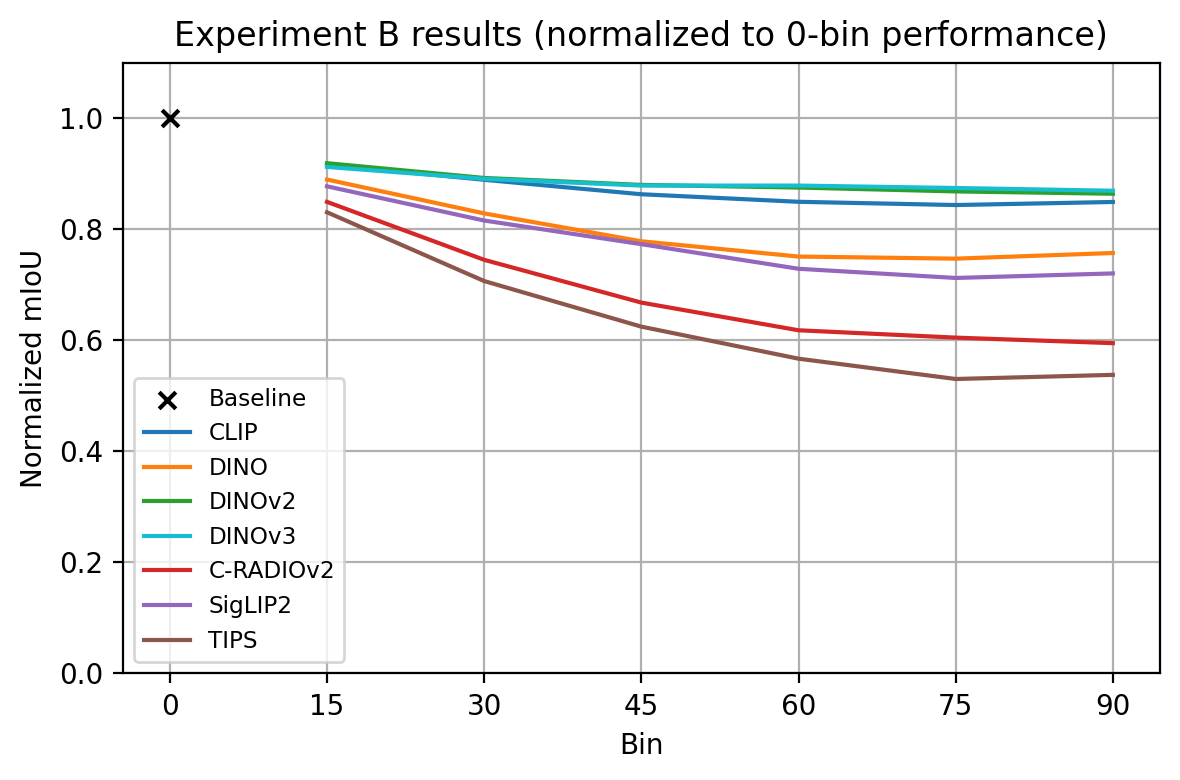

Saved figure to ../images/expb_raw.png


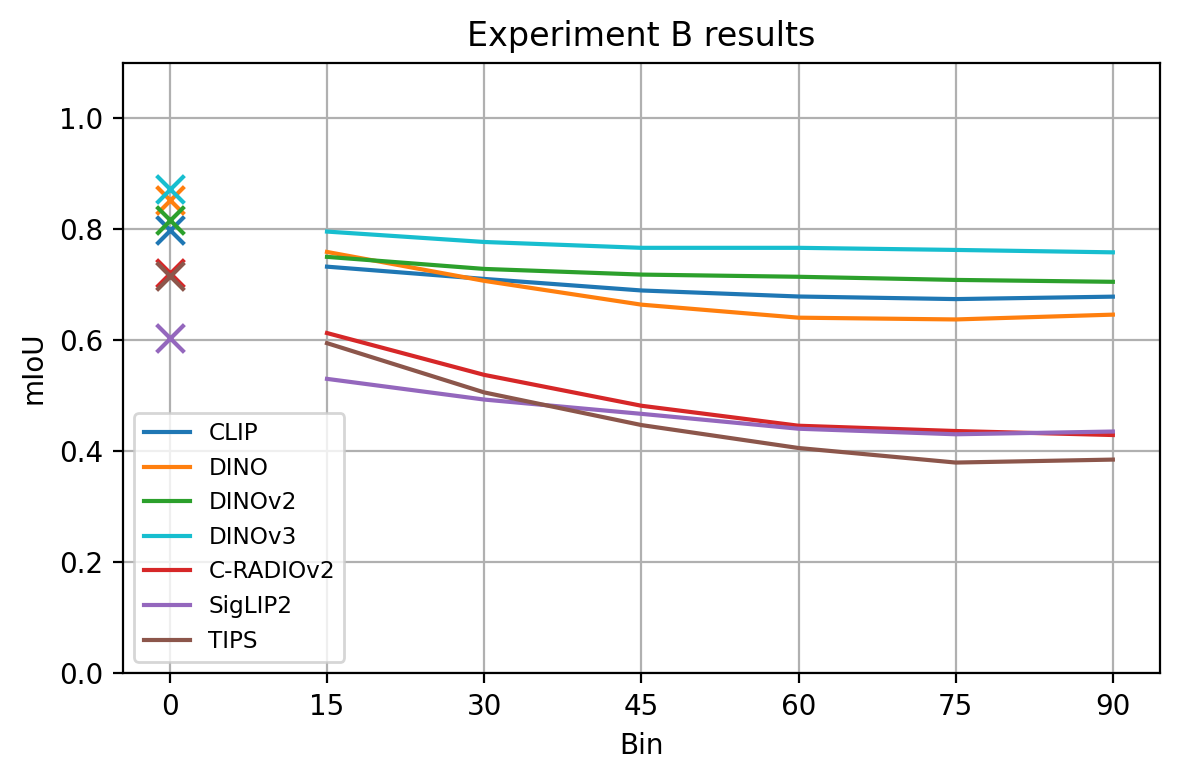

In [24]:
plot_exp_b(normalize=True, save_path="../images/expb_norm.png")
plot_exp_b(normalize=False, save_path="../images/expb_raw.png")

## Table

In [25]:
assert DF.equals(ORIGINAL_DF), "DataFrame DF has been modified!"

In [26]:
# DF.loc[:, "jac_mean"] = DF[[f"jac{i}" for i in range(1, 16)]].mean(axis=1)
# DF.loc[:, "jac_std"] = DF[[f"jac{i}" for i in range(1, 16)]].std(axis=1)

DF_BREAK = ORIGINAL_DF.copy()  # safe copy for experiment B
assert DF_BREAK.equals(ORIGINAL_DF), "DataFrame DF has been modified!"
df_extreme = DF_BREAK[DF_BREAK["train_bins"] == "0"].copy() # extreme difficulty

# Compute jac_mean for each row: raw mIoU per sample.
DF_BREAK.loc[:, "jac_mean"] = DF_BREAK[[f"jac{i}" for i in range(1, 16)]].mean(axis=1)
DF_BREAK.loc[:, "jac_std"] = DF_BREAK[[f"jac{i}" for i in range(1, 16)]].std(axis=1)
final_df = None
threshold = 0.05

for model in MODELS.keys():
    df = df_extreme[df_extreme["model"] == model].copy()
    # df = DF_BREAK[DF_BREAK["model"] == model].copy()

    # get bin=0 performance
    df0 = df[df["val_bin"] == 0]
    model_0_score = df0["jac_mean"].values[0]

    # Divide the jac_mean by the 0-bin performance (model_0_score) to get 
    # normalized jac_mean (jac_norm). This means we are using normalized mIoU, 
    # relative to the 0° bin baseline.
    df["jac_norm"] = df["jac_mean"] / model_0_score

    # jac_mean_prev is jac_mean but shifted down by one row
    df["jac_norm_prev"] = df["jac_norm"].shift(1)

    # Compute delta from jac_norm: Delta is difference between jac norm and shifted jac norm
    # In this way the deltas (drops) are in normalized space.
    # Conclusion: we are currently using normalized mIoU drops to detect breaking points.
    df["delta"] = df["jac_norm"] - df["jac_norm_prev"]
    df = df[df["val_bin"] != 0]

    # concat
    if final_df is None:
        final_df = df.copy()
    else:
        final_df = pd.concat([final_df, df], ignore_index=True)

final_df

# To find a breaking point: check the last column called delta, compare the delta with the threshold
# The first delta exceeding the treshold is the breaking point


job_id                            model train_bins  val_bin  jac_mean  \
0   12094724            clip-vit-base-patch16          0       15     0.747   
1   12094724            clip-vit-base-patch16          0       30     0.727   
2   12094724            clip-vit-base-patch16          0       45     0.707   
3   12094724            clip-vit-base-patch16          0       60     0.697   
4   12094724            clip-vit-base-patch16          0       75     0.693   
5   12094724            clip-vit-base-patch16          0       90     0.697   
6   12094728                      dino_vitb16          0       15     0.773   
7   12094728                      dino_vitb16          0       30     0.724   
8   12094728                      dino_vitb16          0       45     0.684   
9   12094728                      dino_vitb16          0       60     0.662   
10  12094728                      dino_vitb16          0       75     0.658   
11  12094728                      dino_vitb16          0       90     0.667   
12  12094738                    dinov2_vitb14          0       15     0.764   
13  12094738                    dinov2_vitb14          0       30     0.744   
14  12094738                    dinov2_vitb14          0       45     0.734   
15  12094738                    dinov2_vitb14          0       60     0.730   
16  12094738                    dinov2_vitb14          0       75     0.725   
17  12094738                    dinov2_vitb14          0       90     0.722   
18  16934109  dinov3-vitb16-pretrain-lvd1689m          0       15     0.807   
19  16934109  dinov3-vitb16-pretrain-lvd1689m          0       30     0.790   
20  16934109  dinov3-vitb16-pretrain-lvd1689m          0       45     0.780   
21  16934109  dinov3-vitb16-pretrain-lvd1689m          0       60     0.780   
22  16934109  dinov3-vitb16-pretrain-lvd1689m          0       75     0.776   
23  16934109  dinov3-vitb16-pretrain-lvd1689m          0       90     0.772   
24  12094740                      C-RADIOv2-B          0       15     0.635   
25  12094740                      C-RADIOv2-B          0       30     0.564   
26  12094740                      C-RADIOv2-B          0       45     0.512   
27  12094740                      C-RADIOv2-B          0       60     0.478   
28  12094740                      C-RADIOv2-B          0       75     0.469   
29  12094740                      C-RADIOv2-B          0       90     0.462   
30  12094741         siglip2-base-patch16-512          0       15     0.557   
31  12094741         siglip2-base-patch16-512          0       30     0.522   
32  12094741         siglip2-base-patch16-512          0       45     0.498   
33  12094741         siglip2-base-patch16-512          0       60     0.473   
34  12094741         siglip2-base-patch16-512          0       75     0.463   
35  12094741         siglip2-base-patch16-512          0       90     0.468   
36  12094742                         tips-b14          0       15     0.617   
37  12094742                         tips-b14          0       30     0.534   
38  12094742                         tips-b14          0       45     0.479   
39  12094742                         tips-b14          0       60     0.440   
40  12094742                         tips-b14          0       75     0.415   
41  12094742                         tips-b14          0       90     0.420   

    jac_std   jac0   jac1   jac2   jac3   jac4   jac5   jac6   jac7   jac8  \
0     0.142  0.969  0.833  0.830  0.728  0.503  0.781  0.757  0.721  0.506   
1     0.151  0.968  0.822  0.811  0.685  0.472  0.744  0.730  0.711  0.492   
2     0.158  0.968  0.807  0.770  0.655  0.415  0.704  0.696  0.703  0.494   
3     0.159  0.969  0.792  0.766  0.641  0.427  0.676  0.662  0.699  0.421   
4     0.162  0.969  0.786  0.775  0.642  0.417  0.660  0.625  0.678  0.406   
5     0.161  0.969  0.782  0.779  0.648  0.424  0.666  0.637  0.671  0.439   
6     0.146  0.976  0.852  0.855  0.737  0.532  0.832  0.801  